# Analysis of dynamic network ABM
Standard networks, no SDA yet

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import cProfile
import pstats
import mesa
pd.set_option('display.max_colwidth', 10000)
import joblib
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import itertools
from influencer_model import ConsumatModel  # Import the updated model

# Base configuration
base_config = {
    'TP_percentage': 0.5,
    'satisfaction_threshold': 0.5,
    'uncertainty_threshold': 0.5,
    'product_price_range': (5, 10),
    'min_increase_percentage': 4,
    'max_increase_percentage': 10,
    'num_products': 20,
    'inflation_rate': 3,
    'epsilon': 0.5,
    'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'],
    'seed': 42,  # Seed for reproducibility
    'alpha': 10.0,  # Exponent in the social attachment equation
    'beta': 0.5,  # Scaling factor for the wealth differences in the social attachment equation
    'homophily_attribute': 'weight_social',  # Attribute to use for homophily-based rewiring
    'num_influencers': 150    # Number of influencers to identify
}

# Configuration for Watts-Strogatz network
watts_strogatz_config = base_config.copy()
watts_strogatz_config.update({
    'network_type': 'watts_strogatz',
    'network_params': {
        'n': 1600,
        'k': 8,
        'p': 0.1
    }
})

# Configuration for Barabasi-Albert network
barabasi_albert_config = base_config.copy()
barabasi_albert_config.update({
    'network_type': 'barabasi_albert',
    'network_params': {
        'n': 1600,
        'm': 8
    }
})

# Configuration for Random Regular network
random_regular_config = base_config.copy()
random_regular_config.update({
    'network_type': 'random_regular',
    'network_params': {
        'n': 1600,
        'd': 8
    }
})

# Configuration for Holme-Kim network
holme_kim_config = base_config.copy()
holme_kim_config.update({
    'network_type': 'holme_kim',
    'network_params': {
        'n': 1600,
        'm': 8,
        'p': 0.1
    }
})


In [ ]:
def run_simulation(model, num_steps):
    adoption_rates = []

    for _ in tqdm(range(num_steps), desc='Simulation Progress'):
        model.step()
        current_adoption_rate = model.calculate_true_price_adoption_rate()
        adoption_rates.append(current_adoption_rate)

    model_data = model.datacollector.get_model_vars_dataframe()
    agent_data = model.datacollector.get_agent_vars_dataframe()
    model_data['Adoption Rates'] = adoption_rates

    return model_data, agent_data

def run_all_simulations(configurations, num_steps, num_simulations):
    results = {}
    all_simulation_data = {}
    
    for config_name, config in configurations.items():
        print(f"Running simulations for {config_name} with parameters: {config}")
        
        all_simulation_data[config_name] = []
        
        for simulation in range(num_simulations):
            model = ConsumatModel(config)
            model_data, agent_data = run_simulation(model, num_steps)
            all_simulation_data[config_name].append(model_data)

        aggregated_data = pd.concat(all_simulation_data[config_name]).groupby(level=0).mean()
        results[config_name] = aggregated_data

    return results, all_simulation_data

def generate_decision_modes_count(agent_data):
    decision_modes_count = agent_data.groupby(['Step'])[['Repeat', 'Imitate', 'Deliberate', 'Social_Compare']].sum()
    return decision_modes_count

### Plotting functions for various config
def plot_adoption_rates(all_simulation_data, varying_params):
    param_name = list(varying_params.keys())[0]
    
    # Group configurations by network
    network_groups = {}
    for config_name in all_simulation_data.keys():
        network_name = config_name.split('_Config_')[0]
        if network_name not in network_groups:
            network_groups[network_name] = []
        network_groups[network_name].append(config_name)
    
    # Plot each network's configurations
    for network_name, config_names in network_groups.items():
        plt.figure(figsize=(10, 6))
        
        for config_name in config_names:
            data = all_simulation_data[config_name]
            tp_value = config_name.split('_TP_')[1]
            for idx, sim_data in enumerate(data):
                plt.plot(sim_data['Adoption Rates'], marker='o', label=f'{param_name} {tp_value}')
        
        plt.title(f'True Price Adoption Rate Over Iterations for {network_name}')
        plt.xlabel('Iteration')
        plt.ylabel('True Price Adoption Rate (%)')
        plt.ylim(0,100)
        plt.grid(True)
        plt.legend()
        plt.show()

def plot_network_metrics(results, varying_params):
    param_name = list(varying_params.keys())[0]
    
    network_groups = {}
    for config_name in results.keys():
        network_name = config_name.split('_Config_')[0]
        if network_name not in network_groups:
            network_groups[network_name] = []
        network_groups[network_name].append(config_name)
    
    for network_name, config_names in network_groups.items():
        plt.figure(figsize=(10, 5))
        
        metrics_plotted = False
        for config_name in config_names:
            aggregated_data = results[config_name]
            tp_value = config_name.split('_TP_')[1]
            if 'Average Degree' in aggregated_data.columns:
                plt.plot(aggregated_data['Average Degree'], marker='o', label=f'Average Degree {param_name} {tp_value}')
                metrics_plotted = True
            if 'Variance of Degree' in aggregated_data.columns:
                plt.plot(aggregated_data['Variance of Degree'], marker='o', label=f'Variance of Degree {param_name} {tp_value}')
                metrics_plotted = True
            if 'Average Clustering' in aggregated_data.columns:
                plt.plot(aggregated_data['Average Clustering'], marker='o', label=f'Average Clustering {param_name} {tp_value}')
                metrics_plotted = True
            if 'Average Path Length' in aggregated_data.columns:
                plt.plot(aggregated_data['Average Path Length'], marker='o', label=f'Average Path Length {param_name} {tp_value}', linestyle='--')
                metrics_plotted = True
        
        if metrics_plotted:
            plt.xlabel('Step')
            plt.ylabel('Metric Value')
            plt.title(f'Network Metrics Over Time for {network_name}')
            plt.legend()
            plt.show()

def plot_decision_modes(network_configurations, num_steps):
    for network_name, config in network_configurations.items():
        model = ConsumatModel(config)
        _, agent_data = run_simulation(model, num_steps)
        
        decision_modes_count = generate_decision_modes_count(agent_data)
        print(f"Decision Mode Counts for {network_name} network:")
        print(decision_modes_count)

        plt.figure(figsize=(12, 8))
        plt.plot(decision_modes_count.index, decision_modes_count['Repeat'], label='Repeat', linestyle='-', marker='o')
        plt.plot(decision_modes_count.index, decision_modes_count['Imitate'], label='Imitate', linestyle='--', marker='x')
        plt.plot(decision_modes_count.index, decision_modes_count['Deliberate'], label='Deliberate', linestyle='-.', marker='s')
        plt.plot(decision_modes_count.index, decision_modes_count['Social_Compare'], label='Social Compare', linestyle=':', marker='d')
        plt.title(f'Decision Modes over Time for {network_name} network')
        plt.xlabel('Time Step')
        plt.ylabel('Number of Agents')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True)
        plt.show()


In [ ]:
### Create configs based on varying parameters

def generate_configurations(base_config, varying_params):
    keys, values = zip(*varying_params.items())
    configurations = []
    
    for combination in itertools.product(*values):
        config = base_config.copy()
        config.update(dict(zip(keys, combination)))
        configurations.append(config)
    
    return configurations

### Varying TP_percentage
# Example network configurations (replace with actual configurations)
network_configurations = {
    'Watts-Strogatz': watts_strogatz_config,
    'Barabasi-Albert': barabasi_albert_config,
    'Random Regular': random_regular_config,
    'Holme-Kim': holme_kim_config
}

# Varying parameters
varying_params = {
    'TP_percentage': np.arange(0.4, 0.9, 0.05).tolist(),
}

num_simulations = 1
num_steps = 10

# Generate configurations
all_configurations = {}
for network_name, net_config in network_configurations.items():
    net_configs = generate_configurations({**base_config, **net_config}, varying_params)
    for idx, config in enumerate(net_configs):
        config_name = f"{network_name}_Config_{idx+1}_TP_{config['TP_percentage']}"
        all_configurations[config_name] = config

# Run all simulations
results, all_simulation_data = run_all_simulations(all_configurations, num_steps, num_simulations)

# Plotting results
plot_adoption_rates(all_simulation_data, varying_params)


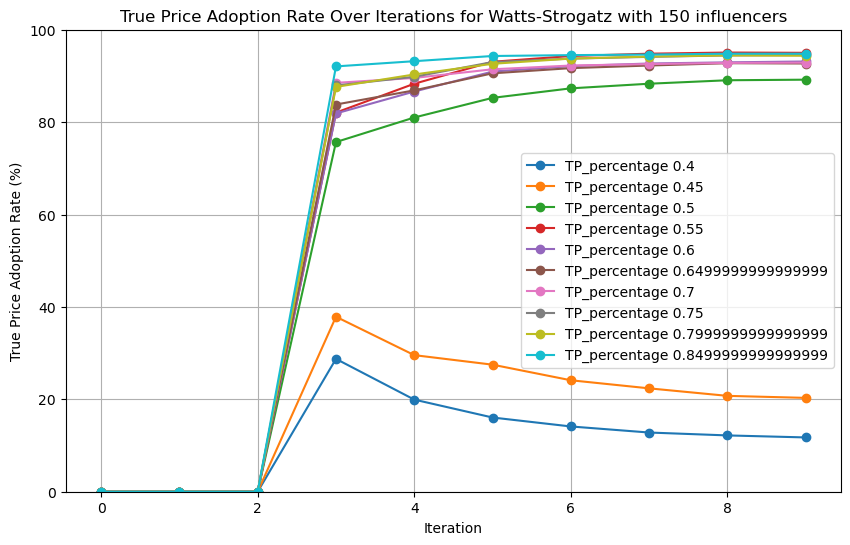

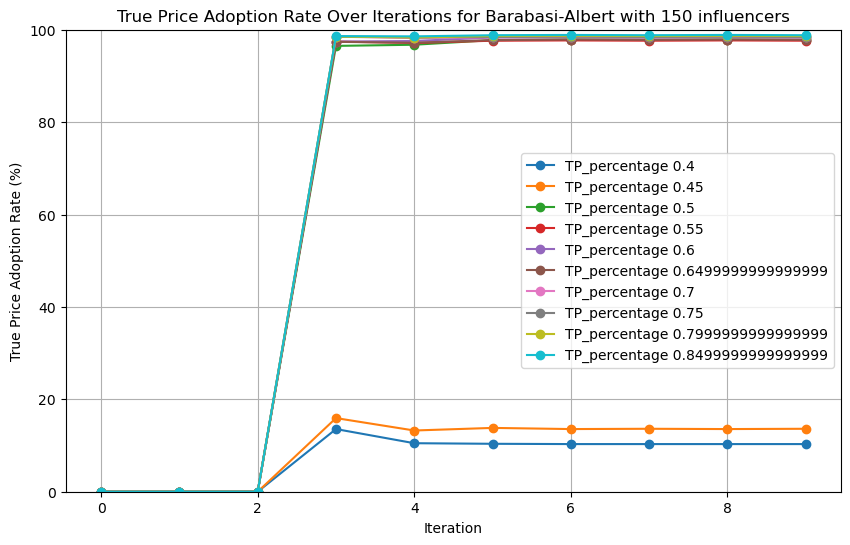

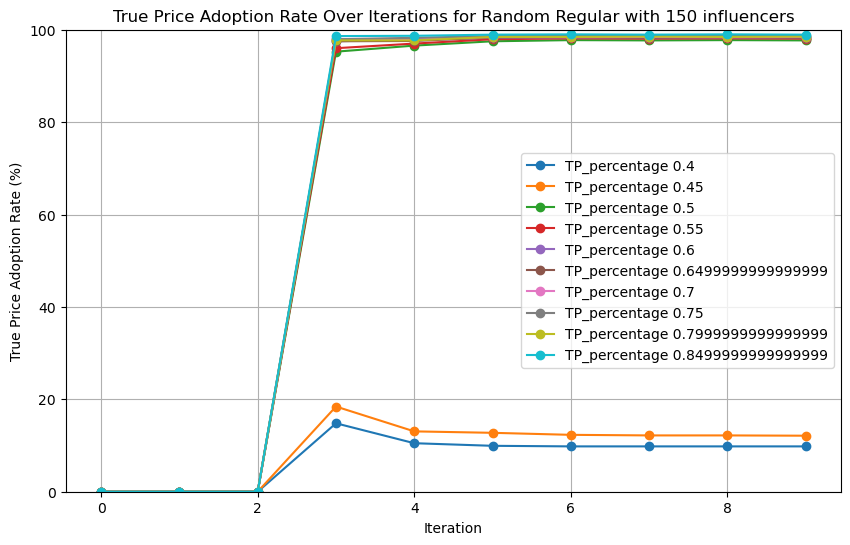

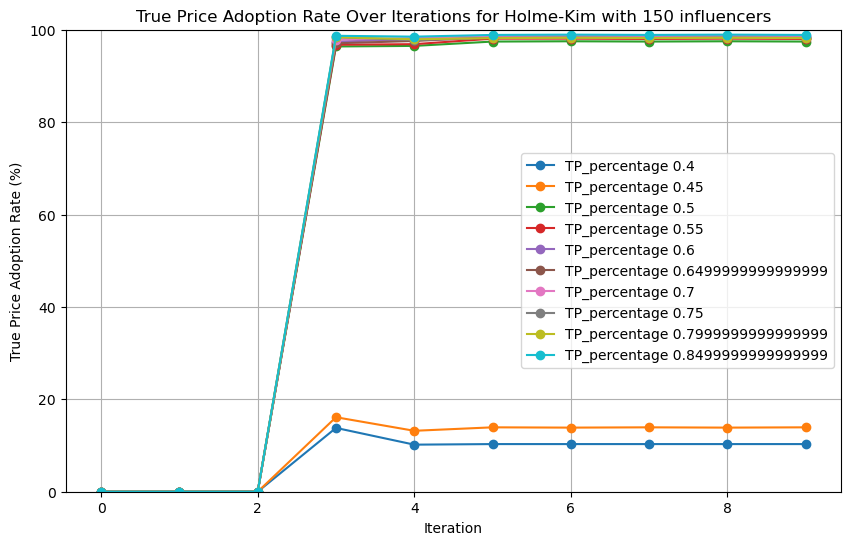

In [87]:
import matplotlib.pyplot as plt  

def plot_adoption_rates(all_simulation_data, varying_params):
    param_name = list(varying_params.keys())[0]
    
    # Group configurations by network
    network_groups = {}
    for config_name in all_simulation_data.keys():
        network_name = config_name.split('_Config_')[0]
        if network_name not in network_groups:
            network_groups[network_name] = []
        network_groups[network_name].append(config_name)
    
    # Plot each network's configurations
    for network_name, config_names in network_groups.items():
        plt.figure(figsize=(10, 6))
        
        for config_name in config_names:
            data = all_simulation_data[config_name]
            tp_value = config_name.split('_TP_')[1]
            for idx, sim_data in enumerate(data):
                plt.plot(sim_data['Adoption Rates'], marker='o', label=f'{param_name} {tp_value}')
        
        plt.title(f'True Price Adoption Rate Over Iterations for {network_name} with 150 influencers')
        plt.xlabel('Iteration')
        plt.ylabel('True Price Adoption Rate (%)')
        plt.ylim(0, 100)
        plt.grid(True)
        plt.legend()
        plt.savefig(f"/Users/alexelphinstone/Downloads/ThesisNew-1/Experiments/influencer_figures/{network_name}_with_150_influencers.png")
        plt.show()

# Assuming varying_params is defined as:
varying_params = {
    'TP_percentage': np.arange(0.4, 0.9, 0.05).tolist(),
}

# Assuming all_simulation_data is the data collected from the simulations
plot_adoption_rates(all_simulation_data, varying_params)


In [ ]:
print(results)

Replication


In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import cProfile
import pstats
import mesa
pd.set_option('display.max_colwidth', 10000)
import joblib
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import itertools
from Experiments.influencer_model import ConsumatModel  # Import the updated model

def main(influencers):
    # Base configuration
    base_config = {
        'TP_percentage': 0.5,
        'satisfaction_threshold': 0.5,
        'uncertainty_threshold': 0.5,
        'product_price_range': (5, 10),
        'min_increase_percentage': 4,
        'max_increase_percentage': 10,
        'num_products': 20,
        'inflation_rate': 3,
        'epsilon': 0.5,
        'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'],
        'seed': 42,  # Seed for reproducibility
        'alpha': 10.0,  # Exponent in the social attachment equation
        'beta': 0.5,  # Scaling factor for the wealth differences in the social attachment equation
        'homophily_attribute': 'weight_social',  # Attribute to use for homophily-based rewiring
        'num_influencers': influencers    # Number of influencers to identify
    }

    # Configuration for Watts-Strogatz network
    watts_strogatz_config = base_config.copy()
    watts_strogatz_config.update({
        'network_type': 'watts_strogatz',
        'network_params': {
            'n': 1600,
            'k': 8,
            'rewiring_probability': 0.1
        }
    })

    # Configuration for Barabasi-Albert network
    barabasi_albert_config = base_config.copy()
    barabasi_albert_config.update({
        'network_type': 'barabasi_albert',
        'network_params': {
            'n': 1600,
            'm': 8
        }
    })

    # Configuration for Random Regular network
    random_regular_config = base_config.copy()
    random_regular_config.update({
        'network_type': 'random_regular',
        'network_params': {
            'n': 1600,
            'd': 8
        }
    })

    # Configuration for Holme-Kim network
    holme_kim_config = base_config.copy()
    holme_kim_config.update({
        'network_type': 'holme_kim',
        'network_params': {
            'n': 1600,
            'm': 8,
            'rewiring_probability': 0.1
        }
    })

    def run_simulation(model, num_steps):
        adoption_rates = []
        avg_s_satisfaction = []
        avg_s_uncertainty = []

        for _ in tqdm(range(num_steps), desc='Simulation Progress'):
            model.step()
            current_adoption_rate = model.calculate_true_price_adoption_rate()
            adoption_rates.append(current_adoption_rate)
            avg_s_satisfaction.append(np.mean([agent.is_satisfied() for agent in model.schedule.agents]))
            avg_s_uncertainty.append(np.mean([agent.is_uncertain() for agent in model.schedule.agents]))

        model_data = model.datacollector.get_model_vars_dataframe()
        agent_data = model.datacollector.get_agent_vars_dataframe()
        model_data['Adoption Rates'] = adoption_rates
        model_data['Avg_S_Satisfaction'] = avg_s_satisfaction
        model_data['Avg_S_Uncertainty'] = avg_s_uncertainty

        return model_data, agent_data

    def run_all_simulations(configurations, num_steps, num_simulations):
        results = {}
        all_simulation_data = {}
        
        for config_name, config in configurations.items():
            print(f"Running simulations for {config_name} with parameters: {config}")
            
            all_simulation_data[config_name] = []
            
            for simulation in range(num_simulations):
                model = ConsumatModel(config)
                model_data, agent_data = run_simulation(model, num_steps)
                all_simulation_data[config_name].append((model_data, agent_data))

            aggregated_data = pd.concat([data[0] for data in all_simulation_data[config_name]]).groupby(level=0).mean()
            results[config_name] = aggregated_data

        return results, all_simulation_data


    def generate_decision_modes_count(agent_data):
        decision_modes_count = agent_data.groupby(['Step'])[['Repeat', 'Imitate', 'Deliberate', 'Social_Compare']].sum()
        return decision_modes_count

    ### Plotting functions for various config
    def plot_adoption_rates(all_simulation_data, varying_params):
        param_name = list(varying_params.keys())[0]
        
        # Group configurations by network
        network_groups = {}
        for config_name in all_simulation_data.keys():
            network_name = config_name.split('_Config_')[0]
            if network_name not in network_groups:
                network_groups[network_name] = []
            network_groups[network_name].append(config_name)
        
        # Plot each network's configurations
        for network_name, config_names in network_groups.items():
            plt.figure(figsize=(10, 6))
            
            for config_name in config_names:
                data = all_simulation_data[config_name]
                tp_value = config_name.split('_TP_')[1]
                for idx, sim_data in enumerate(data):
                    plt.plot(sim_data['Adoption Rates'], marker='o', label=f'{param_name} {tp_value}')
            
            plt.title(f'True Price Adoption Rate Over Iterations for {network_name}')
            plt.xlabel('Iteration')
            plt.ylabel('True Price Adoption Rate (%)')
            plt.ylim(0,100)
            plt.grid(True)
            plt.legend()
            plt.show()

    def plot_network_metrics(results, varying_params):
        param_name = list(varying_params.keys())[0]
        
        network_groups = {}
        for config_name in results.keys():
            network_name = config_name.split('_Config_')[0]
            if network_name not in network_groups:
                network_groups[network_name] = []
            network_groups[network_name].append(config_name)
        
        for network_name, config_names in network_groups.items():
            plt.figure(figsize=(10, 5))
            
            metrics_plotted = False
            for config_name in config_names:
                aggregated_data = results[config_name]
                tp_value = config_name.split('_TP_')[1]
                if 'Average Degree' in aggregated_data.columns:
                    plt.plot(aggregated_data['Average Degree'], marker='o', label=f'Average Degree {param_name} {tp_value}')
                    metrics_plotted = True
                if 'Variance of Degree' in aggregated_data.columns:
                    plt.plot(aggregated_data['Variance of Degree'], marker='o', label=f'Variance of Degree {param_name} {tp_value}')
                    metrics_plotted = True
                if 'Average Clustering' in aggregated_data.columns:
                    plt.plot(aggregated_data['Average Clustering'], marker='o', label=f'Average Clustering {param_name} {tp_value}')
                    metrics_plotted = True
                if 'Average Path Length' in aggregated_data.columns:
                    plt.plot(aggregated_data['Average Path Length'], marker='o', label=f'Average Path Length {param_name} {tp_value}', linestyle='--')
                    metrics_plotted = True
            
            if metrics_plotted:
                plt.xlabel('Step')
                plt.ylabel('Metric Value')
                plt.title(f'Network Metrics Over Time for {network_name}')
                plt.legend()
                plt.show()

    def plot_decision_modes(network_configurations, num_steps):
        for network_name, config in network_configurations.items():
            model = ConsumatModel(config)
            _, agent_data = run_simulation(model, num_steps)
            
            decision_modes_count = generate_decision_modes_count(agent_data)
            print(f"Decision Mode Counts for {network_name} network:")
            print(decision_modes_count)

            plt.figure(figsize=(12, 8))
            plt.plot(decision_modes_count.index, decision_modes_count['Repeat'], label='Repeat', linestyle='-', marker='o')
            plt.plot(decision_modes_count.index, decision_modes_count['Imitate'], label='Imitate', linestyle='--', marker='x')
            plt.plot(decision_modes_count.index, decision_modes_count['Deliberate'], label='Deliberate', linestyle='-.', marker='s')
            plt.plot(decision_modes_count.index, decision_modes_count['Social_Compare'], label='Social Compare', linestyle=':', marker='d')
            plt.title(f'Decision Modes over Time for {network_name} network')
            plt.xlabel('Time Step')
            plt.ylabel('Number of Agents')
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.grid(True)
            plt.show()

    ### Create configs based on varying parameters

    def generate_configurations(base_config, varying_params):
        keys, values = zip(*varying_params.items())
        configurations = []
        
        for combination in itertools.product(*values):
            config = base_config.copy()
            config.update(dict(zip(keys, combination)))
            configurations.append(config)
        
        return configurations

    ### Varying TP_percentage
    # Example network configurations (replace with actual configurations)
    network_configurations = {
        #'Watts-Strogatz': watts_strogatz_config,
        'Barabasi-Albert': barabasi_albert_config,
       # 'Random Regular': random_regular_config,
        'Holme-Kim': holme_kim_config
    }

    # Varying parameters
    varying_params = {
        'TP_percentage': np.arange(0.4, 0.9, 0.05).tolist(),
    }

    num_simulations = 1
    num_steps = 10

    # Generate configurations
    all_configurations = {}
    for network_name, net_config in network_configurations.items():
        net_configs = generate_configurations({**base_config, **net_config}, varying_params)
        for idx, config in enumerate(net_configs):
            config_name = f"{network_name}_Config_{idx+1}_TP_{config['TP_percentage']}"
            all_configurations[config_name] = config

    # Run all simulations
    results, all_simulation_data = run_all_simulations(all_configurations, num_steps, num_simulations)

    # Return results
    return results

total_results = {}
for influencers in [0,50,100]:
    total_results[f'{influencers}_influencers'] = main(influencers)


In [ ]:
print(total_results)


In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

def plot_degree_centrality_distribution(model, network_name, threshold_barabasi, threshold_holme):
    # Calculate degree centrality for each node
    degree_centralities = nx.degree_centrality(model.G)
    
    # Convert to list of centralities
    centrality_values = list(degree_centralities.values())
    
    # Count nodes with degree centrality above the threshold
    if network_name == "Barabasi-Albert":
        num_nodes_above_threshold = sum(1 for value in centrality_values if value > threshold_barabasi)
        print(f'Number of nodes in {network_name} network with degree centrality above {threshold_barabasi}: {num_nodes_above_threshold}')
    else:
        num_nodes_above_threshold = sum(1 for value in centrality_values if value > threshold_holme)
        print(f'Number of nodes in {network_name} network with degree centrality above {threshold_holme}: {num_nodes_above_threshold}')
    
    # Plot the distribution
    plt.figure(figsize=(10, 6))
    plt.hist(centrality_values, bins=50, edgecolor='k')
    plt.title(f'Degree Centrality Distribution for {network_name} Network')
    plt.xlabel('Degree Centrality')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Configuration for the different networks
configs = {
    
    'Barabasi-Albert': {
        'TP_percentage': 0.5,
        'satisfaction_threshold': 0.5,
        'uncertainty_threshold': 0.5,
        'product_price_range': (5, 10),
        'min_increase_percentage': 4,
        'max_increase_percentage': 10,
        'num_products': 20,
        'inflation_rate': 3,
        'epsilon': 0.5,
        'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'],
        'seed': 42,
        'alpha': 10.0,
        'beta': 0.5,
        'homophily_attribute': 'weight_social',
        'num_influencers': 50,
        'network_type': 'barabasi_albert',
        'network_params': {
            'n': 1600,
            'm': 8
        }
    },
    
    'Holme-Kim': {
        'TP_percentage': 0.5,
        'satisfaction_threshold': 0.5,
        'uncertainty_threshold': 0.5,
        'product_price_range': (5, 10),
        'min_increase_percentage': 4,
        'max_increase_percentage': 10,
        'num_products': 20,
        'inflation_rate': 3,
        'epsilon': 0.5,
        'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'],
        'seed': 42,
        'alpha': 10.0,
        'beta': 0.5,
        'homophily_attribute': 'weight_social',
        'num_influencers': 50,
        'network_type': 'holme_kim',
        'network_params': {
            'n': 1600,
            'm': 8,
            'rewiring_probability': 0.1
        }
    }
}

# Iterate through each network configuration and plot the degree centrality distribution
for network_name, config in configs.items():
    model = ConsumatModel(config)
    plot_degree_centrality_distribution(model, network_name, threshold_barabasi=0.04, threshold_holme = 0.01)


In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

def plot_degree_centrality_distribution(model, network_name, threshold_barabasi, threshold_holme):
    # Calculate degree centrality for each node
    degree_centralities = nx.degree_centrality(model.G)
    
    # Convert to list of centralities
    centrality_values = list(degree_centralities.values())
    
    # Count nodes with degree centrality above the threshold
    if network_name == "Barabasi-Albert":
        num_nodes_above_threshold = sum(1 for value in centrality_values if value > threshold_barabasi)
        print(f'Number of nodes in {network_name} network with degree centrality above {threshold_barabasi}: {num_nodes_above_threshold}')
    else:
        num_nodes_above_threshold = sum(1 for value in centrality_values if value > threshold_holme)
        print(f'Number of nodes in {network_name} network with degree centrality above {threshold_holme}: {num_nodes_above_threshold}')
    
    # Plot the distribution as a box-and-whisker plot
    plt.figure(figsize=(10, 6))
    plt.boxplot(centrality_values, vert=False, patch_artist=True)
    plt.title(f'Degree Centrality Distribution for {network_name} Network')
    plt.xlabel('Degree Centrality')
    plt.grid(True)
    plt.show()

# Configuration for the different networks
configs = {
    
    'Barabasi-Albert': {
        'TP_percentage': 0.5,
        'satisfaction_threshold': 0.5,
        'uncertainty_threshold': 0.5,
        'product_price_range': (5, 10),
        'min_increase_percentage': 4,
        'max_increase_percentage': 10,
        'num_products': 20,
        'inflation_rate': 3,
        'epsilon': 0.5,
        'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'],
        'seed': 42,
        'alpha': 10.0,
        'beta': 0.5,
        'homophily_attribute': 'weight_social',
        'num_influencers': 50,
        'network_type': 'barabasi_albert',
        'network_params': {
            'n': 1600,
            'm': 8
        }
    },
    
    'Holme-Kim': {
        'TP_percentage': 0.5,
        'satisfaction_threshold': 0.5,
        'uncertainty_threshold': 0.5,
        'product_price_range': (5, 10),
        'min_increase_percentage': 4,
        'max_increase_percentage': 10,
        'num_products': 20,
        'inflation_rate': 3,
        'epsilon': 0.5,
        'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'],
        'seed': 42,
        'alpha': 10.0,
        'beta': 0.5,
        'homophily_attribute': 'weight_social',
        'num_influencers': 50,
        'network_type': 'holme_kim',
        'network_params': {
            'n': 1600,
            'm': 8,
            'rewiring_probability': 0.1
        }
    }
}

# Iterate through each network configuration and plot the degree centrality distribution
for network_name, config in configs.items():
    model = ConsumatModel(config)
    plot_degree_centrality_distribution(model, network_name, threshold_barabasi=0.02, threshold_holme=0.02)


In [3]:
from SALib.sample import saltelli
from SALib.analyze import sobol
from joblib import Parallel, delayed
import numpy as np
import pandas as pd
from tqdm import tqdm
import json

base_config = {
    'TP_percentage': 0.5,
    'satisfaction_threshold': 0.5,
    'uncertainty_threshold': 0.5,
    'product_price_range': (5, 10),
    'min_increase_percentage': 4,
    'max_increase_percentage': 10,
    'num_products': 20,
    'inflation_rate': 3,
    'epsilon': 0.5,
    'comparison_attributes': ['budget', 'preference_sustainability','preference_conformity'],
    'seed': 42,  # Seed for reproducibility
    'num_influencers': 50  # Default value, this will be varied in the GSA
}

# Configuration for Watts-Strogatz network
watts_strogatz_config = base_config.copy()
watts_strogatz_config.update({
    'network_type': 'watts_strogatz',
    'network_params': {
        'n': 1600,
        'k': 8,
        'p': 0.1
    }
})

# Configuration for Barabasi-Albert network
barabasi_albert_config = base_config.copy()
barabasi_albert_config.update({
    'network_type': 'barabasi_albert',
    'network_params': {
        'n': 1600,
        'm': 8
    }
})

# Configuration for Random Regular network
random_regular_config = base_config.copy()
random_regular_config.update({
    'network_type': 'random_regular',
    'network_params': {
        'n': 1600,
        'd': 8
    }
})

# Configuration for Holme-Kim network
holme_kim_config = base_config.copy()
holme_kim_config.update({
    'network_type': 'holme_kim',
    'network_params': {
        'n': 1600,
        'm': 8,
        'p': 0.1
    }
})

network_configurations = {
    'Watts-Strogatz': watts_strogatz_config,
    #'Barabasi-Albert': barabasi_albert_config,
   # 'Random Regular': random_regular_config,
    #'Holme-Kim': holme_kim_config
}

# Define the model inputs for each network type
network_problems = {
    'Watts-Strogatz': {
        'num_vars': 9,
        'names': ['TP_percentage', 'satisfaction_threshold', 'uncertainty_threshold', 'epsilon', 'min_increase_percentage', 'max_increase_percentage', 'k', 'p', 'num_influencers'],
        'bounds': [[0, 1], [0, 1], [0, 1], [0, 1], [1, 10], [11, 20], [2, 10], [0, 1], [10, 200]]
    },
    'Barabasi-Albert': {
        'num_vars': 8,
        'names': ['TP_percentage', 'satisfaction_threshold', 'uncertainty_threshold', 'epsilon', 'min_increase_percentage', 'max_increase_percentage', 'm', 'num_influencers'],
        'bounds': [[0, 1], [0, 1], [0, 1], [0, 1], [1, 10], [11, 20], [2, 10], [10, 200]]
    },
    'Random Regular': {
        'num_vars': 8,
        'names': ['TP_percentage', 'satisfaction_threshold', 'uncertainty_threshold', 'epsilon', 'min_increase_percentage', 'max_increase_percentage', 'd', 'num_influencers'],
        'bounds': [[0, 1], [0, 1], [0, 1], [0, 1], [1, 10], [11, 20], [2, 10],  [10, 200]]
    },
    'Holme-Kim': {
        'num_vars': 9,
        'names': ['TP_percentage', 'satisfaction_threshold', 'uncertainty_threshold', 'epsilon', 'min_increase_percentage', 'max_increase_percentage', 'm', 'p', 'num_influencers'],
        'bounds': [[0, 1], [0, 1], [0, 1], [0, 1], [1, 10], [11, 20], [2, 10], [0, 1], [10, 200]]
    }
}

# Number of samples
num_samples = 256

# Generate samples for each network problem
samples = {}
for network_name, problem in network_problems.items():
    samples[network_name] = saltelli.sample(problem, num_samples)

# Function to collect data from the model
def collect_simulation_data(model, num_steps):
    collected_data = {
        'Step': [],
        'Adoption Rate': [],
        'Avg_F_Satisfaction': [],
        'Avg_S_Satisfaction': [],
        'Avg_P_Satisfaction': [],
        'Avg_F_Uncertainty': [],
        'Avg_S_Uncertainty': [],
        'Avg_P_Uncertainty': []
    }

    for step in range(num_steps):
        model.step()
        collected_data['Step'].append(step)
        collected_data['Adoption Rate'].append(model.calculate_true_price_adoption_rate())
        collected_data['Avg_F_Satisfaction'].append(np.mean([agent.F_satisfaction for agent in model.schedule.agents]))
        collected_data['Avg_S_Satisfaction'].append(np.mean([agent.S_satisfaction for agent in model.schedule.agents]))
        collected_data['Avg_P_Satisfaction'].append(np.mean([agent.P_satisfaction for agent in model.schedule.agents]))
        collected_data['Avg_F_Uncertainty'].append(np.mean([agent.F_uncertainty for agent in model.schedule.agents]))
        collected_data['Avg_S_Uncertainty'].append(np.mean([agent.S_uncertainty for agent in model.schedule.agents]))
        collected_data['Avg_P_Uncertainty'].append(np.mean([agent.P_uncertainty for agent in model.schedule.agents]))

    model_data = pd.DataFrame(collected_data)
    return model_data

def run_single_simulation(params, config, network_name, homophily_attribute, num_steps):
    config = config.copy()
    config['TP_percentage'] = params[0]
    config['satisfaction_threshold'] = params[1]
    config['uncertainty_threshold'] = params[2]
    config['homophily_attribute'] = homophily_attribute
    config['min_increase_percentage'] = params[4]
    config['max_increase_percentage'] = params[5]
    config['epsilon'] = params[3]
    config['num_influencers'] = int(params[-1])

    if network_name == 'Watts-Strogatz':
        config['network_params']['k'] = int(params[6])
        config['network_params']['p'] = params[7]
    elif network_name == 'Barabasi-Albert':
        config['network_params']['m'] = int(params[6])
    elif network_name == 'Random Regular':
        config['network_params']['d'] = int(params[6])
    elif network_name == 'Holme-Kim':
        config['network_params']['m'] = int(params[6])
        config['network_params']['p'] = params[7]

    model = ConsumatModel(config)
    model_data = collect_simulation_data(model, num_steps)
    final_step_data = model_data.iloc[-1]

    return [
        final_step_data['Adoption Rate'],
        final_step_data['Avg_F_Satisfaction'],
        final_step_data['Avg_S_Satisfaction'],
        final_step_data['Avg_P_Satisfaction'],
        final_step_data['Avg_F_Uncertainty'],
        final_step_data['Avg_S_Uncertainty'],
        final_step_data['Avg_P_Uncertainty']
    ]

def run_gsa_simulation_parallel(network_name, config, samples, homophily_attribute, num_steps, n_jobs=-1):
    all_results = Parallel(n_jobs=n_jobs)(
        delayed(run_single_simulation)(params, config, network_name, homophily_attribute, num_steps)
        for params in tqdm(samples, desc=f'Running simulations for {network_name} with {homophily_attribute}')
    )
    return np.array(all_results)

num_steps = 10
homophily_attributes = ['all']

# Run GSA for each network and each homophily attribute
for network_name, config in network_configurations.items():
    for homophily_attribute in homophily_attributes:
        print(f"Running GSA for {network_name} network with {homophily_attribute} attribute...")
        all_results = run_gsa_simulation_parallel(network_name, config, samples[network_name], homophily_attribute, num_steps)

        results = {}

        # Perform Sobol sensitivity analysis with confidence intervals
        for i, output in enumerate(['Adoption Rate', 'Avg_F_Satisfaction', 'Avg_S_Satisfaction', 'Avg_P_Satisfaction', 'Avg_F_Uncertainty', 'Avg_S_Uncertainty', 'Avg_P_Uncertainty']):
            Si = sobol.analyze(network_problems[network_name], all_results[:, i], print_to_console=True, conf_level=0.95)
            results[output] = {
                'S1': Si['S1'].tolist(),
                'ST': Si['ST'].tolist(),
                'S2': Si['S2'].tolist(),
                'S1_conf': Si['S1_conf'].tolist(),
                'ST_conf': Si['ST_conf'].tolist()
            }
            print(f'Sensitivity analysis for {output} ({network_name} network, {homophily_attribute} attribute):')
            print(Si)

        # Save results to a JSON file
        with open(f'newinfluencer_sensitivity_results_{network_name}_{homophily_attribute}.json', 'w') as f:
            json.dump(results, f)


/var/folders/zk/_bvnn9sn4jz8m5lz73ljcjrr0000gn/T/ipykernel_23449/3397248043.py:103: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  samples[network_name] = saltelli.sample(problem, num_samples)


Running GSA for Watts-Strogatz network with all attribute...


Running simulations for Watts-Strogatz with all:   7%| | 336/5120 [06:37<1:17:29

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 0.0%
Iteration 5: True Price Adoption Rate = 0.0%
Iteration 6: True Price Adoption Rate = 0.0%
Iteration 7: True Price Adoption Rate = 0.0%
Iteration 8: True Price Adoption Rate = 0.0%
Iteration 9: True Price Adoption Rate = 0.0%
Iteration 10: True Price Adoption Rate = 0.0%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 25.5625%
Iteration 5: True Price Adoption Rate = 8.25%
Iteration 6: True Price Adoption Rate = 7.124999999999999%
Iteration 7: True Price Adoption Rate = 6.3125%
Iteration 8: True Price Adoption Rate = 6.0%
Iteration 9: True Price Adoption Rate = 5.9375%
Iteration 10: True Price Adoption Rate = 6.0%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adop

Running simulations for Watts-Strogatz with all:   7%| | 376/5120 [07:20<1:35:45

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 0.0%
Iteration 5: True Price Adoption Rate = 0.0%
Iteration 6: True Price Adoption Rate = 0.0%
Iteration 7: True Price Adoption Rate = 0.0%
Iteration 8: True Price Adoption Rate = 0.0%
Iteration 9: True Price Adoption Rate = 0.0%
Iteration 10: True Price Adoption Rate = 0.0%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 0.0%
Iteration 5: True Price Adoption Rate = 0.0%
Iteration 6: True Price Adoption Rate = 0.0%
Iteration 7: True Price Adoption Rate = 0.0%
Iteration 8: True Price Adoption Rate = 0.0%
Iteration 9: True Price Adoption Rate = 0.0%
Iteration 10: True Price Adoption Rate = 0.0%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteratio

Running simulations for Watts-Strogatz with all:   8%| | 384/5120 [07:27<1:28:11

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 0.0%
Iteration 5: True Price Adoption Rate = 0.0%
Iteration 6: True Price Adoption Rate = 0.0%
Iteration 7: True Price Adoption Rate = 0.0%
Iteration 8: True Price Adoption Rate = 0.0%
Iteration 9: True Price Adoption Rate = 0.0%
Iteration 10: True Price Adoption Rate = 0.0%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 22.75%
Iteration 5: True Price Adoption Rate = 8.625%
Iteration 6: True Price Adoption Rate = 7.000000000000001%
Iteration 7: True Price Adoption Rate = 6.25%
Iteration 8: True Price Adoption Rate = 5.9375%
Iteration 9: True Price Adoption Rate = 5.9375%
Iteration 10: True Price Adoption Rate = 6.0%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adop

Running simulations for Watts-Strogatz with all:   8%| | 400/5120 [07:32<54:43, 

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 0.0%
Iteration 5: True Price Adoption Rate = 0.0%
Iteration 6: True Price Adoption Rate = 0.0%
Iteration 7: True Price Adoption Rate = 0.0%
Iteration 8: True Price Adoption Rate = 0.0%
Iteration 9: True Price Adoption Rate = 0.0%
Iteration 10: True Price Adoption Rate = 0.0%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 22.3125%
Iteration 5: True Price Adoption Rate = 7.000000000000001%
Iteration 6: True Price Adoption Rate = 6.0%
Iteration 7: True Price Adoption Rate = 5.5625%
Iteration 8: True Price Adoption Rate = 5.5%
Iteration 9: True Price Adoption Rate = 5.625%
Iteration 10: True Price Adoption Rate = 5.75%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adopt

Running simulations for Watts-Strogatz with all:   8%| | 416/5120 [07:55<1:26:13

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 0.0%
Iteration 5: True Price Adoption Rate = 0.0%
Iteration 6: True Price Adoption Rate = 0.0%
Iteration 7: True Price Adoption Rate = 0.0%
Iteration 8: True Price Adoption Rate = 0.0%
Iteration 9: True Price Adoption Rate = 0.0%
Iteration 10: True Price Adoption Rate = 0.0%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 0.0%
Iteration 5: True Price Adoption Rate = 0.0%
Iteration 6: True Price Adoption Rate = 0.0%
Iteration 7: True Price Adoption Rate = 0.0%
Iteration 8: True Price Adoption Rate = 0.0%
Iteration 9: True Price Adoption Rate = 0.0%
Iteration 10: True Price Adoption Rate = 0.0%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteratio

Running simulations for Watts-Strogatz with all:   9%| | 440/5120 [08:15<1:07:33

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 0.0%
Iteration 5: True Price Adoption Rate = 0.0%
Iteration 6: True Price Adoption Rate = 0.0%
Iteration 7: True Price Adoption Rate = 0.0%
Iteration 8: True Price Adoption Rate = 0.0%
Iteration 9: True Price Adoption Rate = 0.0%
Iteration 10: True Price Adoption Rate = 0.0%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 25.8125%
Iteration 5: True Price Adoption Rate = 8.4375%
Iteration 6: True Price Adoption Rate = 7.062499999999999%
Iteration 7: True Price Adoption Rate = 6.125%
Iteration 8: True Price Adoption Rate = 6.0625%
Iteration 9: True Price Adoption Rate = 6.125%
Iteration 10: True Price Adoption Rate = 6.125%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price

Running simulations for Watts-Strogatz with all:   9%| | 464/5120 [08:40<1:23:02

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 0.0%
Iteration 5: True Price Adoption Rate = 0.0%
Iteration 6: True Price Adoption Rate = 0.0%
Iteration 7: True Price Adoption Rate = 0.0%
Iteration 8: True Price Adoption Rate = 0.0%
Iteration 9: True Price Adoption Rate = 0.0%
Iteration 10: True Price Adoption Rate = 0.0%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 25.8125%
Iteration 5: True Price Adoption Rate = 8.875%
Iteration 6: True Price Adoption Rate = 7.3125%
Iteration 7: True Price Adoption Rate = 6.3125%
Iteration 8: True Price Adoption Rate = 6.1875%
Iteration 9: True Price Adoption Rate = 6.0625%
Iteration 10: True Price Adoption Rate = 6.1875%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption

Running simulations for Watts-Strogatz with all:  10%| | 504/5120 [09:18<1:17:19

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 26.5625%
Iteration 5: True Price Adoption Rate = 10.8125%
Iteration 6: True Price Adoption Rate = 9.3125%
Iteration 7: True Price Adoption Rate = 8.1875%
Iteration 8: True Price Adoption Rate = 8.0625%
Iteration 9: True Price Adoption Rate = 8.0625%
Iteration 10: True Price Adoption Rate = 8.0625%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 30.1875%
Iteration 5: True Price Adoption Rate = 9.6875%
Iteration 6: True Price Adoption Rate = 7.5625%
Iteration 7: True Price Adoption Rate = 6.375%
Iteration 8: True Price Adoption Rate = 6.1875%
Iteration 9: True Price Adoption Rate = 6.25%
Iteration 10: True Price Adoption Rate = 6.3125%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2

Running simulations for Watts-Strogatz with all:  11%| | 568/5120 [10:00<53:14, 

Iteration 4: True Price Adoption Rate = 15.437500000000002%
Iteration 5: True Price Adoption Rate = 14.6875%
Iteration 6: True Price Adoption Rate = 15.0625%
Iteration 7: True Price Adoption Rate = 14.8125%
Iteration 8: True Price Adoption Rate = 15.0%
Iteration 9: True Price Adoption Rate = 14.9375%
Iteration 10: True Price Adoption Rate = 14.8125%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 34.1875%
Iteration 5: True Price Adoption Rate = 22.5%
Iteration 6: True Price Adoption Rate = 22.625%
Iteration 7: True Price Adoption Rate = 21.6875%
Iteration 8: True Price Adoption Rate = 21.8125%
Iteration 9: True Price Adoption Rate = 21.75%
Iteration 10: True Price Adoption Rate = 21.8125%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 

Running simulations for Watts-Strogatz with all:  13%|▏| 672/5120 [11:14<25:40, 

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 8.25%
Iteration 5: True Price Adoption Rate = 7.875%
Iteration 6: True Price Adoption Rate = 7.9375%
Iteration 7: True Price Adoption Rate = 7.875%
Iteration 8: True Price Adoption Rate = 7.875%
Iteration 9: True Price Adoption Rate = 7.875%
Iteration 10: True Price Adoption Rate = 7.875%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 7.875%
Iteration 5: True Price Adoption Rate = 7.875%
Iteration 6: True Price Adoption Rate = 7.875%
Iteration 7: True Price Adoption Rate = 7.875%
Iteration 8: True Price Adoption Rate = 7.875%
Iteration 9: True Price Adoption Rate = 7.875%
Iteration 10: True Price Adoption Rate = 7.875%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price A

Running simulations for Watts-Strogatz with all:  13%|▏| 688/5120 [11:25<42:58, 

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 59.375%
Iteration 5: True Price Adoption Rate = 59.75%
Iteration 6: True Price Adoption Rate = 59.75%
Iteration 7: True Price Adoption Rate = 59.4375%
Iteration 8: True Price Adoption Rate = 59.3125%
Iteration 9: True Price Adoption Rate = 59.375%
Iteration 10: True Price Adoption Rate = 59.18750000000001%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 88.5%
Iteration 5: True Price Adoption Rate = 89.625%
Iteration 6: True Price Adoption Rate = 94.75%
Iteration 7: True Price Adoption Rate = 97.8125%
Iteration 8: True Price Adoption Rate = 98.25%
Iteration 9: True Price Adoption Rate = 98.25%
Iteration 10: True Price Adoption Rate = 98.4375%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Ite

Running simulations for Watts-Strogatz with all:  14%|▏| 712/5120 [11:50<1:00:18

Iteration 5: True Price Adoption Rate = 4.8125%
Iteration 6: True Price Adoption Rate = 4.9375%
Iteration 7: True Price Adoption Rate = 4.875%
Iteration 8: True Price Adoption Rate = 4.875%
Iteration 9: True Price Adoption Rate = 4.875%
Iteration 10: True Price Adoption Rate = 4.875%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 85.5%
Iteration 5: True Price Adoption Rate = 85.1875%
Iteration 6: True Price Adoption Rate = 85.3125%
Iteration 7: True Price Adoption Rate = 85.25%
Iteration 8: True Price Adoption Rate = 85.0625%
Iteration 9: True Price Adoption Rate = 84.75%
Iteration 10: True Price Adoption Rate = 84.9375%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 7.3125%
Iteration 5: True Price Adoption Rate = 7.3125%
Iteration 6:

Running simulations for Watts-Strogatz with all:  14%|▏| 720/5120 [11:56<57:58, 

Iteration 4: True Price Adoption Rate = 88.4375%
Iteration 5: True Price Adoption Rate = 90.0%
Iteration 6: True Price Adoption Rate = 92.5%
Iteration 7: True Price Adoption Rate = 93.3125%
Iteration 8: True Price Adoption Rate = 93.4375%
Iteration 9: True Price Adoption Rate = 93.8125%
Iteration 10: True Price Adoption Rate = 94.0625%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 99.0625%
Iteration 5: True Price Adoption Rate = 97.5625%
Iteration 6: True Price Adoption Rate = 97.625%
Iteration 7: True Price Adoption Rate = 97.75%
Iteration 8: True Price Adoption Rate = 97.625%
Iteration 9: True Price Adoption Rate = 97.75%
Iteration 10: True Price Adoption Rate = 97.625%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 94.25%
Iteratio

Running simulations for Watts-Strogatz with all:  14%|▏| 728/5120 [12:07<1:09:29

Iteration 4: True Price Adoption Rate = 7.875%
Iteration 5: True Price Adoption Rate = 7.9375%
Iteration 6: True Price Adoption Rate = 7.875%
Iteration 7: True Price Adoption Rate = 7.875%
Iteration 8: True Price Adoption Rate = 7.875%
Iteration 9: True Price Adoption Rate = 7.875%
Iteration 10: True Price Adoption Rate = 7.875%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 59.62499999999999%
Iteration 5: True Price Adoption Rate = 59.25%
Iteration 6: True Price Adoption Rate = 59.25%
Iteration 7: True Price Adoption Rate = 59.18750000000001%
Iteration 8: True Price Adoption Rate = 59.18750000000001%
Iteration 9: True Price Adoption Rate = 59.18750000000001%
Iteration 10: True Price Adoption Rate = 59.18750000000001%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration

Running simulations for Watts-Strogatz with all:  15%|▏| 784/5120 [12:58<1:00:20

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 71.375%
Iteration 5: True Price Adoption Rate = 76.5%
Iteration 6: True Price Adoption Rate = 79.375%
Iteration 7: True Price Adoption Rate = 81.1875%
Iteration 8: True Price Adoption Rate = 82.0625%
Iteration 9: True Price Adoption Rate = 83.0625%
Iteration 10: True Price Adoption Rate = 83.0625%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 68.125%
Iteration 5: True Price Adoption Rate = 71.9375%
Iteration 6: True Price Adoption Rate = 75.625%
Iteration 7: True Price Adoption Rate = 76.25%
Iteration 8: True Price Adoption Rate = 77.8125%
Iteration 9: True Price Adoption Rate = 78.25%
Iteration 10: True Price Adoption Rate = 78.875%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration

Running simulations for Watts-Strogatz with all:  16%|▏| 832/5120 [13:58<1:47:13

Iteration 7: True Price Adoption Rate = 41.4375%
Iteration 8: True Price Adoption Rate = 40.6875%
Iteration 9: True Price Adoption Rate = 40.5625%
Iteration 10: True Price Adoption Rate = 40.75%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 90.125%
Iteration 5: True Price Adoption Rate = 94.0625%
Iteration 6: True Price Adoption Rate = 97.5625%
Iteration 7: True Price Adoption Rate = 99.0625%
Iteration 8: True Price Adoption Rate = 99.375%
Iteration 9: True Price Adoption Rate = 99.6875%
Iteration 10: True Price Adoption Rate = 99.875%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 10.5625%
Iteration 5: True Price Adoption Rate = 10.25%
Iteration 6: True Price Adoption Rate = 9.6875%
Iteration 7: True Price Adoption Rate = 10.25%
Ite

Running simulations for Watts-Strogatz with all:  18%|▏| 920/5120 [14:40<14:37, 

Iteration 10: True Price Adoption Rate = 10.625%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 17.0%
Iteration 5: True Price Adoption Rate = 10.25%
Iteration 6: True Price Adoption Rate = 10.125%
Iteration 7: True Price Adoption Rate = 9.9375%
Iteration 8: True Price Adoption Rate = 10.0%
Iteration 9: True Price Adoption Rate = 10.125%
Iteration 10: True Price Adoption Rate = 10.0625%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 25.937500000000004%
Iteration 5: True Price Adoption Rate = 22.375%
Iteration 6: True Price Adoption Rate = 22.25%
Iteration 7: True Price Adoption Rate = 22.1875%
Iteration 8: True Price Adoption Rate = 22.1875%
Iteration 9: True Price Adoption Rate = 22.1875%
Iteration 10: True Price Adoption Rate = 22.18

Running simulations for Watts-Strogatz with all:  19%|▏| 976/5120 [15:22<45:09, 

Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 29.9375%
Iteration 5: True Price Adoption Rate = 26.187500000000004%
Iteration 6: True Price Adoption Rate = 25.8125%
Iteration 7: True Price Adoption Rate = 24.1875%
Iteration 8: True Price Adoption Rate = 23.8125%
Iteration 9: True Price Adoption Rate = 23.625%
Iteration 10: True Price Adoption Rate = 23.375%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 29.125%
Iteration 5: True Price Adoption Rate = 27.375%
Iteration 6: True Price Adoption Rate = 26.75%
Iteration 7: True Price Adoption Rate = 26.3125%
Iteration 8: True Price Adoption Rate = 26.3125%
Iteration 9: True Price Adoption Rate = 26.25%
Iteration 10: True Price Adoption Rate = 26.0%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.

Running simulations for Watts-Strogatz with all:  20%|▏| 1000/5120 [15:39<46:13,

Iteration 7: True Price Adoption Rate = 90.1875%
Iteration 8: True Price Adoption Rate = 89.9375%
Iteration 9: True Price Adoption Rate = 89.875%
Iteration 10: True Price Adoption Rate = 89.4375%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 89.0%
Iteration 5: True Price Adoption Rate = 88.75%
Iteration 6: True Price Adoption Rate = 88.8125%
Iteration 7: True Price Adoption Rate = 88.5625%
Iteration 8: True Price Adoption Rate = 88.5625%
Iteration 9: True Price Adoption Rate = 88.625%
Iteration 10: True Price Adoption Rate = 88.25%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 19.9375%
Iteration 5: True Price Adoption Rate = 8.6875%
Iteration 6: True Price Adoption Rate = 8.625%
Iteration 7: True Price Adoption Rate = 8.375%
Iterati

Running simulations for Watts-Strogatz with all:  20%|▏| 1032/5120 [15:59<35:57,


Iteration 7: True Price Adoption Rate = 99.0%
Iteration 8: True Price Adoption Rate = 99.0%
Iteration 9: True Price Adoption Rate = 99.0%
Iteration 10: True Price Adoption Rate = 99.0%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 34.0625%
Iteration 5: True Price Adoption Rate = 34.1875%
Iteration 6: True Price Adoption Rate = 31.5625%
Iteration 7: True Price Adoption Rate = 27.375%
Iteration 8: True Price Adoption Rate = 24.625%
Iteration 9: True Price Adoption Rate = 22.625%
Iteration 10: True Price Adoption Rate = 20.5625%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 88.1875%
Iteration 5: True Price Adoption Rate = 89.75%
Iteration 6: True Price Adoption Rate = 92.75%
Iteration 7: True Price Adoption Rate = 93.5625%
Iteration 8

Running simulations for Watts-Strogatz with all:  20%|▏| 1040/5120 [16:12<58:22,

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 79.75%
Iteration 5: True Price Adoption Rate = 79.4375%
Iteration 6: True Price Adoption Rate = 79.25%
Iteration 7: True Price Adoption Rate = 79.1875%
Iteration 8: True Price Adoption Rate = 79.0%
Iteration 9: True Price Adoption Rate = 79.3125%
Iteration 10: True Price Adoption Rate = 79.1875%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 15.312500000000002%
Iteration 5: True Price Adoption Rate = 15.5%
Iteration 6: True Price Adoption Rate = 15.187500000000002%
Iteration 7: True Price Adoption Rate = 15.187500000000002%
Iteration 8: True Price Adoption Rate = 15.25%
Iteration 9: True Price Adoption Rate = 15.187500000000002%
Iteration 10: True Price Adoption Rate = 15.25%
Iteration 1:

Running simulations for Watts-Strogatz with all:  21%|▏| 1064/5120 [16:38<1:05:3

Iteration 10: True Price Adoption Rate = 93.875%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 24.5625%
Iteration 5: True Price Adoption Rate = 20.875%
Iteration 6: True Price Adoption Rate = 17.9375%
Iteration 7: True Price Adoption Rate = 15.437500000000002%
Iteration 8: True Price Adoption Rate = 13.25%
Iteration 9: True Price Adoption Rate = 11.625%
Iteration 10: True Price Adoption Rate = 11.0625%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 16.1875%
Iteration 5: True Price Adoption Rate = 16.125%
Iteration 6: True Price Adoption Rate = 15.187500000000002%
Iteration 7: True Price Adoption Rate = 15.312500000000002%
Iteration 8: True Price Adoption Rate = 14.625%
Iteration 9: True Price Adoption Rate = 13.750000000000002%
Itera

Running simulations for Watts-Strogatz with all:  23%|▏| 1200/5120 [18:39<1:20:5

Iteration 6: True Price Adoption Rate = 84.875%
Iteration 7: True Price Adoption Rate = 90.9375%
Iteration 8: True Price Adoption Rate = 93.25%
Iteration 9: True Price Adoption Rate = 94.3125%
Iteration 10: True Price Adoption Rate = 94.625%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 72.4375%
Iteration 5: True Price Adoption Rate = 79.625%
Iteration 6: True Price Adoption Rate = 86.75%
Iteration 7: True Price Adoption Rate = 92.5%
Iteration 8: True Price Adoption Rate = 93.75%
Iteration 9: True Price Adoption Rate = 94.6875%
Iteration 10: True Price Adoption Rate = 94.8125%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 19.8125%
Iteration 5: True Price Adoption Rate = 7.6875%
Iteration 6: True Price Adoption Rate = 7.375%
Iteratio

Running simulations for Watts-Strogatz with all:  24%|▏| 1208/5120 [18:41<1:01:0

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 75.6875%
Iteration 5: True Price Adoption Rate = 74.875%
Iteration 6: True Price Adoption Rate = 75.0625%
Iteration 7: True Price Adoption Rate = 75.1875%
Iteration 8: True Price Adoption Rate = 75.25%
Iteration 9: True Price Adoption Rate = 75.25%
Iteration 10: True Price Adoption Rate = 75.25%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 97.4375%
Iteration 5: True Price Adoption Rate = 97.5%
Iteration 6: True Price Adoption Rate = 97.4375%
Iteration 7: True Price Adoption Rate = 97.375%
Iteration 8: True Price Adoption Rate = 97.375%
Iteration 9: True Price Adoption Rate = 97.25%
Iteration 10: True Price Adoption Rate = 97.25%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: 

Running simulations for Watts-Strogatz with all:  24%|▏| 1232/5120 [18:45<28:29,

Iteration 5: True Price Adoption Rate = 79.6875%
Iteration 6: True Price Adoption Rate = 85.8125%
Iteration 7: True Price Adoption Rate = 90.875%
Iteration 8: True Price Adoption Rate = 92.9375%
Iteration 9: True Price Adoption Rate = 94.6875%
Iteration 10: True Price Adoption Rate = 94.375%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 19.8125%
Iteration 5: True Price Adoption Rate = 7.875%
Iteration 6: True Price Adoption Rate = 7.625%
Iteration 7: True Price Adoption Rate = 6.875000000000001%
Iteration 8: True Price Adoption Rate = 6.875000000000001%
Iteration 9: True Price Adoption Rate = 6.812500000000001%
Iteration 10: True Price Adoption Rate = 6.812500000000001%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 32.5625%
Iteratio

Running simulations for Watts-Strogatz with all:  25%|▏| 1256/5120 [19:05<43:21,

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 21.8125%
Iteration 5: True Price Adoption Rate = 8.4375%
Iteration 6: True Price Adoption Rate = 7.6875%
Iteration 7: True Price Adoption Rate = 6.75%
Iteration 8: True Price Adoption Rate = 6.5%
Iteration 9: True Price Adoption Rate = 6.3125%
Iteration 10: True Price Adoption Rate = 6.25%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 21.5625%
Iteration 5: True Price Adoption Rate = 9.0%
Iteration 6: True Price Adoption Rate = 7.875%
Iteration 7: True Price Adoption Rate = 6.875000000000001%
Iteration 8: True Price Adoption Rate = 6.5%
Iteration 9: True Price Adoption Rate = 6.0625%
Iteration 10: True Price Adoption Rate = 5.9375%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2:

Running simulations for Watts-Strogatz with all:  25%|▎| 1296/5120 [19:52<1:10:3

Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 97.1875%
Iteration 5: True Price Adoption Rate = 97.1875%
Iteration 6: True Price Adoption Rate = 97.0625%
Iteration 7: True Price Adoption Rate = 97.0625%
Iteration 8: True Price Adoption Rate = 97.0625%
Iteration 9: True Price Adoption Rate = 97.0%
Iteration 10: True Price Adoption Rate = 97.0%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 97.5%
Iteration 5: True Price Adoption Rate = 97.25%
Iteration 6: True Price Adoption Rate = 97.3125%
Iteration 7: True Price Adoption Rate = 97.3125%
Iteration 8: True Price Adoption Rate = 97.3125%
Iteration 9: True Price Adoption Rate = 97.3125%
Iteration 10: True Price Adoption Rate = 97.4375%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteratio

Running simulations for Watts-Strogatz with all:  26%|▎| 1328/5120 [20:14<43:28,

Iteration 4: True Price Adoption Rate = 18.0%
Iteration 5: True Price Adoption Rate = 17.0%
Iteration 6: True Price Adoption Rate = 14.9375%
Iteration 7: True Price Adoption Rate = 13.375%
Iteration 8: True Price Adoption Rate = 12.25%
Iteration 9: True Price Adoption Rate = 11.625%
Iteration 10: True Price Adoption Rate = 11.5%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 11.5%
Iteration 5: True Price Adoption Rate = 11.25%
Iteration 6: True Price Adoption Rate = 11.375%
Iteration 7: True Price Adoption Rate = 11.4375%
Iteration 8: True Price Adoption Rate = 11.375%
Iteration 9: True Price Adoption Rate = 11.4375%
Iteration 10: True Price Adoption Rate = 11.4375%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 80.75%
Iteration 5: Tr

Running simulations for Watts-Strogatz with all:  27%|▎| 1368/5120 [20:38<43:46,

Iteration 10: True Price Adoption Rate = 94.5%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 97.125%
Iteration 5: True Price Adoption Rate = 97.0625%
Iteration 6: True Price Adoption Rate = 96.9375%
Iteration 7: True Price Adoption Rate = 96.875%
Iteration 8: True Price Adoption Rate = 96.6875%
Iteration 9: True Price Adoption Rate = 96.75%
Iteration 10: True Price Adoption Rate = 96.6875%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 94.8125%
Iteration 5: True Price Adoption Rate = 94.875%
Iteration 6: True Price Adoption Rate = 97.25%
Iteration 7: True Price Adoption Rate = 97.625%
Iteration 8: True Price Adoption Rate = 97.6875%
Iteration 9: True Price Adoption Rate = 97.6875%
Iteration 10: True Price Adoption Rate = 97.75%
Itera

Running simulations for Watts-Strogatz with all:  28%|▎| 1456/5120 [22:02<1:05:3

Iteration 8: True Price Adoption Rate = 99.625%
Iteration 9: True Price Adoption Rate = 99.625%
Iteration 10: True Price Adoption Rate = 99.625%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 25.8125%
Iteration 5: True Price Adoption Rate = 16.0625%
Iteration 6: True Price Adoption Rate = 13.9375%
Iteration 7: True Price Adoption Rate = 13.25%
Iteration 8: True Price Adoption Rate = 12.812499999999998%
Iteration 9: True Price Adoption Rate = 12.687499999999998%
Iteration 10: True Price Adoption Rate = 12.937499999999998%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 81.25%
Iteration 5: True Price Adoption Rate = 83.25%
Iteration 6: True Price Adoption Rate = 86.125%
Iteration 7: True Price Adoption Rate = 86.875%
Iteration 8: True Pr

Running simulations for Watts-Strogatz with all:  30%|▎| 1512/5120 [22:43<45:30,

Iteration 4: True Price Adoption Rate = 77.375%
Iteration 5: True Price Adoption Rate = 76.75%
Iteration 6: True Price Adoption Rate = 77.1875%
Iteration 7: True Price Adoption Rate = 77.3125%
Iteration 8: True Price Adoption Rate = 77.375%
Iteration 9: True Price Adoption Rate = 77.5625%
Iteration 10: True Price Adoption Rate = 77.625%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 17.375%
Iteration 5: True Price Adoption Rate = 16.5%
Iteration 6: True Price Adoption Rate = 14.875%
Iteration 7: True Price Adoption Rate = 14.249999999999998%
Iteration 8: True Price Adoption Rate = 14.5625%
Iteration 9: True Price Adoption Rate = 14.3125%
Iteration 10: True Price Adoption Rate = 14.1875%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 8

Running simulations for Watts-Strogatz with all:  30%|▎| 1528/5120 [22:59<55:28,

Iteration 7: True Price Adoption Rate = 91.8125%
Iteration 8: True Price Adoption Rate = 91.8125%
Iteration 9: True Price Adoption Rate = 91.8125%
Iteration 10: True Price Adoption Rate = 91.8125%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 89.6875%
Iteration 5: True Price Adoption Rate = 91.8125%
Iteration 6: True Price Adoption Rate = 95.3125%
Iteration 7: True Price Adoption Rate = 95.75%
Iteration 8: True Price Adoption Rate = 95.8125%
Iteration 9: True Price Adoption Rate = 95.875%
Iteration 10: True Price Adoption Rate = 95.875%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 36.9375%
Iteration 5: True Price Adoption Rate = 34.4375%
Iteration 6: True Price Adoption Rate = 32.25%
Iteration 7: True Price Adoption Rate = 28.375%


Running simulations for Watts-Strogatz with all:  30%|▎| 1560/5120 [23:25<43:08,

Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 6.0%
Iteration 5: True Price Adoption Rate = 5.8125%
Iteration 6: True Price Adoption Rate = 5.75%
Iteration 7: True Price Adoption Rate = 5.625%
Iteration 8: True Price Adoption Rate = 5.6875%
Iteration 9: True Price Adoption Rate = 5.6875%
Iteration 10: True Price Adoption Rate = 5.6875%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 68.9375%
Iteration 5: True Price Adoption Rate = 69.5%
Iteration 6: True Price Adoption Rate = 69.75%
Iteration 7: True Price Adoption Rate = 69.125%
Iteration 8: True Price Adoption Rate = 68.625%
Iteration 9: True Price Adoption Rate = 68.5625%
Iteration 10: True Price Adoption Rate = 67.875%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True 

Running simulations for Watts-Strogatz with all:  31%|▎| 1568/5120 [23:26<31:59,

on Rate = 88.9375%
Iteration 5: True Price Adoption Rate = 90.25%
Iteration 6: True Price Adoption Rate = 91.9375%
Iteration 7: True Price Adoption Rate = 92.0%
Iteration 8: True Price Adoption Rate = 92.0%
Iteration 9: True Price Adoption Rate = 92.0%
Iteration 10: True Price Adoption Rate = 92.0%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 86.5%
Iteration 5: True Price Adoption Rate = 88.3125%
Iteration 6: True Price Adoption Rate = 91.9375%
Iteration 7: True Price Adoption Rate = 91.9375%
Iteration 8: True Price Adoption Rate = 91.9375%
Iteration 9: True Price Adoption Rate = 91.9375%
Iteration 10: True Price Adoption Rate = 91.9375%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 85.0625%
Iteration 5: True Price Adoption Rate = 

Running simulations for Watts-Strogatz with all:  31%|▎| 1592/5120 [23:45<44:22,

Iteration 8: True Price Adoption Rate = 98.875%
Iteration 9: True Price Adoption Rate = 98.875%
Iteration 10: True Price Adoption Rate = 98.875%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 19.5625%
Iteration 5: True Price Adoption Rate = 18.625%
Iteration 6: True Price Adoption Rate = 19.1875%
Iteration 7: True Price Adoption Rate = 19.1875%
Iteration 8: True Price Adoption Rate = 19.1875%
Iteration 9: True Price Adoption Rate = 19.3125%
Iteration 10: True Price Adoption Rate = 19.4375%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 85.625%
Iteration 5: True Price Adoption Rate = 86.5625%
Iteration 6: True Price Adoption Rate = 86.5%
Iteration 7: True Price Adoption Rate = 87.0%
Iteration 8: True Price Adoption Rate = 88.1875%
Iter

Running simulations for Watts-Strogatz with all:  33%|▎| 1680/5120 [24:40<43:29,

Iteration 4: True Price Adoption Rate = 79.875%
Iteration 5: True Price Adoption Rate = 84.4375%
Iteration 6: True Price Adoption Rate = 87.4375%
Iteration 7: True Price Adoption Rate = 89.9375%
Iteration 8: True Price Adoption Rate = 91.1875%
Iteration 9: True Price Adoption Rate = 92.9375%
Iteration 10: True Price Adoption Rate = 93.0625%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 96.875%
Iteration 5: True Price Adoption Rate = 96.125%
Iteration 6: True Price Adoption Rate = 96.0625%
Iteration 7: True Price Adoption Rate = 95.875%
Iteration 8: True Price Adoption Rate = 95.9375%
Iteration 9: True Price Adoption Rate = 96.0%
Iteration 10: True Price Adoption Rate = 95.8125%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 5.3125%
I

Running simulations for Watts-Strogatz with all:  33%|▎| 1696/5120 [24:54<43:03,

Iteration 9: True Price Adoption Rate = 45.625%
Iteration 10: True Price Adoption Rate = 45.5625%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 0.0%
Iteration 5: True Price Adoption Rate = 0.0%
Iteration 6: True Price Adoption Rate = 0.0%
Iteration 7: True Price Adoption Rate = 0.0%
Iteration 8: True Price Adoption Rate = 0.0%
Iteration 9: True Price Adoption Rate = 0.0%
Iteration 10: True Price Adoption Rate = 0.0%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 35.75%
Iteration 5: True Price Adoption Rate = 22.9375%
Iteration 6: True Price Adoption Rate = 23.375%
Iteration 7: True Price Adoption Rate = 22.875%
Iteration 8: True Price Adoption Rate = 22.75%
Iteration 9: True Price Adoption Rate = 22.75%
Iteration 10: True Price Adopt

Running simulations for Watts-Strogatz with all:  35%|▎| 1776/5120 [26:09<39:18,

Iteration 10: True Price Adoption Rate = 99.1875%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 8.4375%
Iteration 5: True Price Adoption Rate = 2.875%
Iteration 6: True Price Adoption Rate = 2.5625%
Iteration 7: True Price Adoption Rate = 2.4375%
Iteration 8: True Price Adoption Rate = 2.5%
Iteration 9: True Price Adoption Rate = 2.4375%
Iteration 10: True Price Adoption Rate = 2.375%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 15.187500000000002%
Iteration 5: True Price Adoption Rate = 14.8125%
Iteration 6: True Price Adoption Rate = 14.8125%
Iteration 7: True Price Adoption Rate = 14.75%
Iteration 8: True Price Adoption Rate = 14.6875%
Iteration 9: True Price Adoption Rate = 14.6875%
Iteration 10: True Price Adoption Rate = 14.6

Running simulations for Watts-Strogatz with all:  35%|▎| 1816/5120 [26:52<1:02:3

Iteration 9: True Price Adoption Rate = 92.1875%
Iteration 10: True Price Adoption Rate = 92.1875%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 22.1875%
Iteration 5: True Price Adoption Rate = 5.4375%
Iteration 6: True Price Adoption Rate = 2.5625%
Iteration 7: True Price Adoption Rate = 2.25%
Iteration 8: True Price Adoption Rate = 2.3125%
Iteration 9: True Price Adoption Rate = 2.3125%
Iteration 10: True Price Adoption Rate = 2.3125%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 69.125%
Iteration 5: True Price Adoption Rate = 69.0625%
Iteration 6: True Price Adoption Rate = 69.1875%
Iteration 7: True Price Adoption Rate = 69.0625%
Iteration 8: True Price Adoption Rate = 69.1875%
Iteration 9: True Price Adoption Rate = 69.1875%
It

Running simulations for Watts-Strogatz with all:  36%|▎| 1824/5120 [26:56<50:59,

Iteration 7: True Price Adoption Rate = 11.5%
Iteration 8: True Price Adoption Rate = 11.5%
Iteration 9: True Price Adoption Rate = 11.5%
Iteration 10: True Price Adoption Rate = 11.5%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 20.125%
Iteration 5: True Price Adoption Rate = 14.625%
Iteration 6: True Price Adoption Rate = 11.6875%
Iteration 7: True Price Adoption Rate = 11.3125%
Iteration 8: True Price Adoption Rate = 11.375%
Iteration 9: True Price Adoption Rate = 11.375%
Iteration 10: True Price Adoption Rate = 11.25%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 28.499999999999996%
Iteration 5: True Price Adoption Rate = 8.1875%
Iteration 6: True Price Adoption Rate = 6.937500000000001%
Iteration 7: True Price Adoption Rate = 

Running simulations for Watts-Strogatz with all:  36%|▎| 1840/5120 [27:12<57:26,

Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 94.9375%
Iteration 5: True Price Adoption Rate = 94.9375%
Iteration 6: True Price Adoption Rate = 94.9375%
Iteration 7: True Price Adoption Rate = 94.9375%
Iteration 8: True Price Adoption Rate = 94.9375%
Iteration 9: True Price Adoption Rate = 94.9375%
Iteration 10: True Price Adoption Rate = 94.9375%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 94.6875%
Iteration 5: True Price Adoption Rate = 94.6875%
Iteration 6: True Price Adoption Rate = 94.6875%
Iteration 7: True Price Adoption Rate = 94.6875%
Iteration 8: True Price Adoption Rate = 94.6875%
Iteration 9: True Price Adoption Rate = 94.6875%
Iteration 10: True Price Adoption Rate = 94.6875%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.

Running simulations for Watts-Strogatz with all:  37%|▎| 1888/5120 [28:06<53:19,

Iteration 9: True Price Adoption Rate = 16.5625%
Iteration 10: True Price Adoption Rate = 15.437500000000002%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 22.0625%
Iteration 5: True Price Adoption Rate = 18.5625%
Iteration 6: True Price Adoption Rate = 18.3125%
Iteration 7: True Price Adoption Rate = 18.125%
Iteration 8: True Price Adoption Rate = 17.9375%
Iteration 9: True Price Adoption Rate = 17.875%
Iteration 10: True Price Adoption Rate = 17.6875%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 82.8125%
Iteration 5: True Price Adoption Rate = 82.625%
Iteration 6: True Price Adoption Rate = 84.0%
Iteration 7: True Price Adoption Rate = 84.75%
Iteration 8: True Price Adoption Rate = 84.625%
Iteration 9: True Price Adoption Rate = 

Running simulations for Watts-Strogatz with all:  37%|▎| 1896/5120 [28:07<39:33,

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 13.25%
Iteration 5: True Price Adoption Rate = 3.6875%
Iteration 6: True Price Adoption Rate = 3.0%
Iteration 7: True Price Adoption Rate = 2.75%
Iteration 8: True Price Adoption Rate = 2.875%
Iteration 9: True Price Adoption Rate = 2.6875%
Iteration 10: True Price Adoption Rate = 2.75%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 96.0%
Iteration 5: True Price Adoption Rate = 95.1875%
Iteration 6: True Price Adoption Rate = 95.8125%
Iteration 7: True Price Adoption Rate = 95.8125%
Iteration 8: True Price Adoption Rate = 95.875%
Iteration 9: True Price Adoption Rate = 95.8125%
Iteration 10: True Price Adoption Rate = 95.875%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True 

Running simulations for Watts-Strogatz with all:  38%|▍| 1928/5120 [28:30<44:45,

Iteration 8: True Price Adoption Rate = 10.8125%
Iteration 9: True Price Adoption Rate = 10.0625%
Iteration 10: True Price Adoption Rate = 9.6875%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 10.6875%
Iteration 5: True Price Adoption Rate = 9.25%
Iteration 6: True Price Adoption Rate = 7.9375%
Iteration 7: True Price Adoption Rate = 7.9375%
Iteration 8: True Price Adoption Rate = 7.375%
Iteration 9: True Price Adoption Rate = 7.8125%
Iteration 10: True Price Adoption Rate = 7.625%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 20.125%
Iteration 5: True Price Adoption Rate = 9.625%
Iteration 6: True Price Adoption Rate = 7.75%
Iteration 7: True Price Adoption Rate = 7.000000000000001%
Iteration 8: True Price Adoption Rate = 6.75%
Ite

Running simulations for Watts-Strogatz with all:  38%|▍| 1952/5120 [28:48<42:47,

Iteration 6: True Price Adoption Rate = 97.375%
Iteration 7: True Price Adoption Rate = 97.25%
Iteration 8: True Price Adoption Rate = 97.1875%
Iteration 9: True Price Adoption Rate = 97.0625%
Iteration 10: True Price Adoption Rate = 97.3125%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 29.1875%
Iteration 5: True Price Adoption Rate = 29.375%
Iteration 6: True Price Adoption Rate = 29.4375%
Iteration 7: True Price Adoption Rate = 29.25%
Iteration 8: True Price Adoption Rate = 28.9375%
Iteration 9: True Price Adoption Rate = 28.875%
Iteration 10: True Price Adoption Rate = 29.25%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 8.75%
Iteration 5: True Price Adoption Rate = 8.375%
Iteration 6: True Price Adoption Rate = 8.375%
Iteration

Running simulations for Watts-Strogatz with all:  40%|▍| 2024/5120 [30:09<1:07:0

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 88.625%
Iteration 5: True Price Adoption Rate = 89.1875%
Iteration 6: True Price Adoption Rate = 88.875%
Iteration 7: True Price Adoption Rate = 89.375%
Iteration 8: True Price Adoption Rate = 89.8125%
Iteration 9: True Price Adoption Rate = 89.9375%
Iteration 10: True Price Adoption Rate = 89.75%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 89.625%
Iteration 5: True Price Adoption Rate = 89.375%
Iteration 6: True Price Adoption Rate = 89.6875%
Iteration 7: True Price Adoption Rate = 88.9375%
Iteration 8: True Price Adoption Rate = 89.1875%
Iteration 9: True Price Adoption Rate = 88.9375%
Iteration 10: True Price Adoption Rate = 89.0625%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iter

Running simulations for Watts-Strogatz with all:  40%|▍| 2072/5120 [30:49<31:36,

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 49.75%
Iteration 5: True Price Adoption Rate = 48.5%
Iteration 6: True Price Adoption Rate = 48.25%
Iteration 7: True Price Adoption Rate = 48.1875%
Iteration 8: True Price Adoption Rate = 48.125%
Iteration 9: True Price Adoption Rate = 48.0625%
Iteration 10: True Price Adoption Rate = 48.0625%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 97.5625%
Iteration 5: True Price Adoption Rate = 97.6875%
Iteration 6: True Price Adoption Rate = 98.625%
Iteration 7: True Price Adoption Rate = 98.625%
Iteration 8: True Price Adoption Rate = 98.6875%
Iteration 9: True Price Adoption Rate = 98.6875%
Iteration 10: True Price Adoption Rate = 98.6875%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iterati

Running simulations for Watts-Strogatz with all:  41%|▍| 2080/5120 [31:03<49:05,

Iteration 9: True Price Adoption Rate = 98.5%
Iteration 10: True Price Adoption Rate = 98.5625%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 99.9375%
Iteration 5: True Price Adoption Rate = 99.375%
Iteration 6: True Price Adoption Rate = 99.375%
Iteration 7: True Price Adoption Rate = 99.5%
Iteration 8: True Price Adoption Rate = 99.4375%
Iteration 9: True Price Adoption Rate = 99.4375%
Iteration 10: True Price Adoption Rate = 99.3125%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 99.9375%
Iteration 5: True Price Adoption Rate = 99.5625%
Iteration 6: True Price Adoption Rate = 99.6875%
Iteration 7: True Price Adoption Rate = 99.625%
Iteration 8: True Price Adoption Rate = 99.625%
Iteration 9: True Price Adoption Rate = 99.5625%
Ite

Running simulations for Watts-Strogatz with all:  41%|▍| 2104/5120 [31:32<52:56,

Iteration 6: True Price Adoption Rate = 20.9375%
Iteration 7: True Price Adoption Rate = 21.4375%
Iteration 8: True Price Adoption Rate = 19.75%
Iteration 9: True Price Adoption Rate = 19.875%
Iteration 10: True Price Adoption Rate = 20.125%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 18.0%
Iteration 5: True Price Adoption Rate = 18.25%
Iteration 6: True Price Adoption Rate = 18.4375%
Iteration 7: True Price Adoption Rate = 18.625%
Iteration 8: True Price Adoption Rate = 18.625%
Iteration 9: True Price Adoption Rate = 18.625%
Iteration 10: True Price Adoption Rate = 18.5625%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 19.5%
Iteration 5: True Price Adoption Rate = 18.875%
Iteration 6: True Price Adoption Rate = 19.125%
Iteration 

Running simulations for Watts-Strogatz with all:  42%|▍| 2152/5120 [32:03<24:56,

Iteration 9: True Price Adoption Rate = 2.5625%
Iteration 10: True Price Adoption Rate = 2.5625%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 40.4375%
Iteration 5: True Price Adoption Rate = 29.562500000000004%
Iteration 6: True Price Adoption Rate = 28.999999999999996%
Iteration 7: True Price Adoption Rate = 27.437499999999996%
Iteration 8: True Price Adoption Rate = 27.125%
Iteration 9: True Price Adoption Rate = 27.0625%
Iteration 10: True Price Adoption Rate = 26.937499999999996%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 48.8125%
Iteration 5: True Price Adoption Rate = 48.0%
Iteration 6: True Price Adoption Rate = 48.0%
Iteration 7: True Price Adoption Rate = 47.875%
Iteration 8: True Price Adoption Rate = 47.8125%
Iteratio

Running simulations for Watts-Strogatz with all:  42%|▍| 2168/5120 [32:20<36:31,

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 26.5%
Iteration 5: True Price Adoption Rate = 30.625000000000004%
Iteration 6: True Price Adoption Rate = 30.0%
Iteration 7: True Price Adoption Rate = 30.0%
Iteration 8: True Price Adoption Rate = 30.0%
Iteration 9: True Price Adoption Rate = 30.0%
Iteration 10: True Price Adoption Rate = 30.0%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 73.6875%
Iteration 5: True Price Adoption Rate = 74.25%
Iteration 6: True Price Adoption Rate = 76.9375%
Iteration 7: True Price Adoption Rate = 76.9375%
Iteration 8: True Price Adoption Rate = 77.0%
Iteration 9: True Price Adoption Rate = 77.0%
Iteration 10: True Price Adoption Rate = 77.0%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: Tr

Running simulations for Watts-Strogatz with all:  43%|▍| 2192/5120 [32:38<40:12,

Iteration 9: True Price Adoption Rate = 97.6875%
Iteration 10: True Price Adoption Rate = 97.6875%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 41.1875%
Iteration 5: True Price Adoption Rate = 38.625%
Iteration 6: True Price Adoption Rate = 37.8125%
Iteration 7: True Price Adoption Rate = 37.125%
Iteration 8: True Price Adoption Rate = 37.0625%
Iteration 9: True Price Adoption Rate = 37.0625%
Iteration 10: True Price Adoption Rate = 37.125%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 33.8125%
Iteration 5: True Price Adoption Rate = 20.375%
Iteration 6: True Price Adoption Rate = 19.9375%
Iteration 7: True Price Adoption Rate = 19.1875%
Iteration 8: True Price Adoption Rate = 19.1875%
Iteration 9: True Price Adoption Rate = 19.187

Running simulations for Watts-Strogatz with all:  45%|▍| 2288/5120 [34:08<24:10,

Iteration 4: True Price Adoption Rate = 7.625%
Iteration 5: True Price Adoption Rate = 7.5625%
Iteration 6: True Price Adoption Rate = 7.5625%
Iteration 7: True Price Adoption Rate = 7.5%
Iteration 8: True Price Adoption Rate = 7.5%
Iteration 9: True Price Adoption Rate = 7.5%
Iteration 10: True Price Adoption Rate = 7.5%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 7.625%
Iteration 5: True Price Adoption Rate = 7.4375%
Iteration 6: True Price Adoption Rate = 7.4375%
Iteration 7: True Price Adoption Rate = 7.4375%
Iteration 8: True Price Adoption Rate = 7.4375%
Iteration 9: True Price Adoption Rate = 7.4375%
Iteration 10: True Price Adoption Rate = 7.4375%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 62.9375%
Iteration 5: True Pri

Running simulations for Watts-Strogatz with all:  46%|▍| 2336/5120 [34:51<38:54,

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 45.6875%
Iteration 5: True Price Adoption Rate = 44.6875%
Iteration 6: True Price Adoption Rate = 44.5%
Iteration 7: True Price Adoption Rate = 44.9375%
Iteration 8: True Price Adoption Rate = 44.6875%
Iteration 9: True Price Adoption Rate = 44.0%
Iteration 10: True Price Adoption Rate = 43.9375%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 83.625%
Iteration 5: True Price Adoption Rate = 83.0%
Iteration 6: True Price Adoption Rate = 82.625%
Iteration 7: True Price Adoption Rate = 82.875%
Iteration 8: True Price Adoption Rate = 83.0625%
Iteration 9: True Price Adoption Rate = 83.125%
Iteration 10: True Price Adoption Rate = 83.25%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4:

Running simulations for Watts-Strogatz with all:  46%|▍| 2368/5120 [35:34<1:01:2

Iteration 6: True Price Adoption Rate = 11.0%
Iteration 7: True Price Adoption Rate = 11.0%
Iteration 8: True Price Adoption Rate = 11.0%
Iteration 9: True Price Adoption Rate = 10.9375%
Iteration 10: True Price Adoption Rate = 10.9375%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 4.0%
Iteration 5: True Price Adoption Rate = 2.125%
Iteration 6: True Price Adoption Rate = 1.8124999999999998%
Iteration 7: True Price Adoption Rate = 1.8124999999999998%
Iteration 8: True Price Adoption Rate = 1.7500000000000002%
Iteration 9: True Price Adoption Rate = 1.7500000000000002%
Iteration 10: True Price Adoption Rate = 1.7500000000000002%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 98.1875%
Iteration 5: True Price Adoption Rate = 98.25%
Iter

Running simulations for Watts-Strogatz with all:  46%|▍| 2376/5120 [35:47<1:04:2

Iteration 6: True Price Adoption Rate = 29.375%
Iteration 7: True Price Adoption Rate = 29.4375%
Iteration 8: True Price Adoption Rate = 29.4375%
Iteration 9: True Price Adoption Rate = 29.4375%
Iteration 10: True Price Adoption Rate = 29.4375%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 96.0625%
Iteration 5: True Price Adoption Rate = 95.6875%
Iteration 6: True Price Adoption Rate = 96.0%
Iteration 7: True Price Adoption Rate = 96.25%
Iteration 8: True Price Adoption Rate = 96.375%
Iteration 9: True Price Adoption Rate = 96.625%
Iteration 10: True Price Adoption Rate = 96.625%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 68.8125%
Iteration 5: True Price Adoption Rate = 73.75%
Iteration 6: True Price Adoption Rate = 80.5625%
Iter

Running simulations for Watts-Strogatz with all:  47%|▍| 2384/5120 [35:56<1:00:5

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 26.437500000000004%
Iteration 5: True Price Adoption Rate = 26.5625%
Iteration 6: True Price Adoption Rate = 26.0625%
Iteration 7: True Price Adoption Rate = 26.125%
Iteration 8: True Price Adoption Rate = 25.75%
Iteration 9: True Price Adoption Rate = 26.125%
Iteration 10: True Price Adoption Rate = 25.75%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 15.312500000000002%
Iteration 5: True Price Adoption Rate = 11.8125%
Iteration 6: True Price Adoption Rate = 9.8125%
Iteration 7: True Price Adoption Rate = 9.5%
Iteration 8: True Price Adoption Rate = 9.4375%
Iteration 9: True Price Adoption Rate = 9.5%
Iteration 10: True Price Adoption Rate = 9.4375%
Iteration 1: True Price Adoption Rate

Running simulations for Watts-Strogatz with all:  47%|▍| 2392/5120 [35:59<47:13,

Iteration 5: True Price Adoption Rate = 86.25%
Iteration 6: True Price Adoption Rate = 90.0625%
Iteration 7: True Price Adoption Rate = 92.5%
Iteration 8: True Price Adoption Rate = 94.6875%
Iteration 9: True Price Adoption Rate = 95.1875%
Iteration 10: True Price Adoption Rate = 95.5625%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 72.3125%
Iteration 5: True Price Adoption Rate = 72.9375%
Iteration 6: True Price Adoption Rate = 73.8125%
Iteration 7: True Price Adoption Rate = 73.375%
Iteration 8: True Price Adoption Rate = 73.5625%
Iteration 9: True Price Adoption Rate = 73.9375%
Iteration 10: True Price Adoption Rate = 74.25%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 14.3125%
Iteration 5: True Price Adoption Rate = 12.125%
It

Running simulations for Watts-Strogatz with all:  47%|▍| 2400/5120 [36:00<35:32,

eration 7: True Price Adoption Rate = 11.875%
Iteration 8: True Price Adoption Rate = 11.8125%
Iteration 9: True Price Adoption Rate = 11.875%
Iteration 10: True Price Adoption Rate = 11.8125%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 67.8125%
Iteration 5: True Price Adoption Rate = 67.75%
Iteration 6: True Price Adoption Rate = 68.125%
Iteration 7: True Price Adoption Rate = 68.3125%
Iteration 8: True Price Adoption Rate = 68.6875%
Iteration 9: True Price Adoption Rate = 68.875%
Iteration 10: True Price Adoption Rate = 68.875%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 65.3125%
Iteration 5: True Price Adoption Rate = 65.3125%
Iteration 6: True Price Adoption Rate = 64.5625%
Iteration 7: True Price Adoption Rate = 65.375%
Ite

Running simulations for Watts-Strogatz with all:  47%|▍| 2408/5120 [36:03<28:29,

Adoption Rate = 0.0%
Iteration 8: True Price Adoption Rate = 0.0%
Iteration 9: True Price Adoption Rate = 0.0%
Iteration 10: True Price Adoption Rate = 0.0%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 0.0%
Iteration 5: True Price Adoption Rate = 0.0%
Iteration 6: True Price Adoption Rate = 0.0%
Iteration 7: True Price Adoption Rate = 0.0%
Iteration 8: True Price Adoption Rate = 0.0%
Iteration 9: True Price Adoption Rate = 0.0%
Iteration 10: True Price Adoption Rate = 0.0%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 63.5%
Iteration 5: True Price Adoption Rate = 63.5%
Iteration 6: True Price Adoption Rate = 65.375%
Iteration 7: True Price Adoption Rate = 65.375%
Iteration 8: True Price Adoption Rate = 65.4375%
Iteration 9: True Pr

Running simulations for Watts-Strogatz with all:  47%|▍| 2416/5120 [36:06<25:28,

ion 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 78.4375%
Iteration 5: True Price Adoption Rate = 80.75%
Iteration 6: True Price Adoption Rate = 83.3125%
Iteration 7: True Price Adoption Rate = 84.0625%
Iteration 8: True Price Adoption Rate = 85.9375%
Iteration 9: True Price Adoption Rate = 87.25%


Running simulations for Watts-Strogatz with all:  47%|▍| 2424/5120 [36:11<25:25,

Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 29.312500000000004%
Iteration 5: True Price Adoption Rate = 33.875%
Iteration 6: True Price Adoption Rate = 35.0625%
Iteration 7: True Price Adoption Rate = 37.625%
Iteration 8: True Price Adoption Rate = 41.4375%
Iteration 9: True Price Adoption Rate = 52.125%
Iteration 10: True Price Adoption Rate = 73.0%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 16.375%
Iteration 5: True Price Adoption Rate = 14.4375%
Iteration 6: True Price Adoption Rate = 11.5%
Iteration 7: True Price Adoption Rate = 9.625%
Iteration 8: True Price Adoption Rate = 9.1875%
Iteration 9: True Price Adoption Rate = 8.75%
Iteration 10: True Price Adoption Rate = 8.625%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iter

Running simulations for Watts-Strogatz with all:  48%|▍| 2456/5120 [36:55<52:53,

Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 97.0%
Iteration 5: True Price Adoption Rate = 97.125%
Iteration 6: True Price Adoption Rate = 97.9375%
Iteration 7: True Price Adoption Rate = 98.125%
Iteration 8: True Price Adoption Rate = 98.0625%
Iteration 9: True Price Adoption Rate = 98.0625%
Iteration 10: True Price Adoption Rate = 97.9375%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 76.25%
Iteration 5: True Price Adoption Rate = 75.9375%
Iteration 6: True Price Adoption Rate = 75.5625%
Iteration 7: True Price Adoption Rate = 75.5625%
Iteration 8: True Price Adoption Rate = 75.25%
Iteration 9: True Price Adoption Rate = 74.875%
Iteration 10: True Price Adoption Rate = 74.75%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration

Running simulations for Watts-Strogatz with all:  49%|▍| 2528/5120 [37:48<27:19,

Iteration 8: True Price Adoption Rate = 95.6875%
Iteration 9: True Price Adoption Rate = 95.6875%
Iteration 10: True Price Adoption Rate = 95.6875%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 10.9375%
Iteration 5: True Price Adoption Rate = 10.375%
Iteration 6: True Price Adoption Rate = 10.375%
Iteration 7: True Price Adoption Rate = 10.375%
Iteration 8: True Price Adoption Rate = 10.375%
Iteration 9: True Price Adoption Rate = 10.375%
Iteration 10: True Price Adoption Rate = 10.375%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 10.5%
Iteration 5: True Price Adoption Rate = 9.5%
Iteration 6: True Price Adoption Rate = 9.375%
Iteration 7: True Price Adoption Rate = 9.375%
Iteration 8: True Price Adoption Rate = 9.375%
Iteration 9:

Running simulations for Watts-Strogatz with all:  50%|▌| 2584/5120 [38:55<56:31,

Iteration 8: True Price Adoption Rate = 78.25%
Iteration 9: True Price Adoption Rate = 84.0%
Iteration 10: True Price Adoption Rate = 88.0%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 99.0625%
Iteration 5: True Price Adoption Rate = 98.5625%
Iteration 6: True Price Adoption Rate = 98.5625%
Iteration 7: True Price Adoption Rate = 98.5625%
Iteration 8: True Price Adoption Rate = 98.5625%
Iteration 9: True Price Adoption Rate = 98.5625%
Iteration 10: True Price Adoption Rate = 98.5625%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 63.625%
Iteration 5: True Price Adoption Rate = 63.9375%
Iteration 6: True Price Adoption Rate = 65.3125%
Iteration 7: True Price Adoption Rate = 65.3125%
Iteration 8: True Price Adoption Rate = 65.375%
Ite

Running simulations for Watts-Strogatz with all:  52%|▌| 2648/5120 [39:33<24:26,

Iteration 8: True Price Adoption Rate = 0.0%
Iteration 9: True Price Adoption Rate = 0.0%
Iteration 10: True Price Adoption Rate = 0.0%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 69.5625%
Iteration 5: True Price Adoption Rate = 74.375%
Iteration 6: True Price Adoption Rate = 84.0%
Iteration 7: True Price Adoption Rate = 85.75%
Iteration 8: True Price Adoption Rate = 86.5625%
Iteration 9: True Price Adoption Rate = 86.8125%
Iteration 10: True Price Adoption Rate = 86.9375%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 64.1875%
Iteration 5: True Price Adoption Rate = 65.0625%
Iteration 6: True Price Adoption Rate = 66.375%
Iteration 7: True Price Adoption Rate = 66.375%
Iteration 8: True Price Adoption Rate = 66.375%
Iteration 9: T

Running simulations for Watts-Strogatz with all:  52%|▌| 2664/5120 [39:54<39:21,

Iteration 10: True Price Adoption Rate = 87.0625%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 90.0%
Iteration 5: True Price Adoption Rate = 89.4375%
Iteration 6: True Price Adoption Rate = 88.375%
Iteration 7: True Price Adoption Rate = 89.5%
Iteration 8: True Price Adoption Rate = 89.8125%
Iteration 9: True Price Adoption Rate = 90.125%
Iteration 10: True Price Adoption Rate = 89.6875%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 90.9375%
Iteration 5: True Price Adoption Rate = 91.5%
Iteration 6: True Price Adoption Rate = 94.0625%
Iteration 7: True Price Adoption Rate = 95.1875%
Iteration 8: True Price Adoption Rate = 95.6875%
Iteration 9: True Price Adoption Rate = 96.125%
Iteration 10: True Price Adoption Rate = 96.4375%
Iter

Running simulations for Watts-Strogatz with all:  53%|▌| 2712/5120 [40:46<36:05,


Iteration 7: True Price Adoption Rate = 80.5625%
Iteration 8: True Price Adoption Rate = 81.8125%
Iteration 9: True Price Adoption Rate = 82.5%
Iteration 10: True Price Adoption Rate = 83.0625%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 65.9375%
Iteration 5: True Price Adoption Rate = 65.75%
Iteration 6: True Price Adoption Rate = 66.9375%
Iteration 7: True Price Adoption Rate = 67.0625%
Iteration 8: True Price Adoption Rate = 67.0625%
Iteration 9: True Price Adoption Rate = 67.0%
Iteration 10: True Price Adoption Rate = 67.0625%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 16.8125%
Iteration 5: True Price Adoption Rate = 10.625%
Iteration 6: True Price Adoption Rate = 6.1875%
Iteration 7: True Price Adoption Rate = 5.5%
Iterat

Running simulations for Watts-Strogatz with all:  54%|▌| 2768/5120 [41:41<44:13,

Iteration 5: True Price Adoption Rate = 62.18749999999999%
Iteration 6: True Price Adoption Rate = 63.1875%
Iteration 7: True Price Adoption Rate = 63.24999999999999%
Iteration 8: True Price Adoption Rate = 63.24999999999999%
Iteration 9: True Price Adoption Rate = 63.31250000000001%
Iteration 10: True Price Adoption Rate = 63.31250000000001%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 24.0%
Iteration 5: True Price Adoption Rate = 16.1875%
Iteration 6: True Price Adoption Rate = 10.3125%
Iteration 7: True Price Adoption Rate = 9.625%
Iteration 8: True Price Adoption Rate = 9.25%
Iteration 9: True Price Adoption Rate = 9.0625%
Iteration 10: True Price Adoption Rate = 9.0625%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 3.562499999

Running simulations for Watts-Strogatz with all:  55%|▌| 2816/5120 [42:34<39:56,

Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 95.5625%
Iteration 5: True Price Adoption Rate = 92.6875%
Iteration 6: True Price Adoption Rate = 92.9375%
Iteration 7: True Price Adoption Rate = 92.875%
Iteration 8: True Price Adoption Rate = 92.875%
Iteration 9: True Price Adoption Rate = 92.9375%
Iteration 10: True Price Adoption Rate = 92.9375%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 95.375%
Iteration 5: True Price Adoption Rate = 92.1875%
Iteration 6: True Price Adoption Rate = 92.4375%
Iteration 7: True Price Adoption Rate = 92.3125%
Iteration 8: True Price Adoption Rate = 92.375%
Iteration 9: True Price Adoption Rate = 92.375%
Iteration 10: True Price Adoption Rate = 92.4375%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
It

Running simulations for Watts-Strogatz with all:  55%|▌| 2840/5120 [42:43<21:31,

Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 28.1875%
Iteration 5: True Price Adoption Rate = 27.6875%
Iteration 6: True Price Adoption Rate = 27.6875%
Iteration 7: True Price Adoption Rate = 27.625%
Iteration 8: True Price Adoption Rate = 27.625%
Iteration 9: True Price Adoption Rate = 27.625%
Iteration 10: True Price Adoption Rate = 27.625%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 94.0625%
Iteration 5: True Price Adoption Rate = 91.9375%
Iteration 6: True Price Adoption Rate = 91.8125%
Iteration 7: True Price Adoption Rate = 92.0%
Iteration 8: True Price Adoption Rate = 92.0%
Iteration 9: True Price Adoption Rate = 92.0625%
Iteration 10: True Price Adoption Rate = 92.0%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 

Running simulations for Watts-Strogatz with all:  57%|▌| 2896/5120 [43:27<23:22,

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 32.4375%
Iteration 5: True Price Adoption Rate = 32.125%
Iteration 6: True Price Adoption Rate = 32.125%
Iteration 7: True Price Adoption Rate = 32.125%
Iteration 8: True Price Adoption Rate = 32.125%
Iteration 9: True Price Adoption Rate = 32.125%
Iteration 10: True Price Adoption Rate = 32.125%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 92.0%
Iteration 5: True Price Adoption Rate = 90.9375%
Iteration 6: True Price Adoption Rate = 91.3125%
Iteration 7: True Price Adoption Rate = 91.375%
Iteration 8: True Price Adoption Rate = 91.5%
Iteration 9: True Price Adoption Rate = 91.5%
Iteration 10: True Price Adoption Rate = 91.6875%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: 

Running simulations for Watts-Strogatz with all:  57%|▌| 2904/5120 [43:32<23:59,

Iteration 5: True Price Adoption Rate = 28.000000000000004%
Iteration 6: True Price Adoption Rate = 28.000000000000004%
Iteration 7: True Price Adoption Rate = 28.000000000000004%
Iteration 8: True Price Adoption Rate = 28.000000000000004%
Iteration 9: True Price Adoption Rate = 28.000000000000004%
Iteration 10: True Price Adoption Rate = 28.000000000000004%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 94.875%
Iteration 5: True Price Adoption Rate = 92.6875%
Iteration 6: True Price Adoption Rate = 92.5625%
Iteration 7: True Price Adoption Rate = 92.8125%
Iteration 8: True Price Adoption Rate = 92.8125%
Iteration 9: True Price Adoption Rate = 93.0%
Iteration 10: True Price Adoption Rate = 92.875%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adopti

Running simulations for Watts-Strogatz with all:  58%|▌| 2960/5120 [44:38<37:10,


Iteration 6: True Price Adoption Rate = 0.0%
Iteration 7: True Price Adoption Rate = 0.0%
Iteration 8: True Price Adoption Rate = 0.0%
Iteration 9: True Price Adoption Rate = 0.0%
Iteration 10: True Price Adoption Rate = 0.0%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 0.0%
Iteration 5: True Price Adoption Rate = 0.0%
Iteration 6: True Price Adoption Rate = 0.0%
Iteration 7: True Price Adoption Rate = 0.0%
Iteration 8: True Price Adoption Rate = 0.0%
Iteration 9: True Price Adoption Rate = 0.0%
Iteration 10: True Price Adoption Rate = 0.0%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 89.1875%
Iteration 5: True Price Adoption Rate = 91.8125%
Iteration 6: True Price Adoption Rate = 94.125%
Iteration 7: True Price Adoption Rate = 9

Running simulations for Watts-Strogatz with all:  58%|▌| 2976/5120 [44:42<23:27,

Iteration 10: True Price Adoption Rate = 95.8125%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 0.0%
Iteration 5: True Price Adoption Rate = 0.0%
Iteration 6: True Price Adoption Rate = 0.0%
Iteration 7: True Price Adoption Rate = 0.0%
Iteration 8: True Price Adoption Rate = 0.0%
Iteration 9: True Price Adoption Rate = 0.0%
Iteration 10: True Price Adoption Rate = 0.0%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 80.9375%
Iteration 5: True Price Adoption Rate = 82.1875%
Iteration 6: True Price Adoption Rate = 84.0%
Iteration 7: True Price Adoption Rate = 85.25%
Iteration 8: True Price Adoption Rate = 86.1875%
Iteration 9: True Price Adoption Rate = 86.4375%
Iteration 10: True Price Adoption Rate = 87.0%
Iteration 1: True Price Adop

Running simulations for Watts-Strogatz with all:  60%|▌| 3072/5120 [46:12<26:59,

Iteration 10: True Price Adoption Rate = 18.375%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 78.0625%
Iteration 5: True Price Adoption Rate = 77.375%
Iteration 6: True Price Adoption Rate = 77.0%
Iteration 7: True Price Adoption Rate = 76.75%
Iteration 8: True Price Adoption Rate = 76.25%
Iteration 9: True Price Adoption Rate = 76.125%
Iteration 10: True Price Adoption Rate = 75.875%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 85.625%
Iteration 5: True Price Adoption Rate = 89.3125%
Iteration 6: True Price Adoption Rate = 95.375%
Iteration 7: True Price Adoption Rate = 96.375%
Iteration 8: True Price Adoption Rate = 96.8125%
Iteration 9: True Price Adoption Rate = 96.9375%
Iteration 10: True Price Adoption Rate = 96.75%
Iteratio

Running simulations for Watts-Strogatz with all:  61%|▌| 3112/5120 [46:34<22:55,

Iteration 5: True Price Adoption Rate = 8.125%
Iteration 6: True Price Adoption Rate = 8.125%
Iteration 7: True Price Adoption Rate = 8.125%
Iteration 8: True Price Adoption Rate = 8.125%
Iteration 9: True Price Adoption Rate = 8.125%
Iteration 10: True Price Adoption Rate = 8.125%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 96.125%
Iteration 5: True Price Adoption Rate = 97.875%
Iteration 6: True Price Adoption Rate = 97.9375%
Iteration 7: True Price Adoption Rate = 98.3125%
Iteration 8: True Price Adoption Rate = 97.8125%
Iteration 9: True Price Adoption Rate = 97.75%
Iteration 10: True Price Adoption Rate = 97.375%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 97.0625%
Iteration 5: True Price Adoption Rate = 97.75%
Iteration 6:

Running simulations for Watts-Strogatz with all:  61%|▌| 3136/5120 [47:03<31:01,

Iteration 6: True Price Adoption Rate = 13.0%
Iteration 7: True Price Adoption Rate = 13.125%
Iteration 8: True Price Adoption Rate = 13.125%
Iteration 9: True Price Adoption Rate = 13.3125%
Iteration 10: True Price Adoption Rate = 13.1875%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 41.3125%
Iteration 5: True Price Adoption Rate = 18.0%
Iteration 6: True Price Adoption Rate = 6.75%
Iteration 7: True Price Adoption Rate = 5.875%
Iteration 8: True Price Adoption Rate = 5.625%
Iteration 9: True Price Adoption Rate = 5.8125%
Iteration 10: True Price Adoption Rate = 5.875%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 21.125%
Iteration 5: True Price Adoption Rate = 7.062499999999999%
Iteration 6: True Price Adoption Rate = 5.9375%
Ite

Running simulations for Watts-Strogatz with all:  62%|▌| 3152/5120 [47:23<36:41,

Iteration 6: True Price Adoption Rate = 74.5625%
Iteration 7: True Price Adoption Rate = 74.8125%
Iteration 8: True Price Adoption Rate = 75.0%
Iteration 9: True Price Adoption Rate = 75.1875%
Iteration 10: True Price Adoption Rate = 75.1875%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 96.1875%
Iteration 5: True Price Adoption Rate = 95.125%
Iteration 6: True Price Adoption Rate = 95.1875%
Iteration 7: True Price Adoption Rate = 95.1875%
Iteration 8: True Price Adoption Rate = 95.1875%
Iteration 9: True Price Adoption Rate = 95.1875%
Iteration 10: True Price Adoption Rate = 95.1875%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 97.5625%
Iteration 5: True Price Adoption Rate = 95.625%
Iteration 6: True Price Adoption Rate = 95.6875

Running simulations for Watts-Strogatz with all:  62%|▌| 3184/5120 [48:05<39:09,

Iteration 8: True Price Adoption Rate = 90.125%
Iteration 9: True Price Adoption Rate = 89.9375%
Iteration 10: True Price Adoption Rate = 89.9375%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 15.5%
Iteration 5: True Price Adoption Rate = 13.375%
Iteration 6: True Price Adoption Rate = 12.0625%
Iteration 7: True Price Adoption Rate = 12.0%
Iteration 8: True Price Adoption Rate = 12.0%
Iteration 9: True Price Adoption Rate = 12.0%
Iteration 10: True Price Adoption Rate = 12.0%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 95.1875%
Iteration 5: True Price Adoption Rate = 94.4375%
Iteration 6: True Price Adoption Rate = 95.375%
Iteration 7: True Price Adoption Rate = 95.3125%
Iteration 8: True Price Adoption Rate = 95.3125%
Iteration 9

Running simulations for Watts-Strogatz with all:  63%|▋| 3216/5120 [48:17<17:59,

Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 60.18750000000001%
Iteration 5: True Price Adoption Rate = 62.74999999999999%
Iteration 6: True Price Adoption Rate = 69.9375%
Iteration 7: True Price Adoption Rate = 73.25%
Iteration 8: True Price Adoption Rate = 76.375%
Iteration 9: True Price Adoption Rate = 78.5625%
Iteration 10: True Price Adoption Rate = 80.75%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 52.81249999999999%
Iteration 5: True Price Adoption Rate = 53.43750000000001%
Iteration 6: True Price Adoption Rate = 57.125%
Iteration 7: True Price Adoption Rate = 57.375%
Iteration 8: True Price Adoption Rate = 57.75%
Iteration 9: True Price Adoption Rate = 57.75%
Iteration 10: True Price Adoption Rate = 57.75%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: Tr

Running simulations for Watts-Strogatz with all:  64%|▋| 3264/5120 [49:01<23:40,

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 33.5625%
Iteration 5: True Price Adoption Rate = 32.625%
Iteration 6: True Price Adoption Rate = 32.625%
Iteration 7: True Price Adoption Rate = 32.5%
Iteration 8: True Price Adoption Rate = 32.5%
Iteration 9: True Price Adoption Rate = 32.5%
Iteration 10: True Price Adoption Rate = 32.5%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 16.6875%
Iteration 5: True Price Adoption Rate = 7.5625%
Iteration 6: True Price Adoption Rate = 4.625%
Iteration 7: True Price Adoption Rate = 4.375%
Iteration 8: True Price Adoption Rate = 4.125%
Iteration 9: True Price Adoption Rate = 4.1875%
Iteration 10: True Price Adoption Rate = 4.125%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Pri

Running simulations for Watts-Strogatz with all:  64%|▋| 3272/5120 [49:11<28:21,

Iteration 4: True Price Adoption Rate = 18.3125%
Iteration 5: True Price Adoption Rate = 8.3125%
Iteration 6: True Price Adoption Rate = 5.25%
Iteration 7: True Price Adoption Rate = 4.5625%
Iteration 8: True Price Adoption Rate = 4.1875%
Iteration 9: True Price Adoption Rate = 4.3125%
Iteration 10: True Price Adoption Rate = 4.25%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 22.25%
Iteration 5: True Price Adoption Rate = 15.875%
Iteration 6: True Price Adoption Rate = 7.75%
Iteration 7: True Price Adoption Rate = 5.25%
Iteration 8: True Price Adoption Rate = 4.625%
Iteration 9: True Price Adoption Rate = 4.3125%
Iteration 10: True Price Adoption Rate = 4.1875%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 91.875%
Iteration 5: True

Running simulations for Watts-Strogatz with all:  65%|▋| 3344/5120 [49:38<08:06,


Iteration 5: True Price Adoption Rate = 86.25%
Iteration 6: True Price Adoption Rate = 86.25%
Iteration 7: True Price Adoption Rate = 86.25%
Iteration 8: True Price Adoption Rate = 86.25%
Iteration 9: True Price Adoption Rate = 86.25%
Iteration 10: True Price Adoption Rate = 86.25%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 85.625%
Iteration 5: True Price Adoption Rate = 85.625%
Iteration 6: True Price Adoption Rate = 85.625%
Iteration 7: True Price Adoption Rate = 85.625%
Iteration 8: True Price Adoption Rate = 85.625%
Iteration 9: True Price Adoption Rate = 85.625%
Iteration 10: True Price Adoption Rate = 85.625%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 35.25%
Iteration 5: True Price Adoption Rate = 35.125%
Iteration 6: T

Running simulations for Watts-Strogatz with all:  66%|▋| 3376/5120 [50:06<20:22,

Iteration 10: True Price Adoption Rate = 98.6875%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 93.5%
Iteration 5: True Price Adoption Rate = 95.0%
Iteration 6: True Price Adoption Rate = 96.0625%
Iteration 7: True Price Adoption Rate = 96.0625%
Iteration 8: True Price Adoption Rate = 96.0625%
Iteration 9: True Price Adoption Rate = 96.0625%
Iteration 10: True Price Adoption Rate = 96.0625%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 85.375%
Iteration 5: True Price Adoption Rate = 87.9375%
Iteration 6: True Price Adoption Rate = 91.5625%
Iteration 7: True Price Adoption Rate = 92.0%
Iteration 8: True Price Adoption Rate = 92.125%
Iteration 9: True Price Adoption Rate = 92.1875%
Iteration 10: True Price Adoption Rate = 92.0625%
Ite

Running simulations for Watts-Strogatz with all:  66%|▋| 3384/5120 [50:07<15:19,

 Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 9.1875%
Iteration 5: True Price Adoption Rate = 7.9375%
Iteration 6: True Price Adoption Rate = 7.9375%
Iteration 7: True Price Adoption Rate = 7.9375%
Iteration 8: True Price Adoption Rate = 7.9375%
Iteration 9: True Price Adoption Rate = 7.9375%
Iteration 10: True Price Adoption Rate = 7.9375%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 41.6875%
Iteration 5: True Price Adoption Rate = 39.4375%
Iteration 6: True Price Adoption Rate = 34.875%
Iteration 7: True Price Adoption Rate = 24.75%
Iteration 8: True Price Adoption Rate = 16.0%
Iteration 9: True Price Adoption Rate = 12.5%
Iteration 10: True Price Adoption Rate = 11.3125%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adopti

Running simulations for Watts-Strogatz with all:  68%|▋| 3464/5120 [51:16<18:39,

Iteration 6: True Price Adoption Rate = 81.0%
Iteration 7: True Price Adoption Rate = 80.75%
Iteration 8: True Price Adoption Rate = 80.8125%
Iteration 9: True Price Adoption Rate = 80.8125%
Iteration 10: True Price Adoption Rate = 80.8125%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 77.625%
Iteration 5: True Price Adoption Rate = 81.8125%
Iteration 6: True Price Adoption Rate = 91.3125%
Iteration 7: True Price Adoption Rate = 93.5%
Iteration 8: True Price Adoption Rate = 94.8125%
Iteration 9: True Price Adoption Rate = 94.875%
Iteration 10: True Price Adoption Rate = 95.125%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 78.8125%
Iteration 5: True Price Adoption Rate = 83.5%
Iteration 6: True Price Adoption Rate = 92.3125%
Iterati

Running simulations for Watts-Strogatz with all:  69%|▋| 3520/5120 [52:26<33:35,

Iteration 4: True Price Adoption Rate = 27.875%
Iteration 5: True Price Adoption Rate = 27.875%
Iteration 6: True Price Adoption Rate = 27.8125%
Iteration 7: True Price Adoption Rate = 28.4375%
Iteration 8: True Price Adoption Rate = 28.875%
Iteration 9: True Price Adoption Rate = 28.625%
Iteration 10: True Price Adoption Rate = 28.6875%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 17.9375%
Iteration 5: True Price Adoption Rate = 17.75%
Iteration 6: True Price Adoption Rate = 18.0625%
Iteration 7: True Price Adoption Rate = 17.875%
Iteration 8: True Price Adoption Rate = 17.875%
Iteration 9: True Price Adoption Rate = 17.75%
Iteration 10: True Price Adoption Rate = 17.6875%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 13.9375%
Ite

Running simulations for Watts-Strogatz with all:  69%|▋| 3528/5120 [52:29<26:22,

Iteration 6: True Price Adoption Rate = 86.1875%
Iteration 7: True Price Adoption Rate = 86.375%
Iteration 8: True Price Adoption Rate = 86.1875%
Iteration 9: True Price Adoption Rate = 85.875%
Iteration 10: True Price Adoption Rate = 85.4375%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 0.0%
Iteration 5: True Price Adoption Rate = 0.0%
Iteration 6: True Price Adoption Rate = 0.0%
Iteration 7: True Price Adoption Rate = 0.0%
Iteration 8: True Price Adoption Rate = 0.0%
Iteration 9: True Price Adoption Rate = 0.0%
Iteration 10: True Price Adoption Rate = 0.0%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 90.4375%
Iteration 5: True Price Adoption Rate = 91.4375%
Iteration 6: True Price Adoption Rate = 92.9375%
Iteration 7: True Price

Running simulations for Watts-Strogatz with all:  70%|▋| 3576/5120 [53:33<27:37,

Iteration 6: True Price Adoption Rate = 0.0%
Iteration 7: True Price Adoption Rate = 0.0%
Iteration 8: True Price Adoption Rate = 0.0%
Iteration 9: True Price Adoption Rate = 0.0%
Iteration 10: True Price Adoption Rate = 0.0%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 0.0%
Iteration 5: True Price Adoption Rate = 0.0%
Iteration 6: True Price Adoption Rate = 0.0%
Iteration 7: True Price Adoption Rate = 0.0%
Iteration 8: True Price Adoption Rate = 0.0%
Iteration 9: True Price Adoption Rate = 0.0%
Iteration 10: True Price Adoption Rate = 0.0%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 14.9375%
Iteration 5: True Price Adoption Rate = 10.625%
Iteration 6: True Price Adoption Rate = 9.6875%
Iteration 7: True Price Adoption Rate = 9.5

Running simulations for Watts-Strogatz with all:  71%|▋| 3616/5120 [53:54<13:29,

Iteration 5: True Price Adoption Rate = 99.1875%
Iteration 6: True Price Adoption Rate = 99.1875%
Iteration 7: True Price Adoption Rate = 99.1875%
Iteration 8: True Price Adoption Rate = 99.1875%
Iteration 9: True Price Adoption Rate = 99.1875%
Iteration 10: True Price Adoption Rate = 99.1875%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 99.875%
Iteration 5: True Price Adoption Rate = 98.75%
Iteration 6: True Price Adoption Rate = 98.75%
Iteration 7: True Price Adoption Rate = 98.75%
Iteration 8: True Price Adoption Rate = 98.75%
Iteration 9: True Price Adoption Rate = 98.75%
Iteration 10: True Price Adoption Rate = 98.75%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 41.875%
Iteration 5: True Price Adoption Rate = 41.625%
Iteratio

Running simulations for Watts-Strogatz with all:  71%|▋| 3624/5120 [53:56<11:13,

Iteration 7: True Price Adoption Rate = 25.124999999999996%
Iteration 8: True Price Adoption Rate = 24.9375%
Iteration 9: True Price Adoption Rate = 24.8125%
Iteration 10: True Price Adoption Rate = 24.6875%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 27.437499999999996%
Iteration 5: True Price Adoption Rate = 28.749999999999996%
Iteration 6: True Price Adoption Rate = 27.750000000000004%
Iteration 7: True Price Adoption Rate = 20.9375%
Iteration 8: True Price Adoption Rate = 16.1875%
Iteration 9: True Price Adoption Rate = 15.0625%
Iteration 10: True Price Adoption Rate = 14.499999999999998%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 18.9375%
Iteration 5: True Price Adoption Rate = 13.125%
Iteration 6: True Price Adoption Rate

Running simulations for Watts-Strogatz with all:  71%|▋| 3656/5120 [54:24<23:15,

Iteration 9: True Price Adoption Rate = 8.75%
Iteration 10: True Price Adoption Rate = 8.8125%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 9.125%
Iteration 5: True Price Adoption Rate = 8.75%
Iteration 6: True Price Adoption Rate = 8.6875%
Iteration 7: True Price Adoption Rate = 8.6875%
Iteration 8: True Price Adoption Rate = 8.6875%
Iteration 9: True Price Adoption Rate = 8.6875%
Iteration 10: True Price Adoption Rate = 8.6875%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 95.3125%
Iteration 5: True Price Adoption Rate = 95.875%
Iteration 6: True Price Adoption Rate = 96.875%
Iteration 7: True Price Adoption Rate = 96.875%
Iteration 8: True Price Adoption Rate = 96.875%
Iteration 9: True Price Adoption Rate = 96.875%
Iteration 10

Running simulations for Watts-Strogatz with all:  72%|▋| 3696/5120 [54:53<14:29,

Iteration 4: True Price Adoption Rate = 41.125%
Iteration 5: True Price Adoption Rate = 24.25%
Iteration 6: True Price Adoption Rate = 23.375%
Iteration 7: True Price Adoption Rate = 21.5%
Iteration 8: True Price Adoption Rate = 21.5%
Iteration 9: True Price Adoption Rate = 21.5%
Iteration 10: True Price Adoption Rate = 21.5%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 41.875%
Iteration 5: True Price Adoption Rate = 41.75%
Iteration 6: True Price Adoption Rate = 41.75%
Iteration 7: True Price Adoption Rate = 41.75%
Iteration 8: True Price Adoption Rate = 41.75%
Iteration 9: True Price Adoption Rate = 41.75%
Iteration 10: True Price Adoption Rate = 41.75%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 42.25%
Iteration 5: True Price 

Running simulations for Watts-Strogatz with all:  74%|▋| 3768/5120 [56:03<30:21,

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 88.625%
Iteration 5: True Price Adoption Rate = 94.625%
Iteration 6: True Price Adoption Rate = 97.5625%
Iteration 7: True Price Adoption Rate = 98.9375%
Iteration 8: True Price Adoption Rate = 99.1875%
Iteration 9: True Price Adoption Rate = 98.8125%
Iteration 10: True Price Adoption Rate = 98.5%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 15.125%
Iteration 5: True Price Adoption Rate = 13.4375%
Iteration 6: True Price Adoption Rate = 12.25%
Iteration 7: True Price Adoption Rate = 10.6875%
Iteration 8: True Price Adoption Rate = 9.9375%
Iteration 9: True Price Adoption Rate = 8.6875%
Iteration 10: True Price Adoption Rate = 7.062499999999999%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.

Running simulations for Watts-Strogatz with all:  74%|▋| 3776/5120 [56:15<31:32,

Iteration 9: True Price Adoption Rate = 11.9375%
Iteration 10: True Price Adoption Rate = 12.0%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 9.625%
Iteration 5: True Price Adoption Rate = 7.4375%
Iteration 6: True Price Adoption Rate = 7.4375%
Iteration 7: True Price Adoption Rate = 7.4375%
Iteration 8: True Price Adoption Rate = 7.4375%
Iteration 9: True Price Adoption Rate = 7.4375%
Iteration 10: True Price Adoption Rate = 7.4375%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 14.124999999999998%
Iteration 5: True Price Adoption Rate = 11.625%
Iteration 6: True Price Adoption Rate = 11.625%
Iteration 7: True Price Adoption Rate = 11.625%
Iteration 8: True Price Adoption Rate = 11.625%
Iteration 9: True Price Adoption Rate = 11.625

Running simulations for Watts-Strogatz with all:  74%|▋| 3784/5120 [56:28<32:30,

Iteration 8: True Price Adoption Rate = 10.875%
Iteration 9: True Price Adoption Rate = 10.75%
Iteration 10: True Price Adoption Rate = 9.875%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 13.6875%
Iteration 5: True Price Adoption Rate = 11.125%
Iteration 6: True Price Adoption Rate = 9.625%
Iteration 7: True Price Adoption Rate = 9.3125%
Iteration 8: True Price Adoption Rate = 8.0625%
Iteration 9: True Price Adoption Rate = 5.875%
Iteration 10: True Price Adoption Rate = 3.75%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 33.9375%
Iteration 5: True Price Adoption Rate = 33.6875%
Iteration 6: True Price Adoption Rate = 33.75%
Iteration 7: True Price Adoption Rate = 33.5%
Iteration 8: True Price Adoption Rate = 33.5%
Iteration 9: Tru

Running simulations for Watts-Strogatz with all:  75%|▋| 3824/5120 [57:00<16:27,

Iteration 10: True Price Adoption Rate = 36.1875%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 97.4375%
Iteration 5: True Price Adoption Rate = 96.375%
Iteration 6: True Price Adoption Rate = 96.0%
Iteration 7: True Price Adoption Rate = 96.25%
Iteration 8: True Price Adoption Rate = 96.125%
Iteration 9: True Price Adoption Rate = 96.3125%
Iteration 10: True Price Adoption Rate = 96.25%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 36.0625%
Iteration 5: True Price Adoption Rate = 35.9375%
Iteration 6: True Price Adoption Rate = 35.8125%
Iteration 7: True Price Adoption Rate = 36.25%
Iteration 8: True Price Adoption Rate = 36.6875%
Iteration 9: True Price Adoption Rate = 36.6875%
Iteration 10: True Price Adoption Rate = 36.75%
Itera

Running simulations for Watts-Strogatz with all:  76%|▊| 3888/5120 [57:36<18:56,

Iteration 10: True Price Adoption Rate = 97.6875%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 82.5%
Iteration 5: True Price Adoption Rate = 84.625%
Iteration 6: True Price Adoption Rate = 85.9375%
Iteration 7: True Price Adoption Rate = 86.875%
Iteration 8: True Price Adoption Rate = 87.125%
Iteration 9: True Price Adoption Rate = 87.3125%
Iteration 10: True Price Adoption Rate = 87.5625%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 84.4375%
Iteration 5: True Price Adoption Rate = 86.8125%
Iteration 6: True Price Adoption Rate = 87.9375%
Iteration 7: True Price Adoption Rate = 88.75%
Iteration 8: True Price Adoption Rate = 89.625%
Iteration 9: True Price Adoption Rate = 90.0%
Iteration 10: True Price Adoption Rate = 90.3125%
Iter

Running simulations for Watts-Strogatz with all:  77%|▊| 3936/5120 [58:14<13:34,

Iteration 10: True Price Adoption Rate = 61.25000000000001%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 62.5%
Iteration 5: True Price Adoption Rate = 62.875%
Iteration 6: True Price Adoption Rate = 65.0625%
Iteration 7: True Price Adoption Rate = 65.4375%
Iteration 8: True Price Adoption Rate = 65.3125%
Iteration 9: True Price Adoption Rate = 64.4375%
Iteration 10: True Price Adoption Rate = 65.125%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 59.06249999999999%
Iteration 5: True Price Adoption Rate = 58.4375%
Iteration 6: True Price Adoption Rate = 59.68750000000001%
Iteration 7: True Price Adoption Rate = 59.68750000000001%
Iteration 8: True Price Adoption Rate = 60.0%
Iteration 9: True Price Adoption Rate = 59.75%
Iteration 10

Running simulations for Watts-Strogatz with all:  77%|▊| 3960/5120 [58:32<15:48,


Iteration 8: True Price Adoption Rate = 0.0%
Iteration 9: True Price Adoption Rate = 0.0%
Iteration 10: True Price Adoption Rate = 0.0%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 13.5%
Iteration 5: True Price Adoption Rate = 13.4375%
Iteration 6: True Price Adoption Rate = 13.25%
Iteration 7: True Price Adoption Rate = 13.3125%
Iteration 8: True Price Adoption Rate = 13.25%
Iteration 9: True Price Adoption Rate = 12.937499999999998%
Iteration 10: True Price Adoption Rate = 12.812499999999998%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 93.8125%
Iteration 5: True Price Adoption Rate = 93.6875%
Iteration 6: True Price Adoption Rate = 94.375%
Iteration 7: True Price Adoption Rate = 94.375%
Iteration 8: True Price Adoption Rate = 

Running simulations for Watts-Strogatz with all:  79%|▊| 4040/5120 [59:44<17:41,

Iteration 7: True Price Adoption Rate = 88.3125%
Iteration 8: True Price Adoption Rate = 90.9375%
Iteration 9: True Price Adoption Rate = 92.1875%
Iteration 10: True Price Adoption Rate = 93.3125%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 74.75%
Iteration 5: True Price Adoption Rate = 74.9375%
Iteration 6: True Price Adoption Rate = 75.6875%
Iteration 7: True Price Adoption Rate = 75.6875%
Iteration 8: True Price Adoption Rate = 75.6875%
Iteration 9: True Price Adoption Rate = 75.6875%
Iteration 10: True Price Adoption Rate = 75.6875%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 74.625%
Iteration 5: True Price Adoption Rate = 74.625%
Iteration 6: True Price Adoption Rate = 75.3125%
Iteration 7: True Price Adoption Rate = 75.312

Running simulations for Watts-Strogatz with all:  79%|▊| 4048/5120 [59:47<13:50,

Iteration 4: True Price Adoption Rate = 99.0625%
Iteration 5: True Price Adoption Rate = 98.6875%
Iteration 6: True Price Adoption Rate = 98.3125%
Iteration 7: True Price Adoption Rate = 98.3125%
Iteration 8: True Price Adoption Rate = 98.1875%
Iteration 9: True Price Adoption Rate = 98.125%
Iteration 10: True Price Adoption Rate = 98.0625%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 45.6875%
Iteration 5: True Price Adoption Rate = 35.4375%
Iteration 6: True Price Adoption Rate = 30.625000000000004%
Iteration 7: True Price Adoption Rate = 24.625%
Iteration 8: True Price Adoption Rate = 19.5%
Iteration 9: True Price Adoption Rate = 14.249999999999998%
Iteration 10: True Price Adoption Rate = 10.5625%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price A

Running simulations for Watts-Strogatz with all:  80%|▊| 4088/5120 [1:00:21<16:2

Iteration 4: True Price Adoption Rate = 80.5%
Iteration 5: True Price Adoption Rate = 80.375%
Iteration 6: True Price Adoption Rate = 80.3125%
Iteration 7: True Price Adoption Rate = 80.25%
Iteration 8: True Price Adoption Rate = 80.25%
Iteration 9: True Price Adoption Rate = 80.25%
Iteration 10: True Price Adoption Rate = 80.25%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 80.75%
Iteration 5: True Price Adoption Rate = 80.3125%
Iteration 6: True Price Adoption Rate = 80.25%
Iteration 7: True Price Adoption Rate = 80.25%
Iteration 8: True Price Adoption Rate = 80.25%
Iteration 9: True Price Adoption Rate = 80.25%
Iteration 10: True Price Adoption Rate = 80.25%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 84.875%
Iteration 5: True 

Running simulations for Watts-Strogatz with all:  80%|▊| 4096/5120 [1:00:23<12:3

375%
Iteration 9: True Price Adoption Rate = 94.25%
Iteration 10: True Price Adoption Rate = 94.4375%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 32.1875%
Iteration 5: True Price Adoption Rate = 23.25%
Iteration 6: True Price Adoption Rate = 16.125%
Iteration 7: True Price Adoption Rate = 14.499999999999998%
Iteration 8: True Price Adoption Rate = 14.249999999999998%
Iteration 9: True Price Adoption Rate = 14.000000000000002%
Iteration 10: True Price Adoption Rate = 13.875000000000002%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 12.812499999999998%
Iteration 5: True Price Adoption Rate = 10.0625%
Iteration 6: True Price Adoption Rate = 9.3125%
Iteration 7: True Price Adoption Rate = 9.125%
Iteration 8: True Price Adoption Rate =

Running simulations for Watts-Strogatz with all:  81%|▊| 4144/5120 [1:01:00<11:0

Iteration 4: True Price Adoption Rate = 12.937499999999998%
Iteration 5: True Price Adoption Rate = 9.75%
Iteration 6: True Price Adoption Rate = 9.375%
Iteration 7: True Price Adoption Rate = 9.4375%
Iteration 8: True Price Adoption Rate = 9.3125%
Iteration 9: True Price Adoption Rate = 9.5625%
Iteration 10: True Price Adoption Rate = 9.25%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 15.0625%
Iteration 5: True Price Adoption Rate = 14.875%
Iteration 6: True Price Adoption Rate = 14.875%
Iteration 7: True Price Adoption Rate = 14.75%
Iteration 8: True Price Adoption Rate = 14.75%
Iteration 9: True Price Adoption Rate = 14.75%
Iteration 10: True Price Adoption Rate = 14.75%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 87.9375%
Ite

Running simulations for Watts-Strogatz with all:  82%|▊| 4176/5120 [1:01:41<19:4

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 81.9375%
Iteration 5: True Price Adoption Rate = 93.875%
Iteration 6: True Price Adoption Rate = 97.1875%
Iteration 7: True Price Adoption Rate = 97.75%
Iteration 8: True Price Adoption Rate = 98.0%
Iteration 9: True Price Adoption Rate = 97.8125%
Iteration 10: True Price Adoption Rate = 97.75%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 77.4375%
Iteration 5: True Price Adoption Rate = 93.125%
Iteration 6: True Price Adoption Rate = 98.125%
Iteration 7: True Price Adoption Rate = 98.4375%
Iteration 8: True Price Adoption Rate = 98.5625%
Iteration 9: True Price Adoption Rate = 98.375%
Iteration 10: True Price Adoption Rate = 98.3125%
Iteration 1: True Price Adoption Rate = 0.0%
Iteratio

Running simulations for Watts-Strogatz with all:  83%|▊| 4240/5120 [1:02:43<10:2

Iteration 4: True Price Adoption Rate = 93.8125%
Iteration 5: True Price Adoption Rate = 95.4375%
Iteration 6: True Price Adoption Rate = 98.125%
Iteration 7: True Price Adoption Rate = 98.25%
Iteration 8: True Price Adoption Rate = 98.3125%
Iteration 9: True Price Adoption Rate = 98.3125%
Iteration 10: True Price Adoption Rate = 98.3125%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 21.8125%
Iteration 5: True Price Adoption Rate = 10.5%
Iteration 6: True Price Adoption Rate = 10.25%
Iteration 7: True Price Adoption Rate = 10.125%
Iteration 8: True Price Adoption Rate = 9.9375%
Iteration 9: True Price Adoption Rate = 9.875%
Iteration 10: True Price Adoption Rate = 9.8125%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 98.8125%
Iterat

Running simulations for Watts-Strogatz with all:  83%|▊| 4248/5120 [1:02:54<13:1

Iteration 10: True Price Adoption Rate = 30.1875%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 14.8125%
Iteration 5: True Price Adoption Rate = 12.687499999999998%
Iteration 6: True Price Adoption Rate = 12.937499999999998%
Iteration 7: True Price Adoption Rate = 12.75%
Iteration 8: True Price Adoption Rate = 12.75%
Iteration 9: True Price Adoption Rate = 12.75%
Iteration 10: True Price Adoption Rate = 12.75%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 96.9375%
Iteration 5: True Price Adoption Rate = 97.8125%
Iteration 6: True Price Adoption Rate = 98.6875%
Iteration 7: True Price Adoption Rate = 98.6875%
Iteration 8: True Price Adoption Rate = 98.6875%
Iteration 9: True Price Adoption Rate = 98.6875%
Iteration 10: True Price Ado

Running simulations for Watts-Strogatz with all:  83%|▊| 4272/5120 [1:03:26<16:1

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 49.8125%
Iteration 5: True Price Adoption Rate = 44.75%
Iteration 6: True Price Adoption Rate = 41.5625%
Iteration 7: True Price Adoption Rate = 36.8125%
Iteration 8: True Price Adoption Rate = 30.8125%
Iteration 9: True Price Adoption Rate = 25.4375%
Iteration 10: True Price Adoption Rate = 16.6875%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 0.0%
Iteration 5: True Price Adoption Rate = 0.0%
Iteration 6: True Price Adoption Rate = 0.0%
Iteration 7: True Price Adoption Rate = 0.0%
Iteration 8: True Price Adoption Rate = 0.0%
Iteration 9: True Price Adoption Rate = 0.0%
Iteration 10: True Price Adoption Rate = 0.0%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Ado

Running simulations for Watts-Strogatz with all:  84%|▊| 4312/5120 [1:03:39<05:4

Iteration 5: True Price Adoption Rate = 8.1875%
Iteration 6: True Price Adoption Rate = 8.0%
Iteration 7: True Price Adoption Rate = 7.75%
Iteration 8: True Price Adoption Rate = 7.75%
Iteration 9: True Price Adoption Rate = 7.75%
Iteration 10: True Price Adoption Rate = 7.75%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 21.375%
Iteration 5: True Price Adoption Rate = 10.1875%
Iteration 6: True Price Adoption Rate = 9.9375%
Iteration 7: True Price Adoption Rate = 9.875%
Iteration 8: True Price Adoption Rate = 9.875%
Iteration 9: True Price Adoption Rate = 9.875%
Iteration 10: True Price Adoption Rate = 9.875%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 38.125%
Iteration 5: True Price Adoption Rate = 32.0%
Iteration 6: True Price 

Running simulations for Watts-Strogatz with all:  84%|▊| 4320/5120 [1:03:40<04:4

Iteration 6: True Price Adoption Rate = 10.0625%
Iteration 7: True Price Adoption Rate = 9.9375%
Iteration 8: True Price Adoption Rate = 9.875%
Iteration 9: True Price Adoption Rate = 9.875%
Iteration 10: True Price Adoption Rate = 9.875%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 99.375%
Iteration 5: True Price Adoption Rate = 99.0%
Iteration 6: True Price Adoption Rate = 99.25%
Iteration 7: True Price Adoption Rate = 99.125%
Iteration 8: True Price Adoption Rate = 99.1875%
Iteration 9: True Price Adoption Rate = 99.25%
Iteration 10: True Price Adoption Rate = 99.25%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 34.0625%
Iteration 5: True Price Adoption Rate = 28.749999999999996%
Iteration 6: True Price Adoption Rate = 26.687499

Running simulations for Watts-Strogatz with all:  85%|▊| 4352/5120 [1:04:27<15:1

Iteration 8: True Price Adoption Rate = 84.9375%
Iteration 9: True Price Adoption Rate = 84.9375%
Iteration 10: True Price Adoption Rate = 84.9375%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 63.4375%
Iteration 5: True Price Adoption Rate = 63.24999999999999%
Iteration 6: True Price Adoption Rate = 63.375%
Iteration 7: True Price Adoption Rate = 63.375%
Iteration 8: True Price Adoption Rate = 63.375%
Iteration 9: True Price Adoption Rate = 63.375%
Iteration 10: True Price Adoption Rate = 63.375%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 68.125%
Iteration 5: True Price Adoption Rate = 75.375%
Iteration 6: True Price Adoption Rate = 83.75%
Iteration 7: True Price Adoption Rate = 84.5625%
Iteration 8: True Price Adoption Rate = 8

Running simulations for Watts-Strogatz with all:  87%|▊| 4440/5120 [1:05:13<05:1

Iteration 8: True Price Adoption Rate = 18.6875%
Iteration 9: True Price Adoption Rate = 18.6875%
Iteration 10: True Price Adoption Rate = 18.6875%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 78.0%
Iteration 5: True Price Adoption Rate = 78.125%
Iteration 6: True Price Adoption Rate = 78.4375%
Iteration 7: True Price Adoption Rate = 78.75%
Iteration 8: True Price Adoption Rate = 78.75%
Iteration 9: True Price Adoption Rate = 78.8125%
Iteration 10: True Price Adoption Rate = 78.875%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 81.25%
Iteration 5: True Price Adoption Rate = 88.125%
Iteration 6: True Price Adoption Rate = 94.9375%
Iteration 7: True Price Adoption Rate = 97.4375%
Iteration 8: True Price Adoption Rate = 98.0625%
Itera

Running simulations for Watts-Strogatz with all:  88%|▉| 4512/5120 [1:06:11<05:3

Iteration 6: True Price Adoption Rate = 95.875%
Iteration 7: True Price Adoption Rate = 95.6875%
Iteration 8: True Price Adoption Rate = 95.6875%
Iteration 9: True Price Adoption Rate = 95.75%
Iteration 10: True Price Adoption Rate = 95.75%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 63.6875%
Iteration 5: True Price Adoption Rate = 62.125%
Iteration 6: True Price Adoption Rate = 63.4375%
Iteration 7: True Price Adoption Rate = 63.5%
Iteration 8: True Price Adoption Rate = 64.8125%
Iteration 9: True Price Adoption Rate = 64.8125%
Iteration 10: True Price Adoption Rate = 64.25%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 52.75%
Iteration 5: True Price Adoption Rate = 50.0625%
Iteration 6: True Price Adoption Rate = 36.0625%
Iterat

Running simulations for Watts-Strogatz with all:  88%|▉| 4520/5120 [1:06:22<07:5

Iteration 8: True Price Adoption Rate = 95.5625%
Iteration 9: True Price Adoption Rate = 95.5%
Iteration 10: True Price Adoption Rate = 95.5625%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 57.125%
Iteration 5: True Price Adoption Rate = 57.25%
Iteration 6: True Price Adoption Rate = 59.3125%
Iteration 7: True Price Adoption Rate = 59.375%
Iteration 8: True Price Adoption Rate = 59.375%
Iteration 9: True Price Adoption Rate = 59.3125%
Iteration 10: True Price Adoption Rate = 59.375%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 92.5%
Iteration 5: True Price Adoption Rate = 92.875%
Iteration 6: True Price Adoption Rate = 94.625%
Iteration 7: True Price Adoption Rate = 94.625%
Iteration 8: True Price Adoption Rate = 94.625%
Iteration

Running simulations for Watts-Strogatz with all:  89%|▉| 4568/5120 [1:07:01<05:1

Iteration 6: True Price Adoption Rate = 93.5%
Iteration 7: True Price Adoption Rate = 93.5625%
Iteration 8: True Price Adoption Rate = 93.4375%
Iteration 9: True Price Adoption Rate = 93.5%
Iteration 10: True Price Adoption Rate = 93.4375%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 10.3125%
Iteration 5: True Price Adoption Rate = 9.5%
Iteration 6: True Price Adoption Rate = 9.4375%
Iteration 7: True Price Adoption Rate = 9.4375%
Iteration 8: True Price Adoption Rate = 9.4375%
Iteration 9: True Price Adoption Rate = 9.4375%
Iteration 10: True Price Adoption Rate = 9.4375%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 11.5%
Iteration 5: True Price Adoption Rate = 10.75%
Iteration 6: True Price Adoption Rate = 10.625%
Iteration 7: T

Running simulations for Watts-Strogatz with all:  90%|▉| 4584/5120 [1:07:15<06:1

Iteration 8: True Price Adoption Rate = 95.75%
Iteration 9: True Price Adoption Rate = 95.8125%
Iteration 10: True Price Adoption Rate = 96.75%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 85.9375%
Iteration 5: True Price Adoption Rate = 85.625%
Iteration 6: True Price Adoption Rate = 87.0625%
Iteration 7: True Price Adoption Rate = 86.75%
Iteration 8: True Price Adoption Rate = 87.1875%
Iteration 9: True Price Adoption Rate = 87.0625%
Iteration 10: True Price Adoption Rate = 87.375%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 47.375%
Iteration 5: True Price Adoption Rate = 36.625%
Iteration 6: True Price Adoption Rate = 36.0%
Iteration 7: True Price Adoption Rate = 35.6875%
Iteration 8: True Price Adoption Rate = 35.6875%
Iterat

Running simulations for Watts-Strogatz with all:  90%|▉| 4632/5120 [1:07:40<05:5

Iteration 9: True Price Adoption Rate = 95.5625%
Iteration 10: True Price Adoption Rate = 95.4375%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 3.875%
Iteration 5: True Price Adoption Rate = 3.5000000000000004%
Iteration 6: True Price Adoption Rate = 3.4375000000000004%
Iteration 7: True Price Adoption Rate = 3.5000000000000004%
Iteration 8: True Price Adoption Rate = 3.5000000000000004%
Iteration 9: True Price Adoption Rate = 3.5624999999999996%
Iteration 10: True Price Adoption Rate = 3.5000000000000004%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 90.1875%
Iteration 5: True Price Adoption Rate = 89.25%
Iteration 6: True Price Adoption Rate = 89.375%
Iteration 7: True Price Adoption Rate = 89.4375%
Iteration 8: True Price Adopti

Running simulations for Watts-Strogatz with all:  91%|▉| 4656/5120 [1:08:16<09:2

Iteration 7: True Price Adoption Rate = 95.125%
Iteration 8: True Price Adoption Rate = 95.125%
Iteration 9: True Price Adoption Rate = 95.125%
Iteration 10: True Price Adoption Rate = 95.125%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 3.875%
Iteration 5: True Price Adoption Rate = 3.4375000000000004%
Iteration 6: True Price Adoption Rate = 3.4375000000000004%
Iteration 7: True Price Adoption Rate = 3.4375000000000004%
Iteration 8: True Price Adoption Rate = 3.5000000000000004%
Iteration 9: True Price Adoption Rate = 3.4375000000000004%
Iteration 10: True Price Adoption Rate = 3.5000000000000004%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 1.875%
Iteration 5: True Price Adoption Rate = 1.5625%
Iteration 6: True Price Adoption R

Running simulations for Watts-Strogatz with all:  91%|▉| 4680/5120 [1:08:51<10:0

Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 12.5%
Iteration 5: True Price Adoption Rate = 10.0%
Iteration 6: True Price Adoption Rate = 9.0625%
Iteration 7: True Price Adoption Rate = 9.125%
Iteration 8: True Price Adoption Rate = 9.125%
Iteration 9: True Price Adoption Rate = 9.125%
Iteration 10: True Price Adoption Rate = 9.0625%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 87.875%
Iteration 5: True Price Adoption Rate = 89.0625%
Iteration 6: True Price Adoption Rate = 93.625%
Iteration 7: True Price Adoption Rate = 94.0625%
Iteration 8: True Price Adoption Rate = 94.375%
Iteration 9: True Price Adoption Rate = 94.625%
Iteration 10: True Price Adoption Rate = 94.6875%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: Tr

Running simulations for Watts-Strogatz with all:  92%|▉| 4688/5120 [1:08:53<07:2

option Rate = 26.0%
Iteration 5: True Price Adoption Rate = 20.25%
Iteration 6: True Price Adoption Rate = 15.812499999999998%
Iteration 7: True Price Adoption Rate = 15.187500000000002%
Iteration 8: True Price Adoption Rate = 15.0%
Iteration 9: True Price Adoption Rate = 15.0625%
Iteration 10: True Price Adoption Rate = 15.0%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 90.0625%
Iteration 5: True Price Adoption Rate = 90.125%
Iteration 6: True Price Adoption Rate = 90.4375%
Iteration 7: True Price Adoption Rate = 90.5%
Iteration 8: True Price Adoption Rate = 90.5%
Iteration 9: True Price Adoption Rate = 90.5625%
Iteration 10: True Price Adoption Rate = 90.5625%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 90.0625%
Iteration 5: Tr

Running simulations for Watts-Strogatz with all:  93%|▉| 4760/5120 [1:10:00<06:3

Iteration 5: True Price Adoption Rate = 88.4375%
Iteration 6: True Price Adoption Rate = 88.9375%
Iteration 7: True Price Adoption Rate = 89.0%
Iteration 8: True Price Adoption Rate = 89.0625%
Iteration 9: True Price Adoption Rate = 89.3125%
Iteration 10: True Price Adoption Rate = 89.6875%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 44.5%
Iteration 5: True Price Adoption Rate = 44.375%
Iteration 6: True Price Adoption Rate = 43.5%
Iteration 7: True Price Adoption Rate = 43.0%
Iteration 8: True Price Adoption Rate = 43.1875%
Iteration 9: True Price Adoption Rate = 43.0%
Iteration 10: True Price Adoption Rate = 42.75%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 89.9375%
Iteration 5: True Price Adoption Rate = 89.625%
Iteration 6:

Running simulations for Watts-Strogatz with all:  94%|▉| 4800/5120 [1:10:37<04:0

Iteration 6: True Price Adoption Rate = 9.1875%
Iteration 7: True Price Adoption Rate = 9.0%
Iteration 8: True Price Adoption Rate = 9.0%
Iteration 9: True Price Adoption Rate = 9.0%
Iteration 10: True Price Adoption Rate = 9.0%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 96.125%
Iteration 5: True Price Adoption Rate = 95.25%
Iteration 6: True Price Adoption Rate = 94.9375%
Iteration 7: True Price Adoption Rate = 95.125%
Iteration 8: True Price Adoption Rate = 95.0%
Iteration 9: True Price Adoption Rate = 94.9375%
Iteration 10: True Price Adoption Rate = 95.125%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 31.624999999999996%
Iteration 5: True Price Adoption Rate = 31.3125%
Iteration 6: True Price Adoption Rate = 31.1250000000000

Running simulations for Watts-Strogatz with all:  94%|▉| 4808/5120 [1:10:48<04:5

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 12.4375%
Iteration 5: True Price Adoption Rate = 8.6875%
Iteration 6: True Price Adoption Rate = 7.75%
Iteration 7: True Price Adoption Rate = 7.187499999999999%
Iteration 8: True Price Adoption Rate = 6.875000000000001%
Iteration 9: True Price Adoption Rate = 6.6875%
Iteration 10: True Price Adoption Rate = 6.4375%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 35.4375%
Iteration 5: True Price Adoption Rate = 25.25%
Iteration 6: True Price Adoption Rate = 13.8125%
Iteration 7: True Price Adoption Rate = 12.1875%
Iteration 8: True Price Adoption Rate = 11.1875%
Iteration 9: True Price Adoption Rate = 11.25%
Iteration 10: True Price Adoption Rate = 11.0625%
Iteration 1: True Price Adoption

Running simulations for Watts-Strogatz with all:  94%|▉| 4816/5120 [1:10:59<05:2

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 82.4375%
Iteration 5: True Price Adoption Rate = 87.125%
Iteration 6: True Price Adoption Rate = 92.75%
Iteration 7: True Price Adoption Rate = 95.0%
Iteration 8: True Price Adoption Rate = 95.4375%
Iteration 9: True Price Adoption Rate = 95.0625%
Iteration 10: True Price Adoption Rate = 95.0625%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 84.8125%
Iteration 5: True Price Adoption Rate = 89.25%
Iteration 6: True Price Adoption Rate = 96.125%
Iteration 7: True Price Adoption Rate = 97.0625%
Iteration 8: True Price Adoption Rate = 97.1875%
Iteration 9: True Price Adoption Rate = 96.875%
Iteration 10: True Price Adoption Rate = 96.8125%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iterati

Running simulations for Watts-Strogatz with all:  95%|▉| 4848/5120 [1:11:24<03:2

Iteration 6: True Price Adoption Rate = 98.625%
Iteration 7: True Price Adoption Rate = 98.625%
Iteration 8: True Price Adoption Rate = 98.625%
Iteration 9: True Price Adoption Rate = 98.625%
Iteration 10: True Price Adoption Rate = 98.625%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 54.3125%
Iteration 5: True Price Adoption Rate = 54.125%
Iteration 6: True Price Adoption Rate = 55.0625%
Iteration 7: True Price Adoption Rate = 54.93749999999999%
Iteration 8: True Price Adoption Rate = 55.0625%
Iteration 9: True Price Adoption Rate = 55.0625%
Iteration 10: True Price Adoption Rate = 54.93749999999999%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 91.0%
Iteration 5: True Price Adoption Rate = 92.625%
Iteration 6: True Price Adoption

Running simulations for Watts-Strogatz with all:  96%|▉| 4896/5120 [1:11:55<02:4

Iteration 9: True Price Adoption Rate = 56.375%
Iteration 10: True Price Adoption Rate = 56.25%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 23.125%
Iteration 5: True Price Adoption Rate = 19.4375%
Iteration 6: True Price Adoption Rate = 19.3125%
Iteration 7: True Price Adoption Rate = 19.1875%
Iteration 8: True Price Adoption Rate = 19.1875%
Iteration 9: True Price Adoption Rate = 19.1875%
Iteration 10: True Price Adoption Rate = 19.1875%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 69.875%
Iteration 5: True Price Adoption Rate = 72.0625%
Iteration 6: True Price Adoption Rate = 71.9375%
Iteration 7: True Price Adoption Rate = 71.3125%
Iteration 8: True Price Adoption Rate = 70.875%
Iteration 9: True Price Adoption Rate = 70.375%


Running simulations for Watts-Strogatz with all:  96%|▉| 4928/5120 [1:12:21<02:1

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 0.0%
Iteration 5: True Price Adoption Rate = 0.0%
Iteration 6: True Price Adoption Rate = 0.0%
Iteration 7: True Price Adoption Rate = 0.0%
Iteration 8: True Price Adoption Rate = 0.0%
Iteration 9: True Price Adoption Rate = 0.0%
Iteration 10: True Price Adoption Rate = 0.0%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 17.3125%
Iteration 5: True Price Adoption Rate = 18.0%
Iteration 6: True Price Adoption Rate = 18.0625%
Iteration 7: True Price Adoption Rate = 18.3125%
Iteration 8: True Price Adoption Rate = 18.25%
Iteration 9: True Price Adoption Rate = 18.75%
Iteration 10: True Price Adoption Rate = 18.875%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption 

Running simulations for Watts-Strogatz with all:  97%|▉| 4976/5120 [1:13:13<02:1

Iteration 4: True Price Adoption Rate = 41.125%
Iteration 5: True Price Adoption Rate = 22.8125%
Iteration 6: True Price Adoption Rate = 21.4375%
Iteration 7: True Price Adoption Rate = 20.0625%
Iteration 8: True Price Adoption Rate = 19.875%
Iteration 9: True Price Adoption Rate = 19.8125%
Iteration 10: True Price Adoption Rate = 19.8125%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 0.0%
Iteration 5: True Price Adoption Rate = 0.0%
Iteration 6: True Price Adoption Rate = 0.0%
Iteration 7: True Price Adoption Rate = 0.0%
Iteration 8: True Price Adoption Rate = 0.0%
Iteration 9: True Price Adoption Rate = 0.0%
Iteration 10: True Price Adoption Rate = 0.0%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 0.0%
Iteration 5: True Price Ado

Running simulations for Watts-Strogatz with all:  98%|▉| 5040/5120 [1:14:18<01:3

Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 82.875%
Iteration 5: True Price Adoption Rate = 82.75%
Iteration 6: True Price Adoption Rate = 82.9375%
Iteration 7: True Price Adoption Rate = 82.8125%
Iteration 8: True Price Adoption Rate = 82.375%
Iteration 9: True Price Adoption Rate = 82.25%
Iteration 10: True Price Adoption Rate = 82.25%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 12.375%
Iteration 5: True Price Adoption Rate = 8.9375%
Iteration 6: True Price Adoption Rate = 9.0%
Iteration 7: True Price Adoption Rate = 9.0%
Iteration 8: True Price Adoption Rate = 9.0%
Iteration 9: True Price Adoption Rate = 9.0%
Iteration 10: True Price Adoption Rate = 9.0%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Ado

Running simulations for Watts-Strogatz with all:  99%|▉| 5064/5120 [1:14:34<00:4

Iteration 10: True Price Adoption Rate = 13.8125%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 99.625%
Iteration 5: True Price Adoption Rate = 99.375%
Iteration 6: True Price Adoption Rate = 99.375%
Iteration 7: True Price Adoption Rate = 99.375%
Iteration 8: True Price Adoption Rate = 99.375%
Iteration 9: True Price Adoption Rate = 99.375%
Iteration 10: True Price Adoption Rate = 99.375%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 96.875%
Iteration 5: True Price Adoption Rate = 96.125%
Iteration 6: True Price Adoption Rate = 96.1875%
Iteration 7: True Price Adoption Rate = 96.1875%
Iteration 8: True Price Adoption Rate = 96.1875%
Iteration 9: True Price Adoption Rate = 96.1875%
Iteration 10: True Price Adoption Rate = 96.1875%
I

Running simulations for Watts-Strogatz with all:  99%|▉| 5080/5120 [1:14:44<00:2

Iteration 5: True Price Adoption Rate = 99.125%
Iteration 6: True Price Adoption Rate = 99.6875%
Iteration 7: True Price Adoption Rate = 99.6875%
Iteration 8: True Price Adoption Rate = 99.6875%
Iteration 9: True Price Adoption Rate = 99.6875%
Iteration 10: True Price Adoption Rate = 99.5625%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 67.3125%
Iteration 5: True Price Adoption Rate = 80.9375%
Iteration 6: True Price Adoption Rate = 81.6875%
Iteration 7: True Price Adoption Rate = 82.3125%
Iteration 8: True Price Adoption Rate = 81.6875%
Iteration 9: True Price Adoption Rate = 81.0625%
Iteration 10: True Price Adoption Rate = 80.625%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 82.875%
Iteration 5: True Price Adoption Rate = 86.06

Running simulations for Watts-Strogatz with all: 100%|▉| 5112/5120 [1:15:00<00:0

Iteration 8: True Price Adoption Rate = 13.3125%
Iteration 9: True Price Adoption Rate = 13.3125%
Iteration 10: True Price Adoption Rate = 13.3125%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 99.875%
Iteration 5: True Price Adoption Rate = 99.125%
Iteration 6: True Price Adoption Rate = 99.125%
Iteration 7: True Price Adoption Rate = 99.125%
Iteration 8: True Price Adoption Rate = 99.125%
Iteration 9: True Price Adoption Rate = 99.125%
Iteration 10: True Price Adoption Rate = 99.125%
Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%
Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 33.75%
Iteration 5: True Price Adoption Rate = 32.375%
Iteration 6: True Price Adoption Rate = 27.750000000000004%
Iteration 7: True Price Adoption Rate = 22.6875%
Iteration 8: True Price Adoption Rate = 2

Running simulations for Watts-Strogatz with all: 100%|█| 5120/5120 [1:15:13<00:0


                               ST   ST_conf
TP_percentage            0.970097  0.132560
satisfaction_threshold   0.112964  0.050767
uncertainty_threshold    0.060073  0.037873
epsilon                  0.051333  0.038650
min_increase_percentage  0.068488  0.045731
max_increase_percentage  0.048077  0.037327
k                        0.057209  0.040259
p                        0.071447  0.035521
num_influencers          0.053610  0.036040
                               S1   S1_conf
TP_percentage            0.926284  0.126231
satisfaction_threshold   0.026549  0.054249
uncertainty_threshold    0.009045  0.037001
epsilon                  0.017653  0.034603
min_increase_percentage  0.040446  0.041014
max_increase_percentage  0.020606  0.037920
k                        0.013777  0.035792
p                        0.006237  0.049736
num_influencers          0.013908  0.031022
                                                          S2   S2_conf
(TP_percentage, satisfaction_threshold)          

In [78]:
dynamic_file_paths = {
    "Barabasi-Albert": "/Users/alexelphinstone/Downloads/ThesisNew-1/influencer_sensitivity_results_Barabasi-Albert_budget.json",
    "Holme-Kim": "/Users/alexelphinstone/Downloads/ThesisNew-1/influencer_sensitivity_results_Holme-Kim_budget.json",
    }

# Define the model inputs for each network type
network_problems = {
    'Watts-Strogatz': {
        'num_vars': 11,
        'names': ['TP_percentage', 'satisfaction_threshold', 'uncertainty_threshold', 'epsilon', 'min_increase_percentage', 'max_increase_percentage', 'k', 'p', 'alpha', 'beta', 'num_influencers'],
        'bounds': [[0, 1], [0, 1], [0, 1], [0, 1], [1, 10], [11, 20], [2, 10], [0, 1], [0, 10], [0, 1], [10, 200]]
    },
    'Barabasi-Albert': {
        'num_vars': 10,
        'names': ['TP_percentage', 'satisfaction_threshold', 'uncertainty_threshold', 'epsilon', 'min_increase_percentage', 'max_increase_percentage', 'm', 'alpha', 'beta', 'num_influencers'],
        'bounds': [[0, 1], [0, 1], [0, 1], [0, 1], [1, 10], [11, 20], [2, 10], [0, 10], [0, 1], [10, 200]]
    },
    'Random Regular': {
        'num_vars': 10,
        'names': ['TP_percentage', 'satisfaction_threshold', 'uncertainty_threshold', 'epsilon', 'min_increase_percentage', 'max_increase_percentage', 'd', 'alpha', 'beta', 'num_influencers'],
        'bounds': [[0, 1], [0, 1], [0, 1], [0, 1], [1, 10], [11, 20], [2, 10], [0, 10], [0, 1], [10, 200]]
    },
    'Holme-Kim': {
        'num_vars': 11,
        'names': ['TP_percentage', 'satisfaction_threshold', 'uncertainty_threshold', 'epsilon', 'min_increase_percentage', 'max_increase_percentage', 'm', 'p', 'alpha', 'beta', 'num_influencers'],
        'bounds': [[0, 1], [0, 1], [0, 1], [0, 1], [1, 10], [11, 20], [2, 10], [0, 1], [0, 10], [0, 1], [10, 200]]
    }
}

parameter_names = {
    "num_influencers":"Number of Influencers",
    "TP_percentage": "TP Percentage",
    "satisfaction_threshold": "Satisfaction Threshold",
    "uncertainty_threshold": "Uncertainty Threshold",
    "min_increase_percentage": "Min Increase Percentage",
    "max_increase_percentage": "Max Increase Percentage",
    "epsilon": "Epsilon",
    "alpha": "alpha",
    "beta": "beta",
    "k": "k",
    "p": "p",
    "m": "m",
    "d": "d"
}

measure_names = {
    "Adoption Rate": "Adoption Rate",
    "Avg_F_Satisfaction": "Average Financial Satisfaction",
    "Avg_F_Uncertainty": "Average Financial Uncertainty",
    "Avg_P_Satisfaction": "Average Personal Satisfaction",
    "Avg_P_Uncertainty": "Average Personal Uncertainty",
    "Avg_S_Satisfaction": "Average Social Satisfaction",
    "Avg_S_Uncertainty": "Average Social Uncertainty"
}

network_data_frames = {}
for network, file_path in dynamic_file_paths.items():
    with open(file_path, 'r') as f:
        data = json.load(f)
        frames = []
        for measure, values in data.items():
            df = pd.DataFrame(values)
            df['Parameter'] = df.index
            df['Measure'] = measure
            df['Network'] = network
            frames.append(df)
        combined_df = pd.concat(frames, ignore_index=True)
        combined_df['Parameter'] = combined_df['Parameter'].map(dict(enumerate(network_problems[network]['names'])))
        combined_df['Parameter'] = combined_df['Parameter'].map(parameter_names)  # Apply parameter names mapping
        combined_df['Measure'] = combined_df['Measure'].map(measure_names)  # Apply source names mapping
        combined_df = combined_df.drop(columns=['S2'])
        network_data_frames[network] = combined_df

In [80]:
combined_network_df = pd.concat(network_data_frames.values(), ignore_index=True)


# Pivot the DataFrame to get the desired format
pivot_df = combined_network_df.pivot_table(index=['Measure', 'Parameter'], columns='Network', values='ST')

# Rename columns to include 'ST - ' prefix
pivot_df.columns = [f'ST - {col}' for col in pivot_df.columns]

# Reset the index to make 'Measure' and 'Parameter' columns again
pivot_df.reset_index(inplace=True)

# Save to Excel
pivot_df.to_excel('influencer_experiment_pivot_ST.xlsx', index=False)


# Pivot the DataFrame to get the desired format
pivot_df = combined_network_df.pivot_table(index=['Measure', 'Parameter'], columns='Network', values='S1')

# Rename columns to include 'ST - ' prefix
pivot_df.columns = [f'S1 - {col}' for col in pivot_df.columns]

# Reset the index to make 'Measure' and 'Parameter' columns again
pivot_df.reset_index(inplace=True)

# Save to Excel
pivot_df.to_excel('influencer_experiment_pivot_S1.xlsx', index=False)

/var/folders/zk/_bvnn9sn4jz8m5lz73ljcjrr0000gn/T/ipykernel_5101/66448745.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data_str = data.applymap(lambda x: value_format.format(x) if not np.isnan(x) else '')


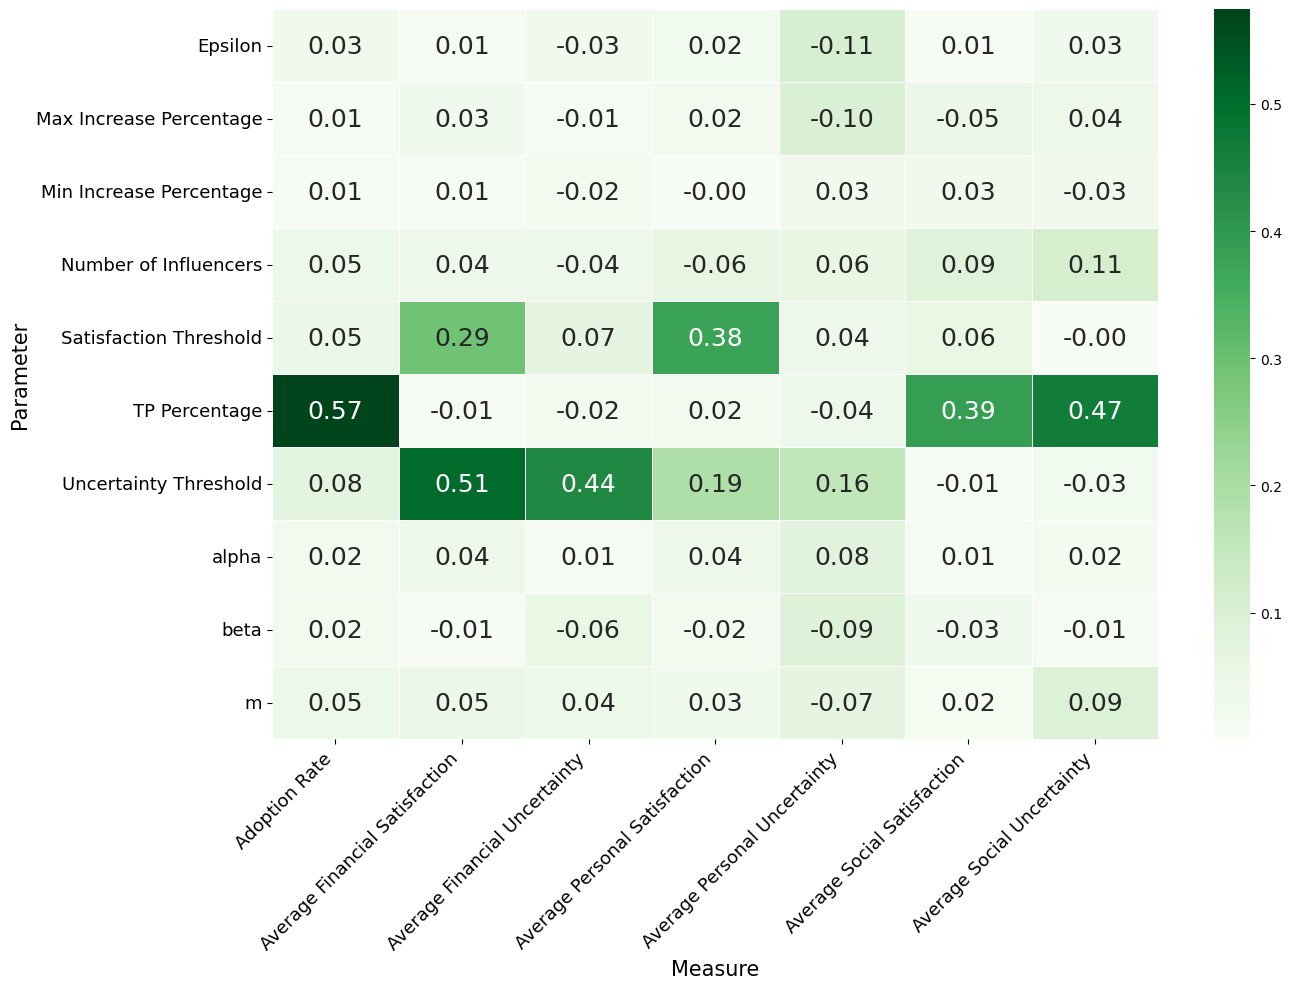

/var/folders/zk/_bvnn9sn4jz8m5lz73ljcjrr0000gn/T/ipykernel_5101/66448745.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data_str = data.applymap(lambda x: value_format.format(x) if not np.isnan(x) else '')


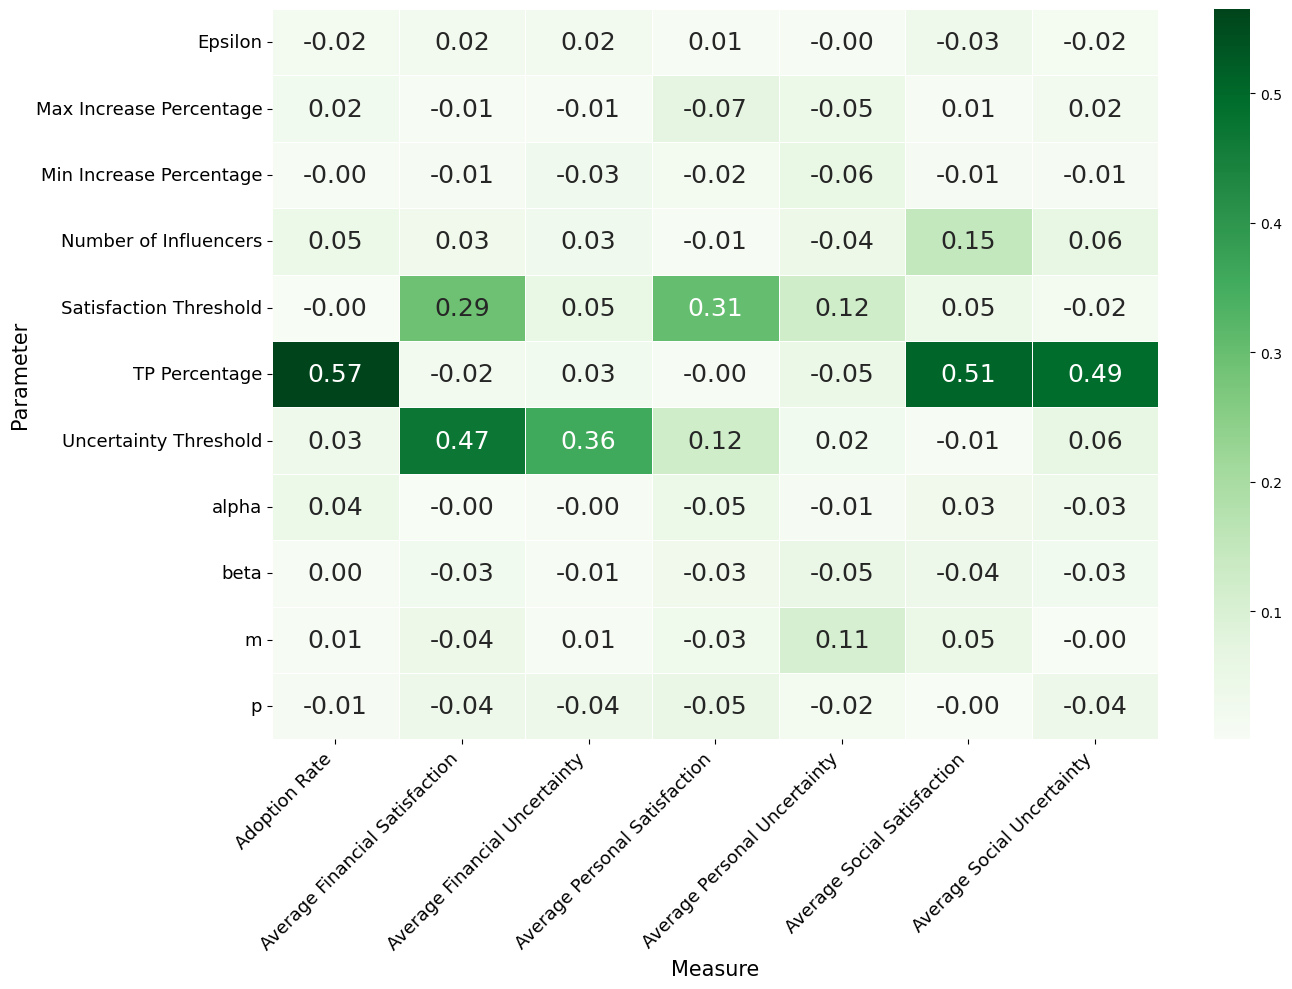

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the Excel file
file_path = '/Users/alexelphinstone/Downloads/ThesisNew-1/Experiments/influencer_experiment_pivot_S1.xlsx'
data = pd.read_excel(file_path)

# Replace commas with dots for correct decimal point handling
for column in data.columns[2:]:
    data[column] = data[column].astype(str).str.replace(',', '.')

# Convert the columns to numeric, coercing errors to NaN
for column in data.columns[2:]:
    data[column] = pd.to_numeric(data[column], errors='coerce')

# Melting the dataframe to have a long format for easier plotting
data_melted = pd.melt(data, id_vars=['Measure', 'Parameter'], value_vars=data.columns[2:], var_name='Network_Type', value_name='Value')

# Including all parameters by filling missing values with NaN
data_melted_clean = data_melted.pivot_table(index=['Parameter', 'Measure'], columns='Network_Type', values='Value').reset_index()

# Custom function to annotate heatmap with original values
def annot_heatmap(data, value_format="{:.2f}"):
    data_str = data.applymap(lambda x: value_format.format(x) if not np.isnan(x) else '')
    return data_str

# Function to create heatmaps for each network type
def create_heatmaps(data, network_type):
    pivot_table = data.pivot_table(index="Parameter", columns="Measure", values=network_type)
    pivot_table = pivot_table.dropna(how='any', axis=0)  # Dropping rows with any NaN values
    plt.figure(figsize=(14, 10))
    abs_values = pivot_table.abs()  # Using absolute values for coloring
    sns.heatmap(abs_values, annot=annot_heatmap(pivot_table), fmt="", cmap="Greens", linewidths=.5, annot_kws={"size": 18})
    plt.xlabel('Measure', fontsize=15)
    plt.ylabel('Parameter', fontsize=15)
    plt.xticks(rotation=45, ha='right', fontsize=13)
    plt.yticks(rotation=0, fontsize=13)
    plt.tight_layout()
    plt.savefig(f'/Users/alexelphinstone/Downloads/ThesisNew-1/Experiments/influencer_S1_{network_type}.png')
    plt.show()

# Create heatmaps for each network type
network_types = data_melted_clean.columns[2:]

for network in network_types:
    create_heatmaps(data_melted_clean, network)


/var/folders/zk/_bvnn9sn4jz8m5lz73ljcjrr0000gn/T/ipykernel_5101/254635925.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data_str = data.applymap(lambda x: value_format.format(x) if not np.isnan(x) else '')


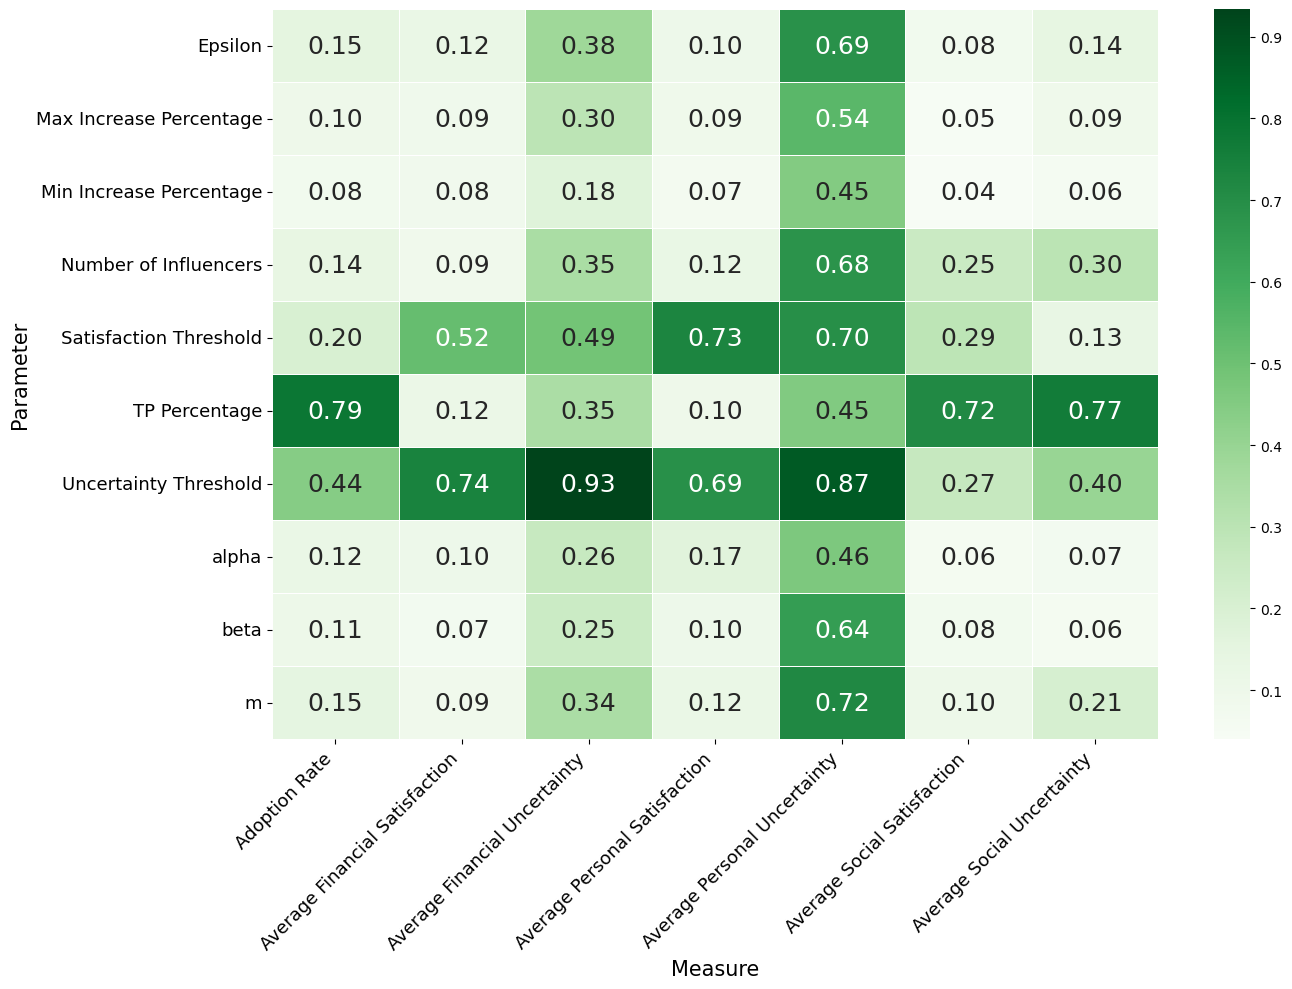

/var/folders/zk/_bvnn9sn4jz8m5lz73ljcjrr0000gn/T/ipykernel_5101/254635925.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data_str = data.applymap(lambda x: value_format.format(x) if not np.isnan(x) else '')


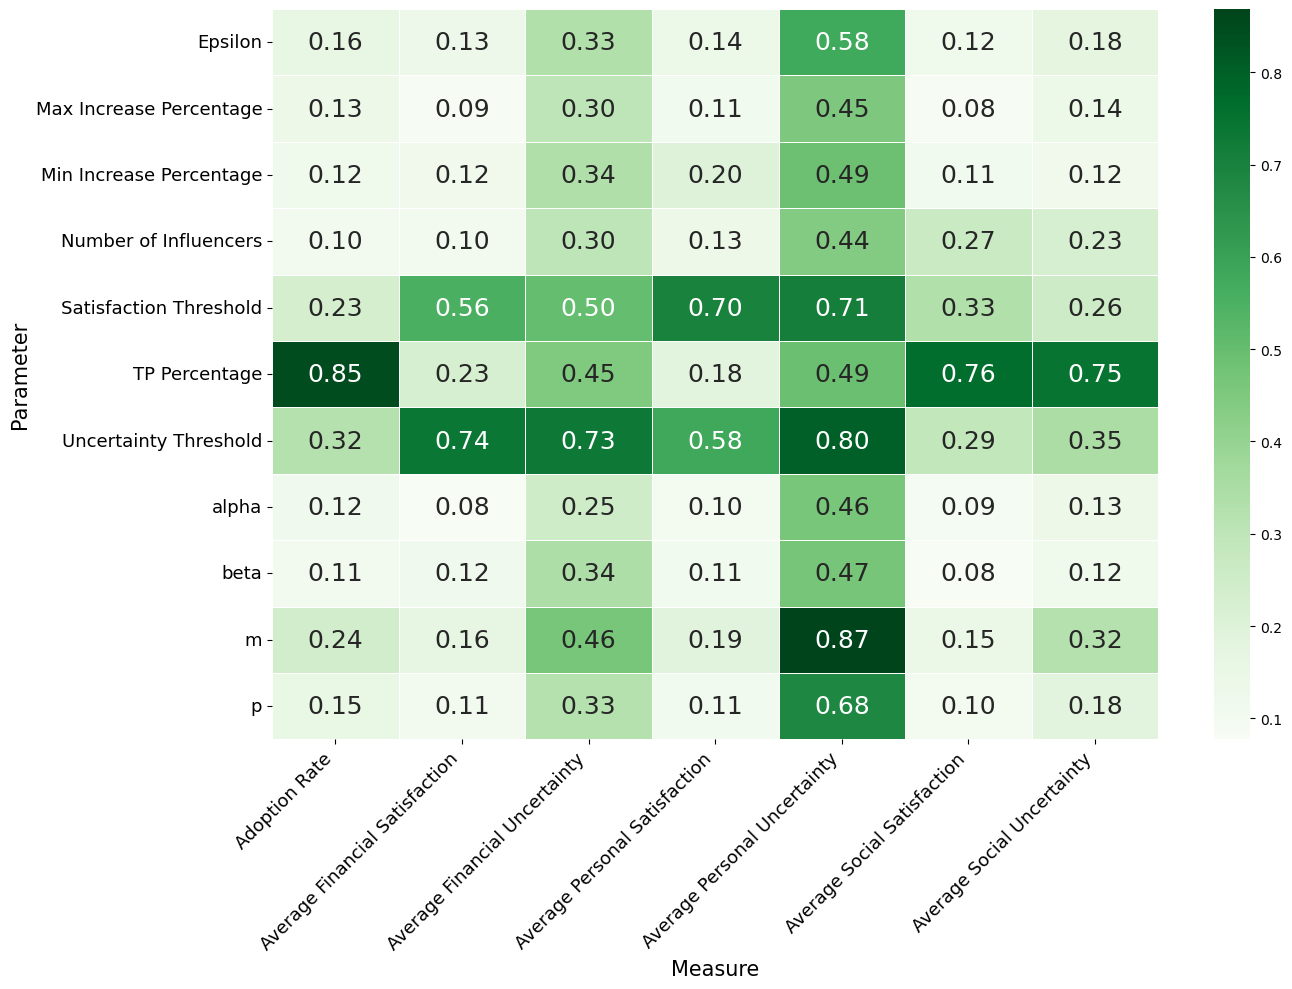

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the Excel file
file_path = '/Users/alexelphinstone/Downloads/ThesisNew-1/Experiments/influencer_experiment_pivot_ST.xlsx'
data = pd.read_excel(file_path)

# Replace commas with dots for correct decimal point handling
for column in data.columns[2:]:
    data[column] = data[column].astype(str).str.replace(',', '.')

# Convert the columns to numeric, coercing errors to NaN
for column in data.columns[2:]:
    data[column] = pd.to_numeric(data[column], errors='coerce')

# Melting the dataframe to have a long format for easier plotting
data_melted = pd.melt(data, id_vars=['Measure', 'Parameter'], value_vars=data.columns[2:], var_name='Network_Type', value_name='Value')

# Including all parameters by filling missing values with NaN
data_melted_clean = data_melted.pivot_table(index=['Parameter', 'Measure'], columns='Network_Type', values='Value').reset_index()

# Custom function to annotate heatmap with original values
def annot_heatmap(data, value_format="{:.2f}"):
    data_str = data.applymap(lambda x: value_format.format(x) if not np.isnan(x) else '')
    return data_str

# Function to create heatmaps for each network type
def create_heatmaps(data, network_type):
    pivot_table = data.pivot_table(index="Parameter", columns="Measure", values=network_type)
    pivot_table = pivot_table.dropna(how='any', axis=0)  # Dropping rows with any NaN values
    plt.figure(figsize=(14, 10))
    abs_values = pivot_table.abs()  # Using absolute values for coloring
    sns.heatmap(abs_values, annot=annot_heatmap(pivot_table), fmt="", cmap="Greens", linewidths=.5, annot_kws={"size": 18})
    plt.xlabel('Measure', fontsize=15)
    plt.ylabel('Parameter', fontsize=15)
    plt.xticks(rotation=45, ha='right', fontsize=13)
    plt.yticks(rotation=0, fontsize=13)
    plt.tight_layout()
    plt.savefig(f'/Users/alexelphinstone/Downloads/ThesisNew-1/Experiments/influencer_ST_{network_type}.png')
    plt.show()

# Create heatmaps for each network type
network_types = data_melted_clean.columns[2:]

for network in network_types:
    create_heatmaps(data_melted_clean, network)


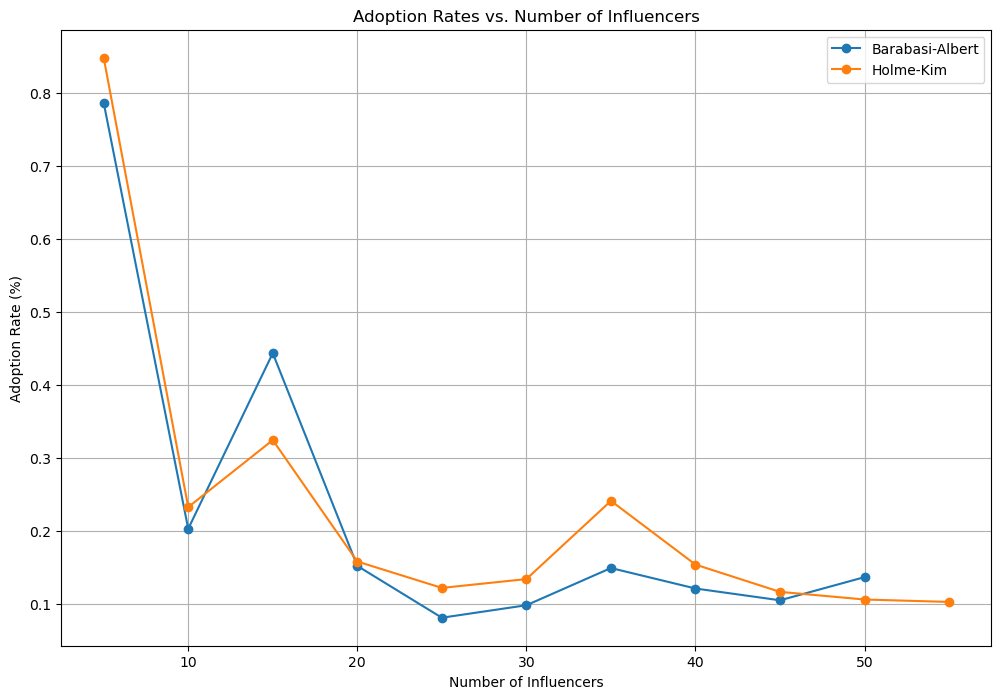

In [84]:
import json
import numpy as np
import matplotlib.pyplot as plt

# Load the results from JSON files
files = {
    "Barabasi-Albert": '/Users/alexelphinstone/Downloads/ThesisNew-1/Experiments/influencer_sensitivity_results_Barabasi-Albert_budget.json',
    "Holme-Kim": '/Users/alexelphinstone/Downloads/ThesisNew-1/Experiments/influencer_sensitivity_results_Holme-Kim_budget.json'
}

adoption_rates = {}

# Load data from files
for network, filepath in files.items():
    with open(filepath, 'r') as file:
        data = json.load(file)
        adoption_rate_data = data['Adoption Rate']['ST']
        adoption_rates[network] = adoption_rate_data

# Assuming you have a list of number of influencers values
num_influencers_values = np.arange(5, 105, 5)

# Plot the adoption rates for different numbers of influencers
plt.figure(figsize=(12, 8))

for network, rates in adoption_rates.items():
    plt.plot(num_influencers_values[:len(rates)], rates, marker='o', label=network)

plt.title('Adoption Rates vs. Number of Influencers')
plt.xlabel('Number of Influencers')
plt.ylabel('Adoption Rate (%)')
plt.legend()
plt.grid(True)
plt.show()


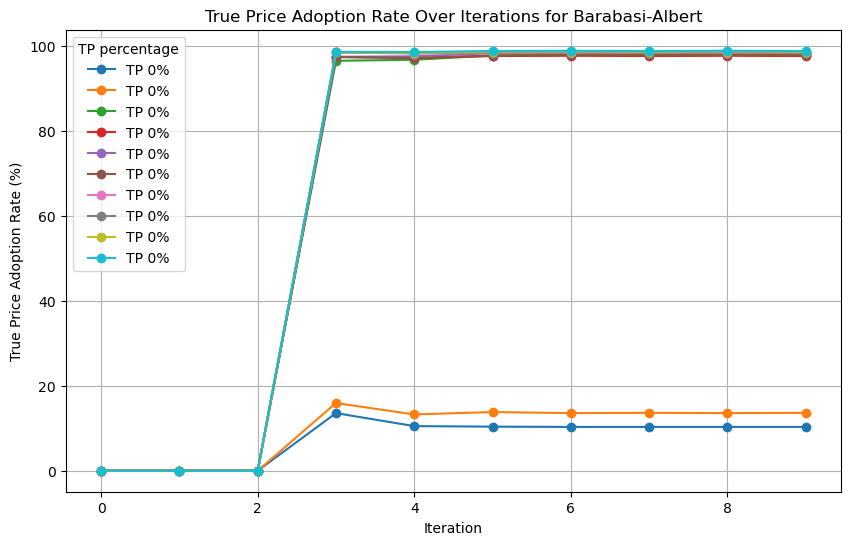

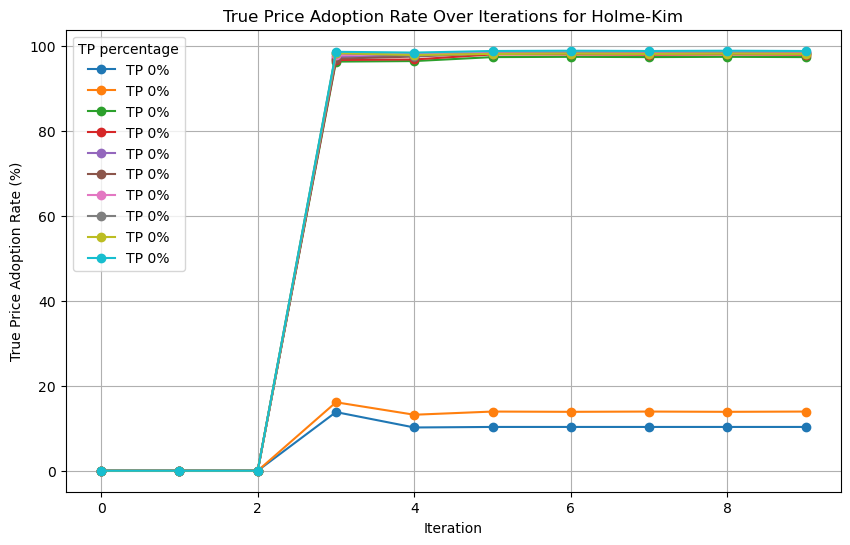

In [85]:

# Plot results
for network_name, config in network_configurations.items():
    plt.figure(figsize=(10, 6))
    
    # Plot individual simulations with transparency for each configuration
    for config_name, sim_data_list in all_simulation_data.items():
        if network_name in config_name:
            tp_percentage = float(config_name.split('_TP_')[-1].replace('%', '')) / 100
            tp_percentage_label = int(tp_percentage * 100)
            sim_data = sim_data_list[0]  # Assuming we have only one simulation per configuration
            plt.plot(sim_data['Adoption Rates'], marker='o', label=f'TP {tp_percentage_label}%')
    
    plt.title(f'True Price Adoption Rate Over Iterations for {network_name}')
    plt.xlabel('Iteration')
    plt.ylabel('True Price Adoption Rate (%)')
    plt.grid(True)
    plt.legend(title='TP percentage')
    plt.show()


Running simulations for Barabasi-Albert_Config_1_Influencers_0 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 0, 'network_type': 'barabasi_albert', 'network_params': {'n': 1600, 'm': 8}}


Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:00,  8.21it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  7.19it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 100.0%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  6.75it/s]

Iteration 5: True Price Adoption Rate = 100.0%
Iteration 6: True Price Adoption Rate = 100.0%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:01<00:00,  6.59it/s]

Iteration 7: True Price Adoption Rate = 100.0%
Iteration 8: True Price Adoption Rate = 100.0%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.86it/s]

Iteration 9: True Price Adoption Rate = 100.0%
Iteration 10: True Price Adoption Rate = 100.0%
Running simulations for Barabasi-Albert_Config_2_Influencers_10 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 10, 'network_type': 'barabasi_albert', 'network_params': {'n': 1600, 'm': 8}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:00,  8.25it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  8.36it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 97.5625%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  8.50it/s]

Iteration 5: True Price Adoption Rate = 96.875%
Iteration 6: True Price Adoption Rate = 97.875%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:00<00:00,  8.61it/s]

Iteration 7: True Price Adoption Rate = 97.8125%
Iteration 8: True Price Adoption Rate = 97.875%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.52it/s]

Iteration 9: True Price Adoption Rate = 97.8125%
Iteration 10: True Price Adoption Rate = 97.875%
Running simulations for Barabasi-Albert_Config_3_Influencers_20 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 20, 'network_type': 'barabasi_albert', 'network_params': {'n': 1600, 'm': 8}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:00,  8.22it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  8.30it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 97.4375%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  8.50it/s]

Iteration 5: True Price Adoption Rate = 97.1875%
Iteration 6: True Price Adoption Rate = 98.0%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:00<00:00,  8.61it/s]

Iteration 7: True Price Adoption Rate = 98.0%
Iteration 8: True Price Adoption Rate = 98.0625%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.51it/s]

Iteration 9: True Price Adoption Rate = 98.0%
Iteration 10: True Price Adoption Rate = 98.0625%
Running simulations for Barabasi-Albert_Config_4_Influencers_30 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 30, 'network_type': 'barabasi_albert', 'network_params': {'n': 1600, 'm': 8}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:00,  8.19it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  8.28it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 97.4375%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  8.47it/s]

Iteration 5: True Price Adoption Rate = 97.25%
Iteration 6: True Price Adoption Rate = 98.125%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:00<00:00,  8.56it/s]

Iteration 7: True Price Adoption Rate = 98.125%
Iteration 8: True Price Adoption Rate = 98.1875%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.48it/s]

Iteration 9: True Price Adoption Rate = 98.125%
Iteration 10: True Price Adoption Rate = 98.1875%
Running simulations for Barabasi-Albert_Config_5_Influencers_40 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 40, 'network_type': 'barabasi_albert', 'network_params': {'n': 1600, 'm': 8}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:01,  7.52it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  7.07it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 97.6875%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  7.86it/s]

Iteration 5: True Price Adoption Rate = 97.25%
Iteration 6: True Price Adoption Rate = 97.875%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:01<00:00,  8.26it/s]

Iteration 7: True Price Adoption Rate = 97.8125%
Iteration 8: True Price Adoption Rate = 97.875%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.94it/s]

Iteration 9: True Price Adoption Rate = 97.8125%
Iteration 10: True Price Adoption Rate = 97.875%
Running simulations for Barabasi-Albert_Config_6_Influencers_50 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 50, 'network_type': 'barabasi_albert', 'network_params': {'n': 1600, 'm': 8}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:00,  8.11it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  6.73it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 97.5%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  7.47it/s]

Iteration 5: True Price Adoption Rate = 97.0%
Iteration 6: True Price Adoption Rate = 97.9375%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:01<00:00,  7.87it/s]

Iteration 7: True Price Adoption Rate = 97.875%
Iteration 8: True Price Adoption Rate = 97.9375%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.66it/s]

Iteration 9: True Price Adoption Rate = 97.875%
Iteration 10: True Price Adoption Rate = 97.9375%
Running simulations for Barabasi-Albert_Config_7_Influencers_60 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 60, 'network_type': 'barabasi_albert', 'network_params': {'n': 1600, 'm': 8}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:00,  8.13it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  7.46it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 97.5%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  7.29it/s]

Iteration 5: True Price Adoption Rate = 97.1875%
Iteration 6: True Price Adoption Rate = 98.0625%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:01<00:00,  7.93it/s]

Iteration 7: True Price Adoption Rate = 98.0%
Iteration 8: True Price Adoption Rate = 98.0625%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.88it/s]

Iteration 9: True Price Adoption Rate = 98.0%
Iteration 10: True Price Adoption Rate = 98.0625%
Running simulations for Barabasi-Albert_Config_8_Influencers_70 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 70, 'network_type': 'barabasi_albert', 'network_params': {'n': 1600, 'm': 8}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:00,  8.21it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  6.61it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 97.1875%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  7.44it/s]

Iteration 5: True Price Adoption Rate = 97.375%
Iteration 6: True Price Adoption Rate = 98.1875%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:01<00:00,  7.98it/s]

Iteration 7: True Price Adoption Rate = 98.125%
Iteration 8: True Price Adoption Rate = 98.25%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.76it/s]

Iteration 9: True Price Adoption Rate = 98.1875%
Iteration 10: True Price Adoption Rate = 98.25%
Running simulations for Barabasi-Albert_Config_9_Influencers_80 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 80, 'network_type': 'barabasi_albert', 'network_params': {'n': 1600, 'm': 8}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:00,  8.13it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  7.20it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 97.5%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  7.37it/s]

Iteration 5: True Price Adoption Rate = 97.1875%
Iteration 6: True Price Adoption Rate = 98.0%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:01<00:00,  7.90it/s]

Iteration 7: True Price Adoption Rate = 97.9375%
Iteration 8: True Price Adoption Rate = 98.0%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.83it/s]

Iteration 9: True Price Adoption Rate = 97.9375%
Iteration 10: True Price Adoption Rate = 98.0%
Running simulations for Barabasi-Albert_Config_10_Influencers_90 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 90, 'network_type': 'barabasi_albert', 'network_params': {'n': 1600, 'm': 8}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:00,  8.19it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  6.89it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 97.375%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  7.31it/s]

Iteration 5: True Price Adoption Rate = 97.0625%
Iteration 6: True Price Adoption Rate = 97.75%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:01<00:00,  7.92it/s]

Iteration 7: True Price Adoption Rate = 97.6875%
Iteration 8: True Price Adoption Rate = 97.75%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.79it/s]

Iteration 9: True Price Adoption Rate = 97.6875%
Iteration 10: True Price Adoption Rate = 97.75%
Running simulations for Barabasi-Albert_Config_11_Influencers_100 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 100, 'network_type': 'barabasi_albert', 'network_params': {'n': 1600, 'm': 8}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:00,  8.16it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  6.66it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 97.5625%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  7.53it/s]

Iteration 5: True Price Adoption Rate = 97.75%
Iteration 6: True Price Adoption Rate = 98.375%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:01<00:00,  8.07it/s]

Iteration 7: True Price Adoption Rate = 98.3125%
Iteration 8: True Price Adoption Rate = 98.375%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.81it/s]

Iteration 9: True Price Adoption Rate = 98.3125%
Iteration 10: True Price Adoption Rate = 98.375%
Running simulations for Barabasi-Albert_Config_12_Influencers_110 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 110, 'network_type': 'barabasi_albert', 'network_params': {'n': 1600, 'm': 8}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:01,  6.27it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  7.24it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 97.4375%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  7.87it/s]

Iteration 5: True Price Adoption Rate = 97.125%
Iteration 6: True Price Adoption Rate = 98.125%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:01<00:00,  8.20it/s]

Iteration 7: True Price Adoption Rate = 98.0625%
Iteration 8: True Price Adoption Rate = 98.125%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.81it/s]

Iteration 9: True Price Adoption Rate = 98.0625%
Iteration 10: True Price Adoption Rate = 98.125%
Running simulations for Barabasi-Albert_Config_13_Influencers_120 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 120, 'network_type': 'barabasi_albert', 'network_params': {'n': 1600, 'm': 8}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:01,  6.53it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  7.32it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 97.5625%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  7.92it/s]

Iteration 5: True Price Adoption Rate = 96.8125%
Iteration 6: True Price Adoption Rate = 97.625%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:01<00:00,  8.16it/s]

Iteration 7: True Price Adoption Rate = 97.5625%
Iteration 8: True Price Adoption Rate = 97.625%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.83it/s]

Iteration 9: True Price Adoption Rate = 97.5625%
Iteration 10: True Price Adoption Rate = 97.625%
Running simulations for Barabasi-Albert_Config_14_Influencers_130 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 130, 'network_type': 'barabasi_albert', 'network_params': {'n': 1600, 'm': 8}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:01,  5.99it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  7.09it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 97.75%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  7.79it/s]

Iteration 5: True Price Adoption Rate = 97.5625%
Iteration 6: True Price Adoption Rate = 98.25%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:01<00:00,  8.13it/s]

Iteration 7: True Price Adoption Rate = 98.1875%
Iteration 8: True Price Adoption Rate = 98.3125%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.68it/s]

Iteration 9: True Price Adoption Rate = 98.25%
Iteration 10: True Price Adoption Rate = 98.3125%
Running simulations for Barabasi-Albert_Config_15_Influencers_140 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 140, 'network_type': 'barabasi_albert', 'network_params': {'n': 1600, 'm': 8}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:00,  8.23it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  8.15it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 97.5625%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  8.32it/s]

Iteration 5: True Price Adoption Rate = 97.4375%
Iteration 6: True Price Adoption Rate = 97.9375%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:00<00:00,  8.38it/s]

Iteration 7: True Price Adoption Rate = 98.0%
Iteration 8: True Price Adoption Rate = 98.0%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.32it/s]

Iteration 9: True Price Adoption Rate = 98.0%
Iteration 10: True Price Adoption Rate = 98.0%
Running simulations for Barabasi-Albert_Config_16_Influencers_150 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 150, 'network_type': 'barabasi_albert', 'network_params': {'n': 1600, 'm': 8}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:00,  8.18it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  7.81it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 97.625%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  7.11it/s]

Iteration 5: True Price Adoption Rate = 97.5%
Iteration 6: True Price Adoption Rate = 98.375%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:01<00:00,  6.46it/s]

Iteration 7: True Price Adoption Rate = 98.375%
Iteration 8: True Price Adoption Rate = 98.375%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.80it/s]

Iteration 9: True Price Adoption Rate = 98.375%
Iteration 10: True Price Adoption Rate = 98.375%
Running simulations for Barabasi-Albert_Config_17_Influencers_160 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 160, 'network_type': 'barabasi_albert', 'network_params': {'n': 1600, 'm': 8}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:00,  8.23it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  8.21it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 97.8125%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  8.28it/s]

Iteration 5: True Price Adoption Rate = 97.25%
Iteration 6: True Price Adoption Rate = 97.8125%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:00<00:00,  8.33it/s]

Iteration 7: True Price Adoption Rate = 97.75%
Iteration 8: True Price Adoption Rate = 97.75%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.28it/s]

Iteration 9: True Price Adoption Rate = 97.75%
Iteration 10: True Price Adoption Rate = 97.75%
Running simulations for Barabasi-Albert_Config_18_Influencers_170 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 170, 'network_type': 'barabasi_albert', 'network_params': {'n': 1600, 'm': 8}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:00,  8.16it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  8.14it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 97.8125%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  8.26it/s]

Iteration 5: True Price Adoption Rate = 97.375%
Iteration 6: True Price Adoption Rate = 98.125%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:00<00:00,  8.30it/s]

Iteration 7: True Price Adoption Rate = 98.125%
Iteration 8: True Price Adoption Rate = 98.1875%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.27it/s]

Iteration 9: True Price Adoption Rate = 98.1875%
Iteration 10: True Price Adoption Rate = 98.1875%
Running simulations for Barabasi-Albert_Config_19_Influencers_180 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 180, 'network_type': 'barabasi_albert', 'network_params': {'n': 1600, 'm': 8}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:00,  8.23it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  8.21it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 97.625%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  8.28it/s]

Iteration 5: True Price Adoption Rate = 97.5625%
Iteration 6: True Price Adoption Rate = 98.25%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:00<00:00,  8.32it/s]

Iteration 7: True Price Adoption Rate = 98.25%
Iteration 8: True Price Adoption Rate = 98.25%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.30it/s]

Iteration 9: True Price Adoption Rate = 98.25%
Iteration 10: True Price Adoption Rate = 98.25%
Running simulations for Barabasi-Albert_Config_20_Influencers_190 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 190, 'network_type': 'barabasi_albert', 'network_params': {'n': 1600, 'm': 8}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:00,  8.22it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  8.17it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 97.9375%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  8.24it/s]

Iteration 5: True Price Adoption Rate = 97.6875%
Iteration 6: True Price Adoption Rate = 98.3125%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:00<00:00,  8.27it/s]

Iteration 7: True Price Adoption Rate = 98.3125%
Iteration 8: True Price Adoption Rate = 98.375%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.26it/s]

Iteration 9: True Price Adoption Rate = 98.375%
Iteration 10: True Price Adoption Rate = 98.375%
Running simulations for Barabasi-Albert_Config_21_Influencers_200 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 200, 'network_type': 'barabasi_albert', 'network_params': {'n': 1600, 'm': 8}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:00,  8.16it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  8.09it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 97.75%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  8.14it/s]

Iteration 5: True Price Adoption Rate = 97.625%
Iteration 6: True Price Adoption Rate = 98.1875%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:00<00:00,  8.23it/s]

Iteration 7: True Price Adoption Rate = 98.1875%
Iteration 8: True Price Adoption Rate = 98.1875%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.20it/s]

Iteration 9: True Price Adoption Rate = 98.1875%
Iteration 10: True Price Adoption Rate = 98.1875%
Running simulations for Barabasi-Albert_Config_22_Influencers_210 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 210, 'network_type': 'barabasi_albert', 'network_params': {'n': 1600, 'm': 8}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:00,  8.24it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  8.12it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 97.8125%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  8.21it/s]

Iteration 5: True Price Adoption Rate = 97.625%
Iteration 6: True Price Adoption Rate = 98.3125%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:00<00:00,  8.28it/s]

Iteration 7: True Price Adoption Rate = 98.3125%
Iteration 8: True Price Adoption Rate = 98.3125%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.23it/s]

Iteration 9: True Price Adoption Rate = 98.3125%
Iteration 10: True Price Adoption Rate = 98.3125%
Running simulations for Barabasi-Albert_Config_23_Influencers_220 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 220, 'network_type': 'barabasi_albert', 'network_params': {'n': 1600, 'm': 8}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:00,  8.18it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  8.10it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 97.75%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  8.18it/s]

Iteration 5: True Price Adoption Rate = 97.375%
Iteration 6: True Price Adoption Rate = 98.0%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:00<00:00,  8.21it/s]

Iteration 7: True Price Adoption Rate = 98.0625%
Iteration 8: True Price Adoption Rate = 98.0625%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.18it/s]

Iteration 9: True Price Adoption Rate = 98.0625%
Iteration 10: True Price Adoption Rate = 98.0625%
Running simulations for Barabasi-Albert_Config_24_Influencers_230 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 230, 'network_type': 'barabasi_albert', 'network_params': {'n': 1600, 'm': 8}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:00,  8.18it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  8.13it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 97.75%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  8.21it/s]

Iteration 5: True Price Adoption Rate = 97.875%
Iteration 6: True Price Adoption Rate = 98.1875%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:00<00:00,  8.20it/s]

Iteration 7: True Price Adoption Rate = 98.1875%
Iteration 8: True Price Adoption Rate = 98.1875%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.20it/s]

Iteration 9: True Price Adoption Rate = 98.1875%
Iteration 10: True Price Adoption Rate = 98.1875%
Running simulations for Barabasi-Albert_Config_25_Influencers_240 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 240, 'network_type': 'barabasi_albert', 'network_params': {'n': 1600, 'm': 8}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:00,  8.25it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  8.19it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 98.125%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  8.19it/s]

Iteration 5: True Price Adoption Rate = 97.5625%
Iteration 6: True Price Adoption Rate = 98.375%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:00<00:00,  8.23it/s]

Iteration 7: True Price Adoption Rate = 98.375%
Iteration 8: True Price Adoption Rate = 98.375%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.23it/s]

Iteration 9: True Price Adoption Rate = 98.375%
Iteration 10: True Price Adoption Rate = 98.375%
Running simulations for Barabasi-Albert_Config_26_Influencers_250 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 250, 'network_type': 'barabasi_albert', 'network_params': {'n': 1600, 'm': 8}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:00,  8.17it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  8.02it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 97.75%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  8.13it/s]

Iteration 5: True Price Adoption Rate = 97.625%
Iteration 6: True Price Adoption Rate = 98.25%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:00<00:00,  8.17it/s]

Iteration 7: True Price Adoption Rate = 98.25%
Iteration 8: True Price Adoption Rate = 98.3125%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.15it/s]

Iteration 9: True Price Adoption Rate = 98.3125%
Iteration 10: True Price Adoption Rate = 98.3125%
Running simulations for Barabasi-Albert_Config_27_Influencers_260 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 260, 'network_type': 'barabasi_albert', 'network_params': {'n': 1600, 'm': 8}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:00,  8.26it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  8.09it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 98.0%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  8.15it/s]

Iteration 5: True Price Adoption Rate = 97.875%
Iteration 6: True Price Adoption Rate = 98.4375%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:00<00:00,  8.19it/s]

Iteration 7: True Price Adoption Rate = 98.5%
Iteration 8: True Price Adoption Rate = 98.5%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.15it/s]

Iteration 9: True Price Adoption Rate = 98.5%
Iteration 10: True Price Adoption Rate = 98.5%
Running simulations for Barabasi-Albert_Config_28_Influencers_270 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 270, 'network_type': 'barabasi_albert', 'network_params': {'n': 1600, 'm': 8}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:00,  8.07it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  8.03it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 97.375%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  8.11it/s]

Iteration 5: True Price Adoption Rate = 97.375%
Iteration 6: True Price Adoption Rate = 98.1875%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:00<00:00,  8.15it/s]

Iteration 7: True Price Adoption Rate = 98.1875%
Iteration 8: True Price Adoption Rate = 98.25%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.13it/s]

Iteration 9: True Price Adoption Rate = 98.25%
Iteration 10: True Price Adoption Rate = 98.25%
Running simulations for Barabasi-Albert_Config_29_Influencers_280 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 280, 'network_type': 'barabasi_albert', 'network_params': {'n': 1600, 'm': 8}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:00,  8.31it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  8.21it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 97.875%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  8.20it/s]

Iteration 5: True Price Adoption Rate = 97.875%
Iteration 6: True Price Adoption Rate = 98.375%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:00<00:00,  8.19it/s]

Iteration 7: True Price Adoption Rate = 98.4375%
Iteration 8: True Price Adoption Rate = 98.4375%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.21it/s]

Iteration 9: True Price Adoption Rate = 98.4375%
Iteration 10: True Price Adoption Rate = 98.4375%
Running simulations for Barabasi-Albert_Config_30_Influencers_290 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 290, 'network_type': 'barabasi_albert', 'network_params': {'n': 1600, 'm': 8}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:00,  8.20it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  8.06it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 98.0625%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  8.13it/s]

Iteration 5: True Price Adoption Rate = 97.5625%
Iteration 6: True Price Adoption Rate = 98.0625%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:00<00:00,  8.14it/s]

Iteration 7: True Price Adoption Rate = 98.0625%
Iteration 8: True Price Adoption Rate = 98.0625%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.14it/s]

Iteration 9: True Price Adoption Rate = 98.0625%
Iteration 10: True Price Adoption Rate = 98.0625%
Running simulations for Barabasi-Albert_Config_31_Influencers_300 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 300, 'network_type': 'barabasi_albert', 'network_params': {'n': 1600, 'm': 8}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:01,  6.72it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  30%|██████████████████████████▋                                                              | 3/10 [00:00<00:01,  5.88it/s]

Iteration 3: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:01,  3.91it/s]

Iteration 4: True Price Adoption Rate = 98.125%


Simulation Progress:  50%|████████████████████████████████████████████▌                                            | 5/10 [00:01<00:01,  2.97it/s]

Iteration 5: True Price Adoption Rate = 97.1875%


Simulation Progress:  70%|██████████████████████████████████████████████████████████████▎                          | 7/10 [00:01<00:00,  3.84it/s]

Iteration 6: True Price Adoption Rate = 97.9375%
Iteration 7: True Price Adoption Rate = 97.9375%


Simulation Progress:  90%|████████████████████████████████████████████████████████████████████████████████         | 9/10 [00:02<00:00,  5.26it/s]

Iteration 8: True Price Adoption Rate = 97.9375%
Iteration 9: True Price Adoption Rate = 97.9375%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.62it/s]


Iteration 10: True Price Adoption Rate = 97.9375%
Running simulations for Barabasi-Albert_Config_32_Influencers_310 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 310, 'network_type': 'barabasi_albert', 'network_params': {'n': 1600, 'm': 8}}


Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:00,  8.27it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  8.04it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 98.125%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  8.09it/s]

Iteration 5: True Price Adoption Rate = 97.5625%
Iteration 6: True Price Adoption Rate = 98.1875%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:00<00:00,  8.10it/s]

Iteration 7: True Price Adoption Rate = 98.1875%
Iteration 8: True Price Adoption Rate = 98.25%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.11it/s]

Iteration 9: True Price Adoption Rate = 98.25%
Iteration 10: True Price Adoption Rate = 98.25%
Running simulations for Barabasi-Albert_Config_33_Influencers_320 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 320, 'network_type': 'barabasi_albert', 'network_params': {'n': 1600, 'm': 8}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:00,  8.16it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  7.98it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 98.0%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  8.08it/s]

Iteration 5: True Price Adoption Rate = 97.8125%
Iteration 6: True Price Adoption Rate = 98.25%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:00<00:00,  8.06it/s]

Iteration 7: True Price Adoption Rate = 98.3125%
Iteration 8: True Price Adoption Rate = 98.3125%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.07it/s]

Iteration 9: True Price Adoption Rate = 98.3125%
Iteration 10: True Price Adoption Rate = 98.3125%
Running simulations for Barabasi-Albert_Config_34_Influencers_330 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 330, 'network_type': 'barabasi_albert', 'network_params': {'n': 1600, 'm': 8}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:00,  8.15it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  8.01it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 98.0%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  8.08it/s]

Iteration 5: True Price Adoption Rate = 97.5%
Iteration 6: True Price Adoption Rate = 98.3125%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:00<00:00,  8.10it/s]

Iteration 7: True Price Adoption Rate = 98.375%
Iteration 8: True Price Adoption Rate = 98.375%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.01it/s]

Iteration 9: True Price Adoption Rate = 98.375%
Iteration 10: True Price Adoption Rate = 98.375%
Running simulations for Barabasi-Albert_Config_35_Influencers_340 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 340, 'network_type': 'barabasi_albert', 'network_params': {'n': 1600, 'm': 8}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:00,  8.16it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  8.01it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 98.125%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  8.05it/s]

Iteration 5: True Price Adoption Rate = 97.875%
Iteration 6: True Price Adoption Rate = 98.5625%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:00<00:00,  8.01it/s]

Iteration 7: True Price Adoption Rate = 98.5625%
Iteration 8: True Price Adoption Rate = 98.5625%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.05it/s]

Iteration 9: True Price Adoption Rate = 98.5625%
Iteration 10: True Price Adoption Rate = 98.5625%
Running simulations for Barabasi-Albert_Config_36_Influencers_350 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 350, 'network_type': 'barabasi_albert', 'network_params': {'n': 1600, 'm': 8}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:00,  8.18it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  8.00it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 98.375%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  8.02it/s]

Iteration 5: True Price Adoption Rate = 98.375%
Iteration 6: True Price Adoption Rate = 98.75%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:00<00:00,  8.06it/s]

Iteration 7: True Price Adoption Rate = 98.75%
Iteration 8: True Price Adoption Rate = 98.75%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.06it/s]

Iteration 9: True Price Adoption Rate = 98.75%
Iteration 10: True Price Adoption Rate = 98.75%
Running simulations for Barabasi-Albert_Config_37_Influencers_360 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 360, 'network_type': 'barabasi_albert', 'network_params': {'n': 1600, 'm': 8}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:00,  8.23it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  7.88it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 98.25%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  7.91it/s]

Iteration 5: True Price Adoption Rate = 98.125%
Iteration 6: True Price Adoption Rate = 98.5%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:01<00:00,  7.80it/s]

Iteration 7: True Price Adoption Rate = 98.5%
Iteration 8: True Price Adoption Rate = 98.5%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.94it/s]

Iteration 9: True Price Adoption Rate = 98.5%
Iteration 10: True Price Adoption Rate = 98.5%
Running simulations for Barabasi-Albert_Config_38_Influencers_370 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 370, 'network_type': 'barabasi_albert', 'network_params': {'n': 1600, 'm': 8}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:00,  8.16it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  7.98it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 97.9375%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  8.03it/s]

Iteration 5: True Price Adoption Rate = 98.125%
Iteration 6: True Price Adoption Rate = 98.625%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:00<00:00,  8.02it/s]

Iteration 7: True Price Adoption Rate = 98.625%
Iteration 8: True Price Adoption Rate = 98.625%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.04it/s]

Iteration 9: True Price Adoption Rate = 98.625%
Iteration 10: True Price Adoption Rate = 98.625%
Running simulations for Barabasi-Albert_Config_39_Influencers_380 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 380, 'network_type': 'barabasi_albert', 'network_params': {'n': 1600, 'm': 8}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:00,  8.24it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  7.98it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 98.25%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  7.98it/s]

Iteration 5: True Price Adoption Rate = 97.5625%
Iteration 6: True Price Adoption Rate = 98.1875%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:00<00:00,  7.96it/s]

Iteration 7: True Price Adoption Rate = 98.1875%
Iteration 8: True Price Adoption Rate = 98.1875%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.99it/s]

Iteration 9: True Price Adoption Rate = 98.1875%
Iteration 10: True Price Adoption Rate = 98.1875%
Running simulations for Barabasi-Albert_Config_40_Influencers_390 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 390, 'network_type': 'barabasi_albert', 'network_params': {'n': 1600, 'm': 8}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:00,  8.17it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  7.98it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 98.3125%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  7.94it/s]

Iteration 5: True Price Adoption Rate = 97.6875%
Iteration 6: True Price Adoption Rate = 98.3125%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:01<00:00,  7.96it/s]

Iteration 7: True Price Adoption Rate = 98.3125%
Iteration 8: True Price Adoption Rate = 98.375%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.00it/s]

Iteration 9: True Price Adoption Rate = 98.375%
Iteration 10: True Price Adoption Rate = 98.375%
Running simulations for Holme-Kim_Config_1_Influencers_0 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 0, 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'rewiring_probability': 0.1}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:00,  8.10it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  7.12it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 100.0%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  6.65it/s]

Iteration 5: True Price Adoption Rate = 100.0%
Iteration 6: True Price Adoption Rate = 100.0%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:01<00:00,  6.40it/s]

Iteration 7: True Price Adoption Rate = 100.0%
Iteration 8: True Price Adoption Rate = 100.0%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.64it/s]

Iteration 9: True Price Adoption Rate = 100.0%
Iteration 10: True Price Adoption Rate = 100.0%
Running simulations for Holme-Kim_Config_2_Influencers_10 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 10, 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'rewiring_probability': 0.1}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:00,  8.02it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  8.21it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 96.9375%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  8.39it/s]

Iteration 5: True Price Adoption Rate = 96.6875%
Iteration 6: True Price Adoption Rate = 97.625%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:00<00:00,  8.50it/s]

Iteration 7: True Price Adoption Rate = 97.5625%
Iteration 8: True Price Adoption Rate = 97.625%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.37it/s]

Iteration 9: True Price Adoption Rate = 97.5625%
Iteration 10: True Price Adoption Rate = 97.625%
Running simulations for Holme-Kim_Config_3_Influencers_20 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 20, 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'rewiring_probability': 0.1}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:00,  8.22it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  8.28it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 97.5625%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  8.42it/s]

Iteration 5: True Price Adoption Rate = 97.5%
Iteration 6: True Price Adoption Rate = 98.0625%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:00<00:00,  8.50it/s]

Iteration 7: True Price Adoption Rate = 98.0%
Iteration 8: True Price Adoption Rate = 98.0625%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.43it/s]

Iteration 9: True Price Adoption Rate = 98.0%
Iteration 10: True Price Adoption Rate = 98.0625%
Running simulations for Holme-Kim_Config_4_Influencers_30 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 30, 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'rewiring_probability': 0.1}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:00,  8.08it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  7.80it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 97.1875%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  7.80it/s]

Iteration 5: True Price Adoption Rate = 96.6875%
Iteration 6: True Price Adoption Rate = 97.9375%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:01<00:00,  6.47it/s]

Iteration 7: True Price Adoption Rate = 97.875%
Iteration 8: True Price Adoption Rate = 97.9375%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.84it/s]

Iteration 9: True Price Adoption Rate = 97.875%
Iteration 10: True Price Adoption Rate = 97.9375%


Running simulations for Holme-Kim_Config_5_Influencers_40 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 40, 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'rewiring_probability': 0.1}}


Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:00,  8.13it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  8.18it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 97.375%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  8.41it/s]

Iteration 5: True Price Adoption Rate = 97.625%
Iteration 6: True Price Adoption Rate = 98.1875%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:00<00:00,  8.47it/s]

Iteration 7: True Price Adoption Rate = 98.125%
Iteration 8: True Price Adoption Rate = 98.1875%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.39it/s]

Iteration 9: True Price Adoption Rate = 98.125%
Iteration 10: True Price Adoption Rate = 98.1875%
Running simulations for Holme-Kim_Config_6_Influencers_50 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 50, 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'rewiring_probability': 0.1}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:00,  8.23it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  8.23it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 97.25%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  8.36it/s]

Iteration 5: True Price Adoption Rate = 96.6875%
Iteration 6: True Price Adoption Rate = 97.6875%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:00<00:00,  8.42it/s]

Iteration 7: True Price Adoption Rate = 97.625%
Iteration 8: True Price Adoption Rate = 97.6875%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.36it/s]

Iteration 9: True Price Adoption Rate = 97.625%
Iteration 10: True Price Adoption Rate = 97.6875%
Running simulations for Holme-Kim_Config_7_Influencers_60 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 60, 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'rewiring_probability': 0.1}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:00,  8.18it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  8.20it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 97.4375%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  8.37it/s]

Iteration 5: True Price Adoption Rate = 97.3125%
Iteration 6: True Price Adoption Rate = 97.875%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:00<00:00,  8.42it/s]

Iteration 7: True Price Adoption Rate = 97.9375%
Iteration 8: True Price Adoption Rate = 97.875%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.38it/s]

Iteration 9: True Price Adoption Rate = 97.9375%
Iteration 10: True Price Adoption Rate = 97.875%
Running simulations for Holme-Kim_Config_8_Influencers_70 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 70, 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'rewiring_probability': 0.1}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:01,  7.99it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  7.85it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 97.3125%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  8.14it/s]

Iteration 5: True Price Adoption Rate = 97.1875%
Iteration 6: True Price Adoption Rate = 97.9375%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:01<00:00,  7.61it/s]

Iteration 7: True Price Adoption Rate = 97.875%
Iteration 8: True Price Adoption Rate = 97.9375%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.78it/s]

Iteration 9: True Price Adoption Rate = 97.875%
Iteration 10: True Price Adoption Rate = 97.9375%
Running simulations for Holme-Kim_Config_9_Influencers_80 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 80, 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'rewiring_probability': 0.1}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:00,  8.13it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  8.16it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 97.1875%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  8.30it/s]

Iteration 5: True Price Adoption Rate = 96.8125%
Iteration 6: True Price Adoption Rate = 97.6875%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:00<00:00,  8.38it/s]

Iteration 7: True Price Adoption Rate = 97.625%
Iteration 8: True Price Adoption Rate = 97.6875%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.32it/s]

Iteration 9: True Price Adoption Rate = 97.625%
Iteration 10: True Price Adoption Rate = 97.6875%
Running simulations for Holme-Kim_Config_10_Influencers_90 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 90, 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'rewiring_probability': 0.1}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:00,  8.09it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  8.14it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 97.375%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  8.31it/s]

Iteration 5: True Price Adoption Rate = 97.25%
Iteration 6: True Price Adoption Rate = 98.1875%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:00<00:00,  8.41it/s]

Iteration 7: True Price Adoption Rate = 98.125%
Iteration 8: True Price Adoption Rate = 98.1875%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.26it/s]

Iteration 9: True Price Adoption Rate = 98.125%
Iteration 10: True Price Adoption Rate = 98.1875%
Running simulations for Holme-Kim_Config_11_Influencers_100 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 100, 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'rewiring_probability': 0.1}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:00,  8.20it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  8.18it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 97.375%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  8.30it/s]

Iteration 5: True Price Adoption Rate = 97.375%
Iteration 6: True Price Adoption Rate = 98.25%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:00<00:00,  8.33it/s]

Iteration 7: True Price Adoption Rate = 98.1875%
Iteration 8: True Price Adoption Rate = 98.25%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.31it/s]

Iteration 9: True Price Adoption Rate = 98.1875%
Iteration 10: True Price Adoption Rate = 98.25%
Running simulations for Holme-Kim_Config_12_Influencers_110 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 110, 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'rewiring_probability': 0.1}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:00,  8.17it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  8.15it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 97.625%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  8.28it/s]

Iteration 5: True Price Adoption Rate = 96.8125%
Iteration 6: True Price Adoption Rate = 97.875%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:00<00:00,  8.33it/s]

Iteration 7: True Price Adoption Rate = 97.8125%
Iteration 8: True Price Adoption Rate = 97.875%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.28it/s]

Iteration 9: True Price Adoption Rate = 97.8125%
Iteration 10: True Price Adoption Rate = 97.875%
Running simulations for Holme-Kim_Config_13_Influencers_120 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 120, 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'rewiring_probability': 0.1}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:00,  8.15it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  8.10it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 97.4375%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  8.25it/s]

Iteration 5: True Price Adoption Rate = 97.4375%
Iteration 6: True Price Adoption Rate = 98.0625%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:00<00:00,  8.30it/s]

Iteration 7: True Price Adoption Rate = 98.0%
Iteration 8: True Price Adoption Rate = 98.0625%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.27it/s]

Iteration 9: True Price Adoption Rate = 98.0%
Iteration 10: True Price Adoption Rate = 98.0625%
Running simulations for Holme-Kim_Config_14_Influencers_130 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 130, 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'rewiring_probability': 0.1}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:00,  8.04it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  7.95it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 97.375%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  8.03it/s]

Iteration 5: True Price Adoption Rate = 97.25%
Iteration 6: True Price Adoption Rate = 98.25%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:00<00:00,  8.09it/s]

Iteration 7: True Price Adoption Rate = 98.1875%
Iteration 8: True Price Adoption Rate = 98.25%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.02it/s]

Iteration 9: True Price Adoption Rate = 98.1875%
Iteration 10: True Price Adoption Rate = 98.25%
Running simulations for Holme-Kim_Config_15_Influencers_140 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 140, 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'rewiring_probability': 0.1}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:01,  7.66it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  7.99it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 97.375%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  8.13it/s]

Iteration 5: True Price Adoption Rate = 97.1875%
Iteration 6: True Price Adoption Rate = 97.75%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:00<00:00,  8.25it/s]

Iteration 7: True Price Adoption Rate = 97.6875%
Iteration 8: True Price Adoption Rate = 97.75%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.12it/s]

Iteration 9: True Price Adoption Rate = 97.6875%
Iteration 10: True Price Adoption Rate = 97.75%
Running simulations for Holme-Kim_Config_16_Influencers_150 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 150, 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'rewiring_probability': 0.1}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:00,  8.16it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  8.05it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 97.625%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  8.19it/s]

Iteration 5: True Price Adoption Rate = 97.0625%
Iteration 6: True Price Adoption Rate = 97.875%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:00<00:00,  8.25it/s]

Iteration 7: True Price Adoption Rate = 97.8125%
Iteration 8: True Price Adoption Rate = 97.875%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.22it/s]

Iteration 9: True Price Adoption Rate = 97.8125%
Iteration 10: True Price Adoption Rate = 97.875%
Running simulations for Holme-Kim_Config_17_Influencers_160 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 160, 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'rewiring_probability': 0.1}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:01,  7.97it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  8.02it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 96.6875%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  8.11it/s]

Iteration 5: True Price Adoption Rate = 96.875%
Iteration 6: True Price Adoption Rate = 98.0625%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:00<00:00,  8.20it/s]

Iteration 7: True Price Adoption Rate = 98.0%
Iteration 8: True Price Adoption Rate = 98.0625%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.15it/s]

Iteration 9: True Price Adoption Rate = 98.0%
Iteration 10: True Price Adoption Rate = 98.0625%
Running simulations for Holme-Kim_Config_18_Influencers_170 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 170, 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'rewiring_probability': 0.1}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:01,  7.80it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  7.91it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 96.6875%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  8.10it/s]

Iteration 5: True Price Adoption Rate = 96.875%
Iteration 6: True Price Adoption Rate = 98.0%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:00<00:00,  8.14it/s]

Iteration 7: True Price Adoption Rate = 97.9375%
Iteration 8: True Price Adoption Rate = 98.0%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.05it/s]

Iteration 9: True Price Adoption Rate = 97.9375%
Iteration 10: True Price Adoption Rate = 98.0%
Running simulations for Holme-Kim_Config_19_Influencers_180 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 180, 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'rewiring_probability': 0.1}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:00,  8.13it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  8.11it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 97.5%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  8.22it/s]

Iteration 5: True Price Adoption Rate = 97.75%
Iteration 6: True Price Adoption Rate = 98.375%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:00<00:00,  8.18it/s]

Iteration 7: True Price Adoption Rate = 98.3125%
Iteration 8: True Price Adoption Rate = 98.375%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.20it/s]

Iteration 9: True Price Adoption Rate = 98.3125%
Iteration 10: True Price Adoption Rate = 98.375%
Running simulations for Holme-Kim_Config_20_Influencers_190 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 190, 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'rewiring_probability': 0.1}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:00,  8.10it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  8.04it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 97.5625%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  8.17it/s]

Iteration 5: True Price Adoption Rate = 97.0625%
Iteration 6: True Price Adoption Rate = 98.125%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:00<00:00,  8.12it/s]

Iteration 7: True Price Adoption Rate = 98.125%
Iteration 8: True Price Adoption Rate = 98.1875%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.15it/s]

Iteration 9: True Price Adoption Rate = 98.125%
Iteration 10: True Price Adoption Rate = 98.1875%
Running simulations for Holme-Kim_Config_21_Influencers_200 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 200, 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'rewiring_probability': 0.1}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:00,  8.10it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  8.00it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 97.1875%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  7.92it/s]

Iteration 5: True Price Adoption Rate = 96.875%
Iteration 6: True Price Adoption Rate = 97.8125%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:00<00:00,  8.10it/s]

Iteration 7: True Price Adoption Rate = 97.75%
Iteration 8: True Price Adoption Rate = 97.8125%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.01it/s]

Iteration 9: True Price Adoption Rate = 97.75%
Iteration 10: True Price Adoption Rate = 97.8125%
Running simulations for Holme-Kim_Config_22_Influencers_210 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 210, 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'rewiring_probability': 0.1}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:01,  7.89it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  7.92it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 97.3125%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  7.84it/s]

Iteration 5: True Price Adoption Rate = 97.0625%
Iteration 6: True Price Adoption Rate = 98.25%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:01<00:00,  7.93it/s]

Iteration 7: True Price Adoption Rate = 98.1875%
Iteration 8: True Price Adoption Rate = 98.25%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.94it/s]

Iteration 9: True Price Adoption Rate = 98.1875%
Iteration 10: True Price Adoption Rate = 98.25%
Running simulations for Holme-Kim_Config_23_Influencers_220 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 220, 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'rewiring_probability': 0.1}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:00,  8.11it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  8.05it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 97.3125%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  8.12it/s]

Iteration 5: True Price Adoption Rate = 97.6875%
Iteration 6: True Price Adoption Rate = 98.375%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:00<00:00,  8.11it/s]

Iteration 7: True Price Adoption Rate = 98.3125%
Iteration 8: True Price Adoption Rate = 98.375%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.12it/s]

Iteration 9: True Price Adoption Rate = 98.3125%
Iteration 10: True Price Adoption Rate = 98.375%
Running simulations for Holme-Kim_Config_24_Influencers_230 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 230, 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'rewiring_probability': 0.1}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:00,  8.12it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  8.02it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 97.25%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  8.07it/s]

Iteration 5: True Price Adoption Rate = 97.0625%
Iteration 6: True Price Adoption Rate = 98.125%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:00<00:00,  8.13it/s]

Iteration 7: True Price Adoption Rate = 98.0625%
Iteration 8: True Price Adoption Rate = 98.125%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.12it/s]

Iteration 9: True Price Adoption Rate = 98.0625%
Iteration 10: True Price Adoption Rate = 98.125%
Running simulations for Holme-Kim_Config_25_Influencers_240 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 240, 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'rewiring_probability': 0.1}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:00,  8.15it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  8.02it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 97.75%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  8.12it/s]

Iteration 5: True Price Adoption Rate = 97.5%
Iteration 6: True Price Adoption Rate = 98.3125%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:00<00:00,  8.14it/s]

Iteration 7: True Price Adoption Rate = 98.25%
Iteration 8: True Price Adoption Rate = 98.3125%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.12it/s]

Iteration 9: True Price Adoption Rate = 98.25%
Iteration 10: True Price Adoption Rate = 98.3125%
Running simulations for Holme-Kim_Config_26_Influencers_250 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 250, 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'rewiring_probability': 0.1}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:00,  8.09it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  7.99it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 97.375%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  8.07it/s]

Iteration 5: True Price Adoption Rate = 97.1875%
Iteration 6: True Price Adoption Rate = 98.125%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:00<00:00,  8.11it/s]

Iteration 7: True Price Adoption Rate = 98.0625%
Iteration 8: True Price Adoption Rate = 98.125%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.10it/s]

Iteration 9: True Price Adoption Rate = 98.0625%
Iteration 10: True Price Adoption Rate = 98.125%
Running simulations for Holme-Kim_Config_27_Influencers_260 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 260, 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'rewiring_probability': 0.1}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:00,  8.12it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  7.95it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 97.5625%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  8.00it/s]

Iteration 5: True Price Adoption Rate = 97.3125%
Iteration 6: True Price Adoption Rate = 97.9375%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:00<00:00,  8.07it/s]

Iteration 7: True Price Adoption Rate = 97.875%
Iteration 8: True Price Adoption Rate = 97.9375%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.05it/s]

Iteration 9: True Price Adoption Rate = 97.875%
Iteration 10: True Price Adoption Rate = 97.9375%
Running simulations for Holme-Kim_Config_28_Influencers_270 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 270, 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'rewiring_probability': 0.1}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:01,  7.59it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  7.78it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 97.1875%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  7.94it/s]

Iteration 5: True Price Adoption Rate = 97.375%
Iteration 6: True Price Adoption Rate = 98.25%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:01<00:00,  7.99it/s]

Iteration 7: True Price Adoption Rate = 98.1875%
Iteration 8: True Price Adoption Rate = 98.25%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.92it/s]

Iteration 9: True Price Adoption Rate = 98.1875%
Iteration 10: True Price Adoption Rate = 98.25%
Running simulations for Holme-Kim_Config_29_Influencers_280 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 280, 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'rewiring_probability': 0.1}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:00,  8.06it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  7.95it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 97.5625%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  8.00it/s]

Iteration 5: True Price Adoption Rate = 97.5%
Iteration 6: True Price Adoption Rate = 98.3125%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:00<00:00,  8.02it/s]

Iteration 7: True Price Adoption Rate = 98.25%
Iteration 8: True Price Adoption Rate = 98.3125%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.03it/s]

Iteration 9: True Price Adoption Rate = 98.25%
Iteration 10: True Price Adoption Rate = 98.3125%
Running simulations for Holme-Kim_Config_30_Influencers_290 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 290, 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'rewiring_probability': 0.1}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:00,  8.19it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  8.05it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 97.5625%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  8.04it/s]

Iteration 5: True Price Adoption Rate = 97.375%
Iteration 6: True Price Adoption Rate = 98.25%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:00<00:00,  8.05it/s]

Iteration 7: True Price Adoption Rate = 98.1875%
Iteration 8: True Price Adoption Rate = 98.25%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.00it/s]

Iteration 9: True Price Adoption Rate = 98.1875%
Iteration 10: True Price Adoption Rate = 98.25%
Running simulations for Holme-Kim_Config_31_Influencers_300 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 300, 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'rewiring_probability': 0.1}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:00,  8.09it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  7.96it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 97.6875%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  8.00it/s]

Iteration 5: True Price Adoption Rate = 97.75%
Iteration 6: True Price Adoption Rate = 98.375%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:00<00:00,  8.05it/s]

Iteration 7: True Price Adoption Rate = 98.3125%
Iteration 8: True Price Adoption Rate = 98.375%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.04it/s]

Iteration 9: True Price Adoption Rate = 98.3125%
Iteration 10: True Price Adoption Rate = 98.375%
Running simulations for Holme-Kim_Config_32_Influencers_310 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 310, 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'rewiring_probability': 0.1}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:00,  8.03it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  7.94it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 97.75%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  7.94it/s]

Iteration 5: True Price Adoption Rate = 97.0625%
Iteration 6: True Price Adoption Rate = 97.8125%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:01<00:00,  7.93it/s]

Iteration 7: True Price Adoption Rate = 97.75%
Iteration 8: True Price Adoption Rate = 97.8125%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.97it/s]

Iteration 9: True Price Adoption Rate = 97.75%
Iteration 10: True Price Adoption Rate = 97.8125%
Running simulations for Holme-Kim_Config_33_Influencers_320 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 320, 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'rewiring_probability': 0.1}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:00,  8.20it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  8.01it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 97.8125%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  7.93it/s]

Iteration 5: True Price Adoption Rate = 97.6875%
Iteration 6: True Price Adoption Rate = 98.4375%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:00<00:00,  7.97it/s]

Iteration 7: True Price Adoption Rate = 98.375%
Iteration 8: True Price Adoption Rate = 98.4375%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.01it/s]

Iteration 9: True Price Adoption Rate = 98.375%
Iteration 10: True Price Adoption Rate = 98.4375%
Running simulations for Holme-Kim_Config_34_Influencers_330 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 330, 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'rewiring_probability': 0.1}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:00,  8.10it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  7.88it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 97.625%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  7.88it/s]

Iteration 5: True Price Adoption Rate = 97.375%
Iteration 6: True Price Adoption Rate = 98.1875%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:01<00:00,  7.91it/s]

Iteration 7: True Price Adoption Rate = 98.125%
Iteration 8: True Price Adoption Rate = 98.1875%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.94it/s]

Iteration 9: True Price Adoption Rate = 98.125%
Iteration 10: True Price Adoption Rate = 98.1875%
Running simulations for Holme-Kim_Config_35_Influencers_340 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 340, 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'rewiring_probability': 0.1}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:00,  8.09it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  7.95it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 97.625%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  7.90it/s]

Iteration 5: True Price Adoption Rate = 97.625%
Iteration 6: True Price Adoption Rate = 98.375%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:01<00:00,  7.74it/s]

Iteration 7: True Price Adoption Rate = 98.3125%
Iteration 8: True Price Adoption Rate = 98.375%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.89it/s]

Iteration 9: True Price Adoption Rate = 98.3125%
Iteration 10: True Price Adoption Rate = 98.375%
Running simulations for Holme-Kim_Config_36_Influencers_350 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 350, 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'rewiring_probability': 0.1}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:00,  8.10it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  7.92it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 97.75%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  7.87it/s]

Iteration 5: True Price Adoption Rate = 97.6875%
Iteration 6: True Price Adoption Rate = 98.4375%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:01<00:00,  7.94it/s]

Iteration 7: True Price Adoption Rate = 98.4375%
Iteration 8: True Price Adoption Rate = 98.5%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.94it/s]

Iteration 9: True Price Adoption Rate = 98.4375%
Iteration 10: True Price Adoption Rate = 98.5%
Running simulations for Holme-Kim_Config_37_Influencers_360 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 360, 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'rewiring_probability': 0.1}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:01,  7.97it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  7.87it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 97.5%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  7.84it/s]

Iteration 5: True Price Adoption Rate = 97.3125%
Iteration 6: True Price Adoption Rate = 98.25%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:01<00:00,  7.80it/s]

Iteration 7: True Price Adoption Rate = 98.1875%
Iteration 8: True Price Adoption Rate = 98.25%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.85it/s]

Iteration 9: True Price Adoption Rate = 98.1875%
Iteration 10: True Price Adoption Rate = 98.25%
Running simulations for Holme-Kim_Config_38_Influencers_370 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 370, 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'rewiring_probability': 0.1}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:00,  8.12it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  7.95it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 98.0%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  7.88it/s]

Iteration 5: True Price Adoption Rate = 97.5625%
Iteration 6: True Price Adoption Rate = 98.25%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:01<00:00,  7.91it/s]

Iteration 7: True Price Adoption Rate = 98.1875%
Iteration 8: True Price Adoption Rate = 98.25%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.93it/s]

Iteration 9: True Price Adoption Rate = 98.1875%
Iteration 10: True Price Adoption Rate = 98.25%
Running simulations for Holme-Kim_Config_39_Influencers_380 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 380, 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'rewiring_probability': 0.1}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:00,  8.12it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  7.93it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 97.75%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  7.85it/s]

Iteration 5: True Price Adoption Rate = 97.625%
Iteration 6: True Price Adoption Rate = 98.375%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:01<00:00,  7.86it/s]

Iteration 7: True Price Adoption Rate = 98.3125%
Iteration 8: True Price Adoption Rate = 98.375%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.92it/s]

Iteration 9: True Price Adoption Rate = 98.3125%
Iteration 10: True Price Adoption Rate = 98.375%
Running simulations for Holme-Kim_Config_40_Influencers_390 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'num_influencers': 390, 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'rewiring_probability': 0.1}}



Simulation Progress:  20%|█████████████████▊                                                                       | 2/10 [00:00<00:00,  8.11it/s]

Iteration 1: True Price Adoption Rate = 0.0%
Iteration 2: True Price Adoption Rate = 0.0%


Simulation Progress:  40%|███████████████████████████████████▌                                                     | 4/10 [00:00<00:00,  7.94it/s]

Iteration 3: True Price Adoption Rate = 0.0%
Iteration 4: True Price Adoption Rate = 97.75%


Simulation Progress:  60%|█████████████████████████████████████████████████████▍                                   | 6/10 [00:00<00:00,  7.87it/s]

Iteration 5: True Price Adoption Rate = 97.625%
Iteration 6: True Price Adoption Rate = 98.3125%


Simulation Progress:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [00:01<00:00,  7.86it/s]

Iteration 7: True Price Adoption Rate = 98.25%
Iteration 8: True Price Adoption Rate = 98.3125%


Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.92it/s]

Iteration 9: True Price Adoption Rate = 98.25%
Iteration 10: True Price Adoption Rate = 98.3125%


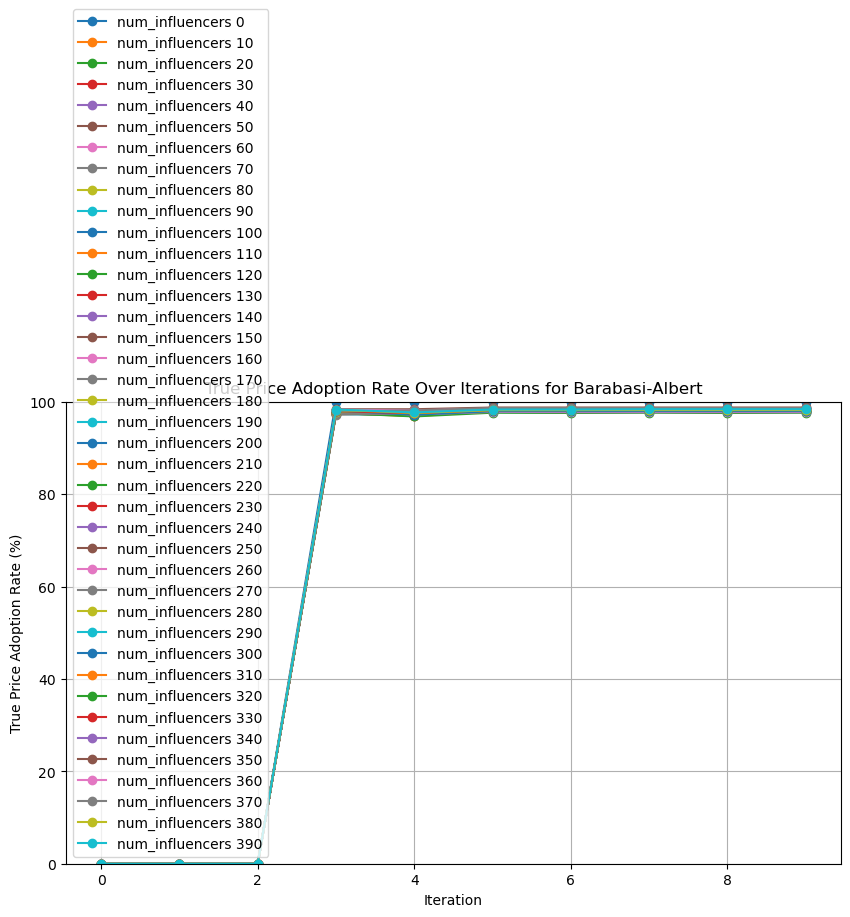

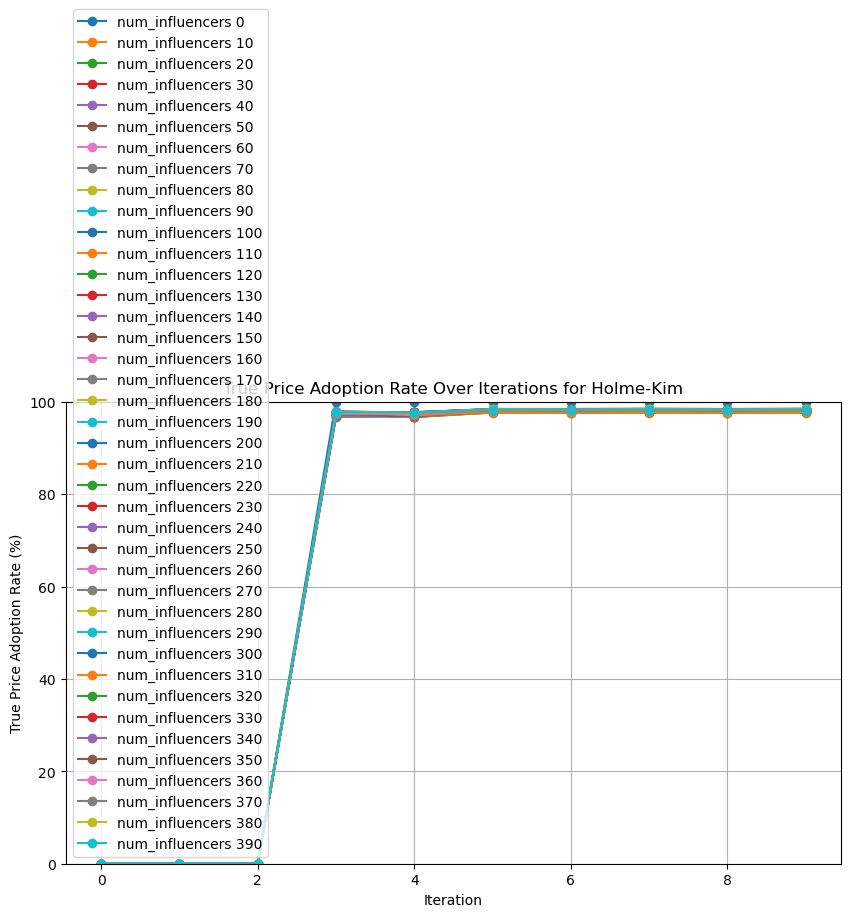

In [94]:
# Example network configurations (replace with actual configurations)
network_configurations = {
    
    'Barabasi-Albert': barabasi_albert_config,
    'Holme-Kim': holme_kim_config
}

# Varying parameters
varying_params = {
    'num_influencers': list(range(0, 400, 10)),  # Adjust this range as needed
}

num_simulations = 1
num_steps = 10

# Generate configurations
all_configurations = {}
for network_name, net_config in network_configurations.items():
    net_configs = generate_configurations({**base_config, **net_config}, varying_params)
    for idx, config in enumerate(net_configs):
        config_name = f"{network_name}_Config_{idx+1}_Influencers_{config['num_influencers']}"
        all_configurations[config_name] = config

# Run all simulations
results, all_simulation_data = run_all_simulations(all_configurations, num_steps, num_simulations)

# Plotting results
plot_adoption_rates(all_simulation_data, varying_params)


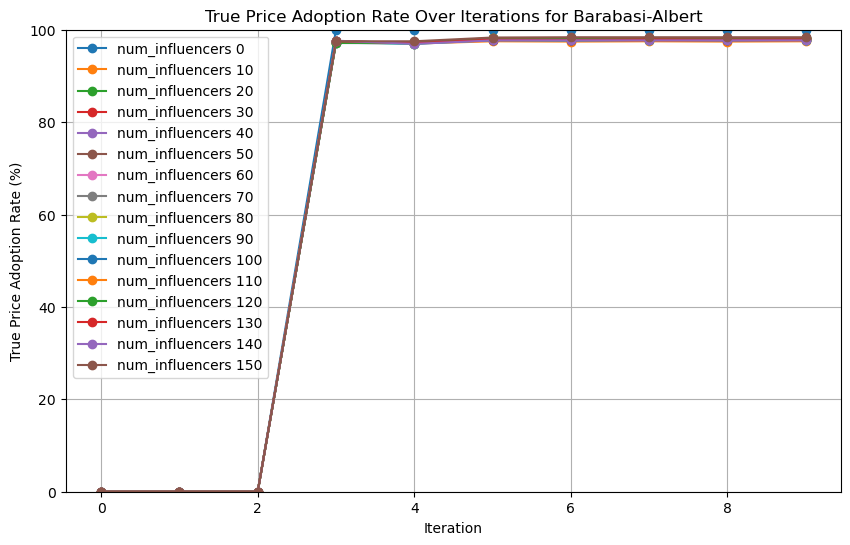

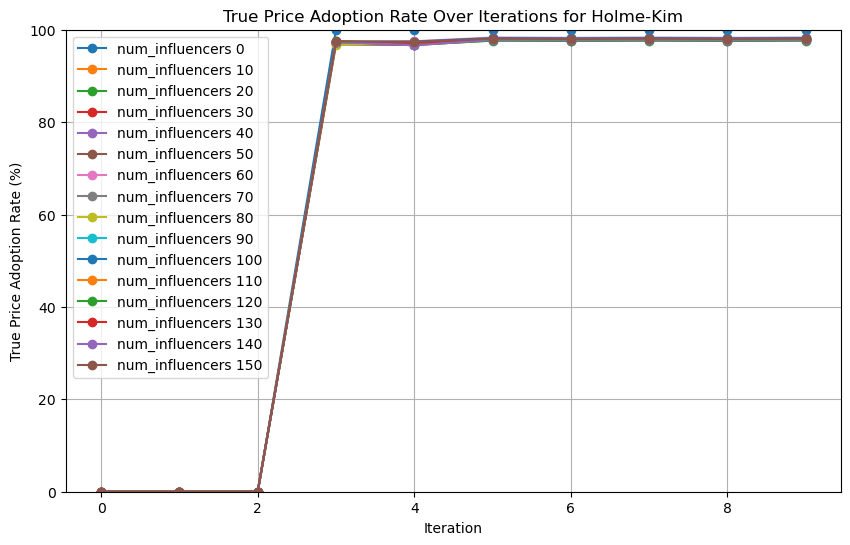

In [93]:
import matplotlib.pyplot as plt

def plot_adoption_rates(all_simulation_data, varying_params):
    param_name = list(varying_params.keys())[0]

    # Group configurations by network
    network_groups = {}
    for config_name in all_simulation_data.keys():
        network_name = config_name.split('_Config_')[0]
        if network_name not in network_groups:
            network_groups[network_name] = []
        network_groups[network_name].append(config_name)
    
    # Plot each network's configurations
    for network_name, config_names in network_groups.items():
        plt.figure(figsize=(10, 6))
        
        for config_name in config_names:
            data = all_simulation_data[config_name]
            num_influencers = config_name.split('_Influencers_')[1]
            for idx, sim_data in enumerate(data):
                plt.plot(sim_data['Adoption Rates'], marker='o', label=f'{param_name} {num_influencers}')
        
        plt.title(f'True Price Adoption Rate Over Iterations for {network_name}')
        plt.xlabel('Iteration')
        plt.ylabel('True Price Adoption Rate (%)')
        plt.ylim(0, 100)
        plt.grid(True)
        plt.legend()
        plt.savefig(f"/Users/alexelphinstone/Downloads/ThesisNew-1/Experiments/influencer_figures/{network_name}_varying_influencers.png")
        plt.show()

# Assuming varying_params is defined as:
varying_params = {
    'num_influencers': list(range(0, 160, 10)),  # Adjust this range as needed
}

# Assuming all_simulation_data is the data collected from the simulations
plot_adoption_rates(all_simulation_data, varying_params)
